In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

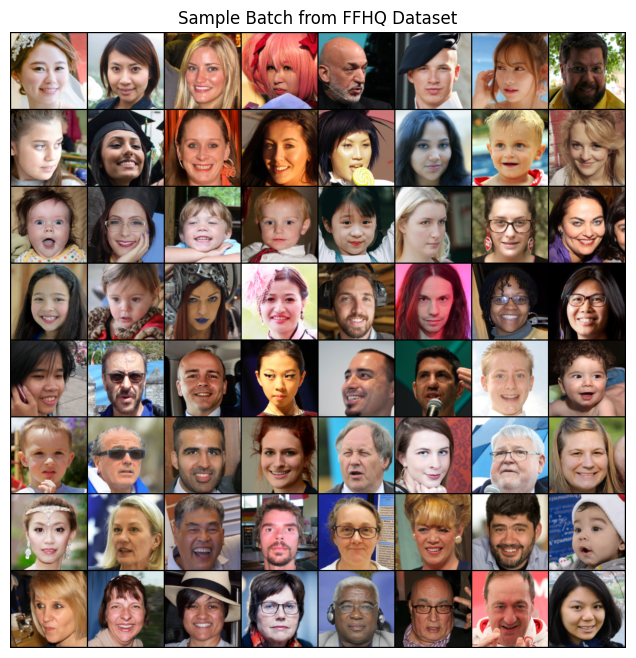

In [8]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Dataset Path
DATASET_PATH = "/kaggle/input/flickrfaceshq-dataset-ffhq"  # Update the path if needed

# Preprocessing Transformations
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)  # Normalization
])

# Custom Dataset Class
class FFHQDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.image_files = [
            os.path.join(dataset_path, file)
            for file in os.listdir(dataset_path)
            if file.endswith(".png")
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

# Load Dataset
dataset = FFHQDataset(DATASET_PATH, transform=transform)

# DataLoader for batching and shuffling
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Quick Check: Visualize a Batch
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_batch(dataloader):
    data_iter = iter(dataloader)
    images = next(data_iter)
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Sample Batch from FFHQ Dataset")
    plt.imshow(
        vutils.make_grid(images[:64], nrow=8, padding=2, normalize=True).permute(1, 2, 0)
    )
    plt.show()

show_batch(dataloader)

Generator

In [9]:
import torch.nn as nn
class Generator(nn.Module):
    def __init__(self, z_dim=128, img_channels=3, feature_maps=64):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, feature_maps * 8, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(feature_maps * 8),
            nn.ReLU(),
            # Output: (feature_maps * 8) x 4 x 4

            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(),
            # Output: (feature_maps * 4) x 8 x 8

            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(),
            # Output: (feature_maps * 2) x 16 x 16

            nn.ConvTranspose2d(feature_maps * 2, feature_maps, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(),
            # Output: feature_maps x 32 x 32

            nn.ConvTranspose2d(feature_maps, feature_maps // 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps // 2),
            nn.ReLU(),
            # Output: feature_maps/2 x 64 x 64

            nn.ConvTranspose2d(feature_maps // 2, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
            # Output: img_channels x 128 x 128
        )

    def forward(self, noise):
        return self.gen(noise)

Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, feature_maps=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # Input: img_channels x 128 x 128
            nn.Conv2d(img_channels, feature_maps, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # Output: feature_maps x 64 x 64

            nn.Conv2d(feature_maps, feature_maps * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2),
            # Output: (feature_maps * 2) x 32 x 32

            nn.Conv2d(feature_maps * 2, feature_maps * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2),
            # Output: (feature_maps * 4) x 16 x 16

            nn.Conv2d(feature_maps * 4, feature_maps * 8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2),
            # Output: (feature_maps * 8) x 8 x 8

            nn.Conv2d(feature_maps * 8, 1, kernel_size=4, stride=1, padding=0)
            # Output: 1 x 1 x 1 (real/fake score)
        )

    def forward(self, image):
        return self.disc(image).view(-1)

In [11]:
import torch  # Import PyTorch

# Define Hyperparameters
z_dim = 128  # Size of the latent vector
lr = 1e-4    # Learning rate
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize Generator and Discriminator
gen = Generator(z_dim=z_dim, img_channels=3, feature_maps=64).to(device)
disc = Discriminator(img_channels=3, feature_maps=64).to(device)

# Check Generator's output shape
noise = torch.randn(4, z_dim, 1, 1).to(device)
fake = gen(noise)
print(f"Generated fake image shape: {fake.shape}")

# Optimizers
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

Generated fake image shape: torch.Size([4, 3, 128, 128])


WGAN with Gradient Penalty

Wasserstein Loss

In [12]:
def generator_loss(fake_pred):
    # Generator aims to maximize the discriminator output
    return -torch.mean(fake_pred)

def discriminator_loss(real_pred, fake_pred):
    # Discriminator aims to maximize real_pred - fake_pred
    return torch.mean(fake_pred) - torch.mean(real_pred)

Gradient Penalty

In [13]:
def gradient_penalty(discriminator, real, fake, device="cuda"):
    batch_size, channels, height, width = real.size()
    alpha = torch.rand(batch_size, 1, 1, 1, device=device).expand_as(real)
    interpolates = alpha * real + (1 - alpha) * fake
    interpolates.requires_grad_(True)

    disc_interpolates = discriminator(interpolates)
    gradients = torch.autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(disc_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = ((gradient_norm - 1) ** 2).mean()
    return penalty

Training Loop

In [16]:
import os
import torch.optim as optim
from tqdm import tqdm

# Hyperparameters
z_dim = 128
lr = 1e-4
lambda_gp = 10  # Gradient penalty coefficient
epochs = 30
device = "cuda"

# Directory for saving checkpoints
checkpoint_dir = "/kaggle/working/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Initialize models and optimizers
gen = Generator(z_dim=z_dim).to(device)
disc = Discriminator().to(device)
gen_opt = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.9))
disc_opt = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.9))

# Function to save checkpoint
def save_checkpoint(epoch, gen, disc, gen_opt, disc_opt, checkpoint_dir):
    checkpoint = {
        'epoch': epoch,
        'gen_state_dict': gen.state_dict(),
        'disc_state_dict': disc.state_dict(),
        'gen_opt_state_dict': gen_opt.state_dict(),
        'disc_opt_state_dict': disc_opt.state_dict()
    }
    torch.save(checkpoint, os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pth"))
    print(f"Checkpoint saved for epoch {epoch}")

# Function to load checkpoint
def load_checkpoint(checkpoint_path, gen, disc, gen_opt, disc_opt):
    checkpoint = torch.load(checkpoint_path)
    gen.load_state_dict(checkpoint['gen_state_dict'])
    disc.load_state_dict(checkpoint['disc_state_dict'])
    gen_opt.load_state_dict(checkpoint['gen_opt_state_dict'])
    disc_opt.load_state_dict(checkpoint['disc_opt_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}")
    return start_epoch

# Check if there's a checkpoint to resume from
start_epoch = 0
latest_checkpoint = None
if os.path.exists(checkpoint_dir):
    checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")]
    if checkpoints:
        latest_checkpoint = os.path.join(checkpoint_dir, sorted(checkpoints, key=lambda x: int(x.split('_')[-1].split('.')[0]))[-1])
        start_epoch = load_checkpoint(latest_checkpoint, gen, disc, gen_opt, disc_opt) + 1

# Training Loop
for epoch in range(start_epoch, epochs):
    for real in tqdm(dataloader):
        real = real.to(device)
        cur_batch_size = real.size(0)

        # Generate fake images
        noise = torch.randn(cur_batch_size, z_dim, 1, 1).to(device)
        fake = gen(noise)

        # Debug: Print shapes of real and fake images
        print(f"Real: {real.shape}, Fake: {fake.shape}")

        # Train Discriminator
        disc_opt.zero_grad()

        # Get predictions for real and fake images
        real_pred = disc(real)
        fake_pred = disc(fake.detach())

        # Calculate gradient penalty
        gp = gradient_penalty(disc, real, fake, device)
        
        # Discriminator loss with gradient penalty
        d_loss = discriminator_loss(real_pred, fake_pred) + lambda_gp * gp

        # Backprop and optimize discriminator
        d_loss.backward()
        disc_opt.step()

        # Train Generator
        noise = torch.randn(cur_batch_size, z_dim, 1, 1).to(device)
        fake = gen(noise)
        gen_opt.zero_grad()

        # Get predictions for fake images
        fake_pred = disc(fake)

        # Generator loss
        g_loss = generator_loss(fake_pred)

        # Backprop and optimize generator
        g_loss.backward()
        gen_opt.step()

    # Print losses for the epoch
    print(f"Epoch {epoch}/{epochs} | D Loss: {d_loss.item()} | G Loss: {g_loss.item()}")

    # Save checkpoint at the end of each epoch
    save_checkpoint(epoch, gen, disc, gen_opt, disc_opt, checkpoint_dir)

  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:02<31:54,  2.36s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<17:17,  1.28s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:03<12:37,  1.07it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<10:27,  1.29it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:04<09:13,  1.46it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:30,  1.58it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<08:03,  1.67it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:06<07:46,  1.72it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:34,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:07<07:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:08<07:17,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:15,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:09<07:15,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:14,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:10<07:15,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:15,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:15,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:12<07:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:13<07:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:14<07:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:15<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:17<07:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:18,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:18<07:19,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:19,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:19<07:20,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:20,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:20<07:21,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:21,  1.76it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:22,  1.76it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:22<07:22,  1.75it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:22,  1.75it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:23<07:22,  1.75it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:23,  1.74it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:24<07:23,  1.74it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:25<07:24,  1.73it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:25<07:24,  1.73it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:26<07:25,  1.73it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:26,  1.72it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:27<07:26,  1.72it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:27,  1.71it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:28<07:27,  1.71it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:29<07:27,  1.71it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:29<07:26,  1.71it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:30<07:26,  1.71it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:30<07:26,  1.70it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:31<07:26,  1.70it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:32<07:26,  1.70it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:32<07:27,  1.70it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:33<07:26,  1.70it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:33<07:26,  1.69it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:34<07:26,  1.69it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:35<07:26,  1.69it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:35<07:26,  1.69it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:36<07:25,  1.69it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:36<07:24,  1.69it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:37<07:24,  1.69it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:37<07:23,  1.69it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:38<07:21,  1.69it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:39<07:21,  1.69it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:39<07:19,  1.70it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:40<07:18,  1.70it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:40<07:17,  1.70it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:41<07:14,  1.71it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:42<07:13,  1.71it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:42<07:11,  1.72it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:43<07:08,  1.73it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:43<07:08,  1.73it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:44<07:05,  1.73it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:44<07:03,  1.74it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:45<07:00,  1.75it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:46<06:58,  1.76it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:46<06:56,  1.76it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:47<06:56,  1.76it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:47<06:54,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:48<06:53,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:48<06:52,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:49<06:51,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:50<06:49,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:50<06:47,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:51<06:46,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:51<06:43,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:52<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:52<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:53<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:53<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:54<06:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:55<06:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:55<06:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:56<06:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:56<06:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:57<06:30,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:57<06:30,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:58<06:29,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:58<06:28,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:59<06:27,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:59<06:27,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [01:00<06:27,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [01:01<06:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [01:01<06:25,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:02<06:23,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:02<06:24,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:03<06:23,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:03<06:21,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:04<06:20,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:04<06:20,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:05<06:20,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:05<06:19,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:06<06:18,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:06<06:17,  1.85it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:07<06:17,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:08<06:16,  1.85it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:08<06:14,  1.85it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:09<06:14,  1.85it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:09<06:12,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:10<06:12,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:10<06:11,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:11<06:11,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:11<06:09,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:12<06:09,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:12<06:08,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:13<06:08,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:13<06:06,  1.87it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:14<06:06,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:15<06:06,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:15<06:05,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:16<06:04,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:16<06:04,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:17<06:04,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:17<06:03,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:18<06:02,  1.87it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:18<06:01,  1.87it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:19<06:01,  1.87it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:19<06:01,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:20<06:00,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:20<06:00,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:21<05:59,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:22<05:58,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:22<05:58,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:23<05:58,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:23<05:59,  1.85it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:24<05:59,  1.85it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:24<05:57,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:25<05:57,  1.85it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:25<05:56,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:26<05:55,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:26<05:55,  1.85it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:27<05:55,  1.86it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:27<05:54,  1.85it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:28<05:54,  1.85it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:29<05:55,  1.85it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:29<05:54,  1.85it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:30<05:54,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:30<05:53,  1.85it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:31<05:53,  1.85it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:31<05:53,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:32<05:53,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:32<05:53,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:33<05:53,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:33<05:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:34<05:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:35<05:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:35<05:51,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:36<05:51,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:36<05:50,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:37<05:50,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:37<05:50,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:38<05:49,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:38<05:49,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:39<05:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:39<05:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:40<05:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:41<05:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:41<05:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:42<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:42<05:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:43<05:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:43<05:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:44<05:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:44<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:45<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:46<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:46<05:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:47<05:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:47<05:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:48<05:47,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:48<05:45,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:49<05:44,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:49<05:44,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:50<05:43,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:51<05:43,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:51<05:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:52<05:42,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:52<05:41,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:53<05:42,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:53<05:43,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:54<05:41,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:54<05:40,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:55<05:40,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:56<05:40,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:56<05:39,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:57<05:39,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:57<05:38,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:58<05:38,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:58<05:37,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:59<05:36,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [02:00<05:36,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [02:00<05:35,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [02:01<05:34,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:01<05:33,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:02<05:33,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:02<05:32,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:03<05:32,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:03<05:31,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:04<05:30,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:05<05:29,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:05<05:28,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:06<05:28,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:06<05:27,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:07<05:27,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:07<05:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:08<05:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:08<05:25,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:09<05:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:10<05:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:10<05:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:11<05:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:11<05:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:12<05:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:12<05:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:13<05:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:13<05:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:14<05:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:15<05:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:15<05:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:16<05:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:16<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:17<05:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:17<05:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:18<05:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:18<05:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:19<05:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:20<05:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:20<05:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:21<05:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:21<05:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:22<05:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:22<05:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:23<05:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:23<05:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:24<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:24<05:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:25<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:26<05:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:26<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:27<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:27<05:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:28<05:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:28<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:29<05:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:29<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:30<04:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:31<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:31<04:57,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:32<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:32<04:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:33<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:33<04:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:34<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:34<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:35<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:35<04:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:36<04:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:37<04:51,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:37<04:50,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:38<04:50,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:38<04:50,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:39<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:39<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:40<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:40<04:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:41<04:47,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:42<04:46,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:42<04:46,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:43<04:45,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:43<04:44,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:44<04:44,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:44<04:43,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:45<04:43,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:45<04:43,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:46<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:46<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:47<04:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:48<04:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:48<04:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:49<04:39,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:49<04:38,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:50<04:37,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:50<04:37,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:51<04:36,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:51<04:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:52<04:35,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:52<04:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:53<04:34,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:54<04:33,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:54<04:33,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:55<04:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:55<04:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:56<04:31,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:56<04:30,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:57<04:30,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:57<04:30,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:58<04:29,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:58<04:29,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:59<04:28,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [03:00<04:28,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [03:00<04:27,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [03:01<04:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:01<04:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:02<04:25,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:02<04:25,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:03<04:24,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:03<04:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:04<04:22,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:04<04:22,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:05<04:22,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:06<04:21,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:06<04:21,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:07<04:20,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:07<04:19,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:08<04:19,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:08<04:18,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:09<04:18,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:09<04:17,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:10<04:17,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:10<04:16,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:11<04:16,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:12<04:15,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:12<04:15,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:13<04:14,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:13<04:14,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:14<04:14,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:14<04:13,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:15<04:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:15<04:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:16<04:11,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:16<04:10,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:17<04:10,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:18<04:10,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:18<04:09,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:19<04:09,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:19<04:08,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:20<04:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:20<04:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:21<04:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:21<04:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:22<04:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:23<04:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:24<04:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:24<04:03,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:25<04:03,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:25<04:02,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:26<04:02,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:26<04:01,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:27<04:00,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:00,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:28<03:59,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<03:59,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:29<03:58,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:30<03:57,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:30<03:57,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:31<03:57,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:31<03:56,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:32<03:56,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:32<03:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:33<03:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:33<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:34<03:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:35<03:53,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:36<03:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:36<03:51,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:37<03:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:37<03:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:38<03:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:38<03:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:39<03:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:40<03:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:41<03:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:41<03:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:42<03:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:42<03:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:43<03:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:43<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:44<03:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:45<03:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:46<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:47<03:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:47<03:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:48<03:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:48<03:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:49<03:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:49<03:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:50<03:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:51<03:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:52<03:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:52<03:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:53<03:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:53<03:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:54<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:54<03:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:55<03:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:56<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:57<03:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:58<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:58<03:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:59<03:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:59<03:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [04:00<03:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:00<03:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:01<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:02<03:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:03<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:03<03:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:04<03:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:04<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:05<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:05<03:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:06<03:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:07<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:08<03:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:08<03:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:09<03:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:09<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:10<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:10<03:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:11<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:11<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:12<03:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:13<03:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:14<03:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:14<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:15<03:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:15<03:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:16<03:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:16<03:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:17<03:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:18<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:19<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:19<03:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:20<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:20<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:21<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:21<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:22<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:23<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:24<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:25<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:25<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:26<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:26<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:27<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:27<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:28<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:29<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:30<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:30<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:31<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:31<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:32<02:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:32<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:33<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:34<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:35<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:35<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:36<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:37<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:37<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:38<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:38<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:39<02:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:40<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:41<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:42<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:43<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:44<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:45<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:46<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:47<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:48<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:48<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:49<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:49<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:50<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:51<02:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:51<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:52<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:53<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:53<02:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:54<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:54<02:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:55<02:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:56<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:56<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:57<02:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:58<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:59<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:59<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [05:00<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:00<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:01<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:02<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:02<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:03<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:04<02:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:04<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:05<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:05<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:06<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:07<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:07<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:08<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:09<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:09<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:10<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:10<02:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:11<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:12<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:12<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:13<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:13<02:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:14<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:15<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:15<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:16<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:17<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:17<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:18<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:18<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:19<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:20<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:20<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:21<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:21<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:22<02:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:23<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:23<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:24<02:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:25<02:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:25<02:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:26<02:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:26<02:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:27<02:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:28<02:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:28<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:29<02:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:29<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:30<02:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:30<02:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:31<01:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:31<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:32<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:33<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:33<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:34<01:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:34<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:35<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:35<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:36<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:36<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:37<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:38<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:38<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:39<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:39<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:40<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:40<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:41<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:41<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:42<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:43<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:43<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:44<01:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:44<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:45<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:45<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:46<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:46<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:47<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:47<01:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:48<01:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:49<01:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:49<01:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:50<01:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:50<01:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:51<01:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:51<01:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:52<01:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:52<01:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:53<01:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:54<01:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:54<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:55<01:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:55<01:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:56<01:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:56<01:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:57<01:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:57<01:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:58<01:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:59<01:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:59<01:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [06:00<01:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [06:00<01:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:01<01:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:01<01:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:02<01:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:02<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:03<01:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:03<01:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:04<01:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:05<01:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:05<01:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:06<01:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:06<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:07<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:07<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:08<01:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:08<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:09<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:10<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:10<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:11<01:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:11<01:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:12<01:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:12<01:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:13<01:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:13<01:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:14<01:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:15<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:15<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:16<01:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:16<01:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:17<01:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:17<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:18<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:18<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:19<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:19<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:20<01:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:21<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:21<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:22<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:22<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:23<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:23<01:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:24<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:24<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:25<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:26<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:26<01:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:27<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:27<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:28<01:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:28<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:29<01:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:29<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:30<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:31<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:31<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:32<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:32<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:33<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:33<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:34<00:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:35<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:36<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:36<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:37<00:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:37<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:38<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:38<00:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:39<00:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:39<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:40<00:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:41<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:41<00:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:42<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:42<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:43<00:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:43<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:44<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:44<00:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:45<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:46<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:46<00:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:47<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:47<00:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:48<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:48<00:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:49<00:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:49<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:50<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:51<00:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:51<00:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:52<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:52<00:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:53<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:53<00:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:54<00:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:54<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:55<00:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:55<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:56<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:57<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:57<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:58<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:58<00:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:59<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:59<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [07:00<00:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [07:00<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:01<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:02<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:02<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:03<00:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:03<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:04<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:04<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:05<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:05<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:06<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:07<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:07<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:08<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:08<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:09<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:09<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:10<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:10<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:11<00:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:12<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:12<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:13<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:13<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:14<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:14<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:15<00:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:15<00:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:16<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:17<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:17<00:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:18<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:18<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:19<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:19<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:20<00:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:20<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:21<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:21<00:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:22<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:23<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:23<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:24<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:24<00:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:25<00:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:25<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:26<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:26<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:27<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:28<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:28<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:29<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:29<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:30<00:00,  1.81it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:30<00:00,  1.80it/s]


Epoch 0/30 | D Loss: -0.31791049242019653 | G Loss: 1.6852905750274658
Checkpoint saved for epoch 0


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<24:31,  1.81s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:28,  1.07s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<11:15,  1.20it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:44,  1.39it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:04<08:51,  1.52it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:19,  1.61it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<08:00,  1.68it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:48,  1.72it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:41,  1.74it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:33,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:29,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:10<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:15<07:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:31<06:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<06:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<06:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:36<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:41<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:45<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:50<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:55<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:00<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:05<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:07<06:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:10<06:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:12<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:17<06:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:22<06:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:27<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:28<06:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<06:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<06:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<06:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<06:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<06:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:32<06:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:33<06:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:37<05:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:38<05:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:39<05:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:42<05:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:43<05:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:44<05:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:47<05:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:48<05:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:49<05:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:50<05:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:53<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:54<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:55<05:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:58<05:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:59<05:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [02:00<05:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:03<05:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:04<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:05<05:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:06<05:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:08<05:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:09<05:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:10<05:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:11<05:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:13<05:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:14<05:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:15<05:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:16<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:17<05:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:18<05:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:19<05:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:20<05:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:21<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:22<05:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:23<05:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:24<05:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:25<05:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:26<05:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:27<05:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:28<05:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:28<05:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:29<05:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<05:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:30<05:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:31<05:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:32<05:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:33<04:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:33<04:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:34<04:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:35<04:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:36<04:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:37<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:38<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:38<04:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:39<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:39<04:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:40<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:41<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:42<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:43<04:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:44<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:44<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:45<04:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:46<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:47<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:48<04:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:49<04:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:49<04:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:50<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:51<04:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:52<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:53<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:54<04:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:54<04:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:55<04:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:55<04:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:56<04:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:57<04:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:58<04:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:59<04:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:59<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [03:00<04:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [03:00<04:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:01<04:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:02<04:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:03<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:04<04:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:04<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:05<04:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:05<04:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:06<04:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:07<04:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:08<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:09<04:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:09<04:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:10<04:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:10<04:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:11<04:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:11<04:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:12<04:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:13<04:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:14<04:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:14<04:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:15<04:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:15<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:16<04:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:16<04:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:17<04:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:18<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:19<04:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:19<04:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:20<04:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:20<04:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:21<04:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:21<04:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:22<04:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:23<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:24<04:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:24<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:25<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:25<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:26<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:26<04:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:27<04:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:28<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:29<04:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:29<04:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:30<04:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:30<04:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:31<04:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:31<04:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:32<03:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:32<03:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:33<03:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:34<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:34<03:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:35<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:35<03:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:36<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:36<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:37<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:37<03:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:38<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:38<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:39<03:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:40<03:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:40<03:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:41<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:41<03:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:42<03:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:42<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:43<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:43<03:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:44<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:45<03:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:45<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:46<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:46<03:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:47<03:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:47<03:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:48<03:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:48<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:49<03:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:50<03:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:50<03:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:51<03:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:51<03:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:52<03:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:52<03:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:53<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:53<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:54<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:55<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:55<03:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:56<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:56<03:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:57<03:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:57<03:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:58<03:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:58<03:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:59<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [04:00<03:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [04:00<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:01<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:01<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:02<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:02<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:03<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:03<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:04<03:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:05<03:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:05<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:06<03:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:06<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:07<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:07<03:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:08<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:08<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:09<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:09<03:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:10<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:11<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:11<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:12<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:12<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:13<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:13<03:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:14<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:14<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:15<03:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:16<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:16<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:17<03:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:17<03:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:18<03:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:18<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:19<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:19<03:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:20<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:21<03:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:21<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:22<03:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:22<03:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:23<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:23<03:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:24<03:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:24<03:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:25<03:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:26<03:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:26<03:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:27<03:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:27<03:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:28<03:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:28<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:29<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:29<03:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:30<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:31<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:31<03:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:32<02:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:32<02:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:33<02:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:33<02:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:34<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:34<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:35<02:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:36<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:36<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:37<02:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:37<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:38<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:38<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:39<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:39<02:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:40<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:41<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:41<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:42<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:42<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:43<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:43<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:44<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:44<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:45<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:45<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:46<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:47<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:47<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:48<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:48<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:49<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:49<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:50<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:50<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:51<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:52<02:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:52<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:53<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:53<02:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:54<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:54<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:55<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:55<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:56<02:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:57<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:57<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:58<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:58<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:59<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:59<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [05:00<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [05:00<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:01<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:02<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:02<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:03<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:03<02:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:04<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:04<02:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:05<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:05<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:06<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:06<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:07<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:08<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:08<02:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:09<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:09<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:10<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:10<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:11<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:11<02:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:12<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:13<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:13<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:14<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:14<02:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:15<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:15<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:16<02:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:16<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:17<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:18<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:18<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:19<02:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:19<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:20<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:20<02:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:21<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:21<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:22<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:23<02:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:23<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:24<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:24<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:25<02:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:25<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:26<02:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:26<02:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:27<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:28<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:28<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:29<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:29<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:30<02:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:30<02:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:31<02:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:31<01:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:32<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:33<01:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:33<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:34<01:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:34<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:35<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:35<01:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:36<01:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:36<01:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:37<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:37<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:38<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:39<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:39<01:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:40<01:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:40<01:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:41<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:41<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:42<01:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:42<01:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:43<01:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:44<01:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:44<01:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:45<01:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:45<01:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:46<01:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:46<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:47<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:47<01:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:48<01:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:49<01:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:49<01:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:50<01:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:50<01:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:51<01:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:51<01:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:52<01:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:52<01:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:53<01:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:54<01:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:54<01:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:55<01:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:55<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:56<01:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:56<01:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:57<01:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:57<01:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:58<01:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:59<01:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:59<01:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [06:00<01:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [06:00<01:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [06:01<01:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:01<01:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:02<01:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:02<01:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:03<01:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:04<01:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:04<01:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:05<01:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:05<01:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:06<01:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:06<01:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:07<01:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:07<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:08<01:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:09<01:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:09<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:10<01:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:10<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:11<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:11<01:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:12<01:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:12<01:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:13<01:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:14<01:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:14<01:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:15<01:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:15<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:16<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:16<01:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:17<01:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:17<01:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:18<01:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:19<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:19<01:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:20<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:20<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:21<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:21<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:22<01:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:22<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:23<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:23<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:24<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:25<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:25<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:26<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:26<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:27<01:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:27<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:28<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:28<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:29<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:30<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:30<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:31<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:31<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:32<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:32<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:33<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:33<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:34<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:35<00:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:35<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:36<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:36<00:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:37<00:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:37<00:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:38<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:38<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:39<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:40<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:40<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:41<00:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:41<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:42<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:42<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:43<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:43<00:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:44<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:45<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:45<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:46<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:46<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:47<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:47<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:48<00:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:48<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:49<00:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:50<00:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:50<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:51<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:51<00:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:52<00:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:52<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:53<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:53<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:54<00:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:54<00:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:55<00:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:56<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:56<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:57<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:57<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:58<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:58<00:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:59<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:59<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [07:00<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [07:01<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [07:01<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:02<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:02<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:03<00:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:03<00:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:04<00:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:04<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:05<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:06<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:06<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:07<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:07<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:08<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:08<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:09<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:09<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:10<00:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:11<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:11<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:12<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:12<00:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:13<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:13<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:14<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:14<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:15<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:15<00:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:16<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:17<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:17<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:18<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:18<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:19<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:19<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:20<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:20<00:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:21<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:22<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:22<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:23<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:23<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:24<00:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:24<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:25<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:25<00:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:26<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:27<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:27<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:28<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:28<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:29<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:29<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:30<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:30<00:00,  1.81it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:31<00:00,  1.80it/s]


Epoch 1/30 | D Loss: -0.15302467346191406 | G Loss: 1.3389912843704224
Checkpoint saved for epoch 1


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<24:21,  1.80s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:22,  1.06s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<11:08,  1.21it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:38,  1.40it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:03<08:50,  1.52it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:21,  1.61it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<08:01,  1.67it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:48,  1.72it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:38,  1.75it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:33,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:30,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:26,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:10<07:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:14<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<06:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:30<06:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<06:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<06:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<06:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:35<06:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:40<06:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:45<06:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:46<06:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:50<06:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:51<06:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:55<06:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:56<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:00<06:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:01<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:02<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:05<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:06<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:07<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:10<06:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:11<06:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:12<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:16<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:17<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:21<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:22<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:23<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:26<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:27<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:28<06:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<06:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<05:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<05:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:31<06:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:32<05:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:33<05:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:36<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:37<05:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:38<05:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:42<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:43<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:47<05:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:48<05:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:50<05:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:42,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:42,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:52<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:53<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:55<05:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:57<05:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:58<05:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [01:59<05:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:03<05:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:04<05:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:06<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:08<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:09<05:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:11<05:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:13<05:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:14<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:16<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:17<05:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:18<05:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:19<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:21<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:22<05:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:23<05:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:24<05:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:26<05:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:27<05:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:28<05:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:28<05:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<05:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:29<05:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:31<05:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<05:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:32<04:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:33<04:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:34<04:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:36<04:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:37<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:38<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:39<04:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:39<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:40<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:42<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:43<04:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:44<04:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:44<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:45<04:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:47<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:48<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:49<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:50<04:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:52<04:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:53<04:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:54<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:55<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:55<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:57<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:58<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:59<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [03:00<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:00<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:02<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:03<04:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:04<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:05<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:05<04:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:07<04:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:08<04:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:09<04:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:09<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:10<04:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:10<04:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:11<04:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:12<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:13<04:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:14<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:15<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:15<04:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:16<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:16<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:18<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:19<04:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:20<04:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:20<04:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:21<04:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:21<04:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:23<04:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:24<04:08,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:25<04:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:25<04:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:26<04:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:26<04:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:28<04:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:29<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:30<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:31<03:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:31<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:32<03:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:33<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:33<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:34<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:35<03:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:36<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:36<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:37<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:38<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:38<03:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:39<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:40<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:41<03:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:41<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:42<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:43<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:43<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:44<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:45<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:46<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:47<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:48<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:48<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:49<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:49<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:50<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:51<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:52<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:52<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:53<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:54<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:54<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:55<03:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:56<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:57<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:57<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:58<03:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:59<03:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:59<03:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [04:00<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:00<03:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:01<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:02<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:03<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:04<03:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:04<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:05<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:05<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:06<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:07<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:08<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:08<03:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:09<03:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:10<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:10<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:11<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:11<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:12<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:13<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:14<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:15<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:15<03:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:16<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:16<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:17<03:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:18<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:19<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:20<03:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:20<03:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:21<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:21<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:22<03:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:23<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:24<03:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:25<03:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:25<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:26<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:26<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:27<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:27<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:28<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:29<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:29<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:30<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:31<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:31<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:32<02:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:32<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:33<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:34<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:34<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:35<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:36<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:37<02:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:37<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:38<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:38<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:39<02:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:40<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:41<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:42<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:43<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:44<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:45<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:45<02:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:47<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:48<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:48<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:49<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:49<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:50<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:50<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:51<02:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:52<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:53<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:53<02:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:54<02:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:54<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:55<02:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:55<02:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:56<02:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:57<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:58<02:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:59<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:59<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [05:00<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:00<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:01<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:01<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:02<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:03<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:04<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:04<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:05<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:05<02:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:06<02:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:06<02:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:07<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:08<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:09<02:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:09<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:10<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:10<02:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:11<02:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:11<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:12<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:12<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:13<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:14<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:15<02:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:15<02:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:16<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:16<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:17<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:17<02:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:18<02:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:19<02:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:20<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:20<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:21<02:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:21<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:22<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:22<02:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:23<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:24<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:25<02:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:25<02:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:26<02:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:26<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:27<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:27<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:28<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:28<02:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:29<02:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:30<02:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:30<01:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:31<01:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:31<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:32<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:32<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:33<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:33<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:34<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:35<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:35<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:36<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:36<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:37<01:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:37<01:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:38<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:38<01:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:39<01:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:40<01:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:40<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:41<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:41<01:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:42<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:42<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:43<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:43<01:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:44<01:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:44<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:45<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:46<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:46<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:47<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:47<01:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:48<01:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:48<01:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:49<01:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:49<01:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:50<01:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:51<01:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:51<01:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:52<01:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:52<01:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:53<01:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:53<01:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:54<01:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:54<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:55<01:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:55<01:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:56<01:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:57<01:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:57<01:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:58<01:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:58<01:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:59<01:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [05:59<01:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [06:00<01:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:00<01:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:01<01:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:02<01:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:02<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:03<01:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:03<01:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:04<01:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:04<01:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:05<01:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:05<01:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:06<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:07<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:07<01:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:08<01:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:08<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:09<01:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:09<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:10<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:10<01:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:11<01:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:11<01:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:12<01:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:13<01:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:13<01:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:14<01:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:14<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:15<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:15<01:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:16<01:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:16<01:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:17<01:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:18<01:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:18<01:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:19<01:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:19<01:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:20<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:20<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:21<01:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:21<01:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:22<01:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:22<01:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:23<01:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:24<01:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:24<01:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:25<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:25<01:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:26<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:26<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:27<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:27<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:28<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:29<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:29<01:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:30<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:30<00:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:31<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:31<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:32<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:32<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:33<00:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:33<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:35<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:35<00:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:36<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:36<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:37<00:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:37<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:38<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:38<00:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:39<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:40<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:40<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:41<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:41<00:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:42<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:42<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:43<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:43<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:44<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:45<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:45<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:46<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:46<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:47<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:47<00:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:48<00:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:48<00:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:49<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:49<00:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:50<00:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:51<00:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:51<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:52<00:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:52<00:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:53<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:53<00:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:54<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:54<00:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:55<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:56<00:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:56<00:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:57<00:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:57<00:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:58<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:58<00:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:59<00:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [06:59<00:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [07:00<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:00<00:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:01<00:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:02<00:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:02<00:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:03<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:03<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:04<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:04<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:05<00:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:05<00:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:06<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:07<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:07<00:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:08<00:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:08<00:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:09<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:09<00:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:10<00:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:10<00:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:11<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:12<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:12<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:13<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:13<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:14<00:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:14<00:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:15<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:15<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:16<00:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:16<00:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:17<00:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:18<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:18<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:19<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:19<00:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:20<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:20<00:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:21<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:21<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:22<00:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:23<00:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:23<00:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:24<00:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:24<00:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:25<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:25<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:26<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:26<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:27<00:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:27<00:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:28<00:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:29<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:29<00:00,  1.81it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:30<00:00,  1.81it/s]


Epoch 2/30 | D Loss: -0.2372361719608307 | G Loss: 1.7369256019592285
Checkpoint saved for epoch 2


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<23:46,  1.76s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:05,  1.04s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<11:01,  1.22it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:36,  1.40it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:03<08:47,  1.53it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:17,  1.62it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<07:58,  1.69it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:46,  1.72it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:37,  1.76it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:31,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:09<07:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:14<07:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:20<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:25<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:30<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<06:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:35<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:40<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:45<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:50<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:38,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:55<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:35,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:00<06:33,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:31,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:30,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:29,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:05<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:07<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:10<06:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:12<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:17<06:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:22<06:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:27<06:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:28<06:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<06:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<06:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<06:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<06:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<06:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:32<06:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:33<05:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:37<05:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:38<05:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:39<05:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:42<05:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:43<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:44<05:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:47<05:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:48<05:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:49<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:50<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:52<05:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:53<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:54<05:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:55<05:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:58<05:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:59<05:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [02:00<05:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:03<05:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:04<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:05<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:06<05:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:08<05:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:09<05:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:10<05:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:11<05:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:13<05:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:14<05:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:15<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:16<05:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:17<05:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:18<05:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:19<05:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:20<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:21<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:22<05:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:23<05:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:24<05:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:25<05:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:26<05:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:27<05:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:28<05:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:28<05:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:29<05:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<05:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:30<05:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<05:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:31<05:01,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:32<05:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:33<04:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:33<04:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:34<04:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:35<04:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:36<04:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:37<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:38<04:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:39<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:39<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:40<04:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:41<04:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:42<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:43<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:44<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:44<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:45<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:46<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:47<04:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:48<04:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:49<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:49<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:50<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:51<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:52<04:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:53<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:54<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:54<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:55<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:55<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:56<04:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:57<04:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:58<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:59<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [03:00<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [03:00<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:01<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:02<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:03<04:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:04<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:05<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:05<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:06<04:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:07<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:08<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:09<04:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:10<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:10<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:11<04:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:11<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:12<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:13<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:14<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:15<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:15<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:16<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:16<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:17<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:18<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:19<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:20<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:20<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:21<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:21<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:22<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:23<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:24<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:25<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:26<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:26<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:27<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:28<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:29<04:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:30<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:31<04:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:31<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:32<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:32<03:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:33<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:33<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:34<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:35<03:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:36<03:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:36<03:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:37<03:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:37<03:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:38<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:38<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:39<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:40<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:41<03:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:41<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:42<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:42<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:43<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:43<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:44<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:45<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:46<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:46<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:47<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:47<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:48<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:48<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:49<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:49<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:50<03:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:51<03:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:52<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:52<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:53<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:53<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:54<03:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:54<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:55<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:56<03:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:57<03:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:57<03:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:58<03:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:58<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:59<03:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:59<03:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [04:00<03:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:00<03:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:01<03:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:02<03:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:02<03:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:03<03:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:03<03:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:04<03:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:04<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:05<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:05<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:06<03:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:07<03:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:07<03:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:08<03:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:08<03:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:09<03:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:09<03:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:10<03:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:10<03:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:11<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:12<03:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:12<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:13<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:13<03:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:14<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:14<03:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:15<03:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:15<03:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:16<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:17<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:17<03:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:18<03:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:18<03:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:19<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:19<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:20<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:20<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:21<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:22<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:22<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:23<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:23<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:24<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:24<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:25<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:25<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:26<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:26<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:27<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:28<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:28<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:29<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:29<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:30<03:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:30<02:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:31<02:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:31<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:32<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:33<02:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:33<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:34<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:34<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:35<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:35<02:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:36<02:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:37<02:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:38<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:38<02:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:39<02:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:39<02:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:40<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:40<02:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:41<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:42<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:43<02:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:44<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:44<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:45<02:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:45<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:46<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:47<02:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:48<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:49<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:49<02:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:50<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:50<02:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:51<02:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:51<02:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:52<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:53<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:54<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:54<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:55<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:55<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:56<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:56<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:57<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:58<02:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:59<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [05:00<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [05:00<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:01<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:01<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:02<02:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:02<02:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:03<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:04<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:05<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:05<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:06<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:06<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:07<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:07<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:08<02:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:09<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:10<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:10<02:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:11<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:11<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:12<02:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:12<02:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:13<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:13<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:14<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:15<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:16<02:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:16<02:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:17<02:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:17<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:18<02:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:18<02:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:19<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:20<02:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:21<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:21<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:22<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:22<02:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:23<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:23<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:24<02:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:25<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:25<02:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:26<02:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:27<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:27<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:28<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:28<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:29<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:29<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:30<02:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:30<01:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:31<01:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:32<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:32<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:33<01:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:33<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:34<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:34<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:35<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:35<01:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:36<01:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:37<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:37<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:38<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:38<01:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:39<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:39<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:40<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:40<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:41<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:41<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:42<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:43<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:43<01:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:44<01:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:44<01:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:45<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:45<01:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:46<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:46<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:47<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:48<01:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:48<01:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:49<01:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:49<01:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:50<01:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:50<01:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:51<01:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:51<01:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:52<01:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:53<01:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:53<01:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:54<01:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:54<01:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:55<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:55<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:56<01:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:56<01:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:57<01:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:58<01:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:58<01:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:59<01:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:59<01:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [06:00<01:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [06:00<01:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:01<01:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:01<01:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:02<01:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:02<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:03<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:04<01:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:04<01:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:05<01:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:05<01:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:06<01:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:06<01:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:07<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:07<01:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:08<01:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:09<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:09<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:10<01:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:10<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:11<01:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:11<01:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:12<01:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:12<01:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:13<01:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:14<01:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:14<01:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:15<01:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:15<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:16<01:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:16<01:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:17<01:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:17<01:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:18<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:19<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:19<01:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:20<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:20<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:21<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:21<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:22<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:22<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:23<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:24<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:24<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:25<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:25<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:26<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:26<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:27<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:27<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:28<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:28<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:29<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:30<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:30<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:31<00:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:31<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:32<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:32<00:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:33<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:33<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:34<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:35<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:35<00:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:36<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:36<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:37<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:37<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:38<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:38<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:39<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:40<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:40<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:41<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:41<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:42<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:42<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:43<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:43<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:44<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:45<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:45<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:46<00:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:46<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:47<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:47<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:48<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:48<00:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:49<00:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:49<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:50<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:51<00:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:51<00:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:52<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:52<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:53<00:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:53<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:54<00:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:54<00:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:55<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:56<00:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:56<00:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:57<00:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:57<00:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:58<00:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:58<00:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:59<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:59<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [07:00<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [07:01<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:01<00:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:02<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:02<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:03<00:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:03<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:04<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:04<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:05<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:06<00:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:06<00:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:07<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:07<00:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:08<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:08<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:09<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:09<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:10<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:11<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:11<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:12<00:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:12<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:13<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:13<00:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:14<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:14<00:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:15<00:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:16<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:16<00:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:17<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:17<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:18<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:18<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:19<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:19<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:20<00:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:20<00:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:21<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:22<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:22<00:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:23<00:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:23<00:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:24<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:24<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:25<00:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:25<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:26<00:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:27<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:27<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:28<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:28<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:29<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:29<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:30<00:00,  1.81it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:30<00:00,  1.80it/s]


Epoch 3/30 | D Loss: -0.20400242507457733 | G Loss: 2.1006877422332764
Checkpoint saved for epoch 3


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<25:54,  1.91s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<15:02,  1.11s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:03<11:32,  1.17it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:55,  1.36it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:04<09:00,  1.49it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:26,  1.59it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<08:06,  1.66it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:53,  1.70it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:42,  1.74it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:35,  1.76it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:30,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:28,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:09<07:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:10<07:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:14<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:15<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:19<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:20<07:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:25<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:30<06:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<06:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:31<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<06:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<06:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:35<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:36<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:41<06:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:46<06:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:51<06:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:56<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:01<06:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:05<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:07<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:10<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:12<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:17<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:22<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:26<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:28<06:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<06:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<06:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:31<05:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:33<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:36<05:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:38<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:39<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:43<05:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:44<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:48<05:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:49<05:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:50<05:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:52<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:54<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:55<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:57<05:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:59<05:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [02:00<05:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:04<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:05<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:06<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:09<05:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:10<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:11<05:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:14<05:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:15<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:16<05:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:17<05:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:18<05:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:20<05:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:21<05:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:22<05:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:23<05:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:25<05:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:26<05:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:27<05:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:28<05:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:28<05:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:30<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<05:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:31<04:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:32<04:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:33<04:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:35<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:36<04:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:37<04:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:38<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:39<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:40<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:41<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:42<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:43<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:44<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:44<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:46<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:47<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:48<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:49<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:51<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:52<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:53<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:54<04:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:55<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:56<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:57<04:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:58<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:59<04:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [03:00<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:01<04:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:02<04:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:03<04:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:04<04:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:05<04:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:06<04:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:07<04:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:08<04:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:09<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:09<04:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:10<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:11<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:11<04:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:12<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:13<04:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:14<04:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:15<04:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:16<04:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:16<04:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:17<04:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:18<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:19<04:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:20<04:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:21<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:21<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:22<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:23<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:24<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:25<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:25<04:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:26<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:27<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:28<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:29<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:30<04:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:31<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:32<03:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:32<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:33<03:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:33<03:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:34<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:35<03:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:36<03:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:37<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:37<03:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:38<03:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:38<03:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:39<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:40<03:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:41<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:42<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:42<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:43<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:43<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:44<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:45<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:46<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:47<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:47<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:48<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:48<03:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:49<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:49<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:50<03:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:51<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:52<03:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:52<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:53<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:53<03:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:54<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:54<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:55<03:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:56<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:57<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:58<03:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:58<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:59<03:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:59<03:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [04:00<03:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:00<03:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:01<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:02<03:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:03<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:03<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:04<03:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:04<03:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:05<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:05<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:06<03:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:07<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:08<03:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:08<03:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:09<03:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:09<03:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:10<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:10<03:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:11<03:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:11<03:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:12<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:13<03:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:13<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:14<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:14<03:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:15<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:15<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:16<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:16<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:17<03:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:18<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:18<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:19<03:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:19<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:20<03:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:20<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:21<03:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:21<03:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:22<03:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:23<03:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:23<03:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:24<03:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:24<03:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:25<03:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:25<03:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:26<03:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:26<03:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:27<03:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:28<03:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:28<03:03,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:29<03:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:29<03:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:30<03:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:30<03:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:31<03:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:31<02:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:32<02:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:33<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:33<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:34<02:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:34<02:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:35<02:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:35<02:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:36<02:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:37<02:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:38<02:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:38<02:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:39<02:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:39<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:40<02:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:40<02:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:41<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:42<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:43<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:43<02:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:44<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:44<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:45<02:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:45<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:46<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:47<02:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:48<02:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:48<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:49<02:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:49<02:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:50<02:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:50<02:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:51<02:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:51<02:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:52<02:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:53<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:54<02:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:54<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:55<02:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:55<02:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:56<02:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:56<02:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:57<02:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:58<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:59<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:59<02:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [05:00<02:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [05:00<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:01<02:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:01<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:02<02:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:02<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:03<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:04<02:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:04<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:05<02:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:05<02:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:06<02:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:06<02:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:07<02:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:07<02:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:08<02:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:09<02:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:09<02:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:10<02:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:10<02:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:11<02:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:11<02:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:12<02:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:12<02:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:13<02:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:14<02:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:14<02:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:15<02:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:15<02:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:16<02:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:16<02:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:17<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:17<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:18<02:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:19<02:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:19<02:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:20<02:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:20<02:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:21<02:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:21<02:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:22<02:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:22<02:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:23<02:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:24<02:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:24<02:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:25<02:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:25<02:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:26<02:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:26<02:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:27<02:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:27<02:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:28<02:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:29<02:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:29<02:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:30<02:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:30<02:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:31<02:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:31<02:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:32<01:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:32<01:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:33<01:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:34<01:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:34<01:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:35<01:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:35<01:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:36<01:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:36<01:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:37<01:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:37<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:38<01:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:39<01:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:39<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:40<01:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:40<01:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:41<01:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:41<01:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:42<01:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:42<01:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:43<01:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:44<01:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:44<01:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:45<01:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:45<01:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:46<01:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:46<01:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:47<01:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:47<01:44,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:48<01:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:49<01:43,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:49<01:42,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:50<01:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:50<01:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:51<01:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:51<01:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:52<01:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:52<01:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:53<01:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:54<01:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:54<01:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:55<01:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:55<01:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:56<01:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:56<01:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:57<01:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:57<01:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:58<01:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:59<01:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:59<01:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [06:00<01:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [06:00<01:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [06:01<01:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:01<01:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:02<01:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:02<01:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:03<01:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:04<01:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:04<01:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:05<01:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:05<01:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:06<01:25,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:06<01:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:07<01:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:07<01:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:08<01:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:09<01:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:09<01:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:10<01:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:10<01:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:11<01:20,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:11<01:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:12<01:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:12<01:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:13<01:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:14<01:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:14<01:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:15<01:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:15<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:16<01:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:16<01:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:17<01:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:17<01:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:18<01:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:19<01:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:19<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:20<01:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:20<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:21<01:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:21<01:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:22<01:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:22<01:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:23<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:24<01:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:24<01:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:25<01:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:25<01:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:26<01:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:26<01:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:27<01:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:27<01:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:28<01:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:29<01:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:29<01:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:30<01:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:30<01:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:31<01:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:31<01:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:32<00:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:32<00:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:33<00:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:34<00:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:34<00:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:35<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:35<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:36<00:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:36<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:37<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:37<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:38<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:39<00:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:39<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:40<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:40<00:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:41<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:41<00:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:42<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:42<00:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:43<00:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:44<00:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:44<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:45<00:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:45<00:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:46<00:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:46<00:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:47<00:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:47<00:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:48<00:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:49<00:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:49<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:50<00:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:50<00:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:51<00:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:51<00:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:52<00:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:52<00:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:53<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:54<00:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:54<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:55<00:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:55<00:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:56<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:56<00:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:57<00:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:57<00:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:58<00:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:59<00:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:59<00:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [07:00<00:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [07:00<00:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [07:01<00:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [07:01<00:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:02<00:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:02<00:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:03<00:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:04<00:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:04<00:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:05<00:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:05<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:06<00:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:06<00:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:07<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:07<00:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:08<00:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:09<00:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:09<00:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:10<00:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:10<00:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:11<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:11<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:12<00:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:12<00:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:13<00:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:13<00:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:14<00:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:15<00:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:15<00:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:16<00:15,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:16<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:17<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:17<00:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:18<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:18<00:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:19<00:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:20<00:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:20<00:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:21<00:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:21<00:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:22<00:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:22<00:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:23<00:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:23<00:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:24<00:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:25<00:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:25<00:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:26<00:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:26<00:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:27<00:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:27<00:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:28<00:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:28<00:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:29<00:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:30<00:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:30<00:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:31<00:00,  1.80it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:31<00:00,  1.80it/s]


Epoch 4/30 | D Loss: -0.1550225466489792 | G Loss: 2.51576828956604
Checkpoint saved for epoch 4


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<24:13,  1.79s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:21,  1.06s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<11:10,  1.21it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:39,  1.40it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:03<08:50,  1.52it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:18,  1.62it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<07:59,  1.68it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:46,  1.72it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:39,  1.75it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:34,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:28,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:10<07:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:15<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<07:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:31<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<06:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<06:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<06:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:36<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:41<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:46<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:51<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:56<06:37,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:01<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:06<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:07<06:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:11<06:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:12<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:17<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:22<06:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:27<06:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:28<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<06:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<05:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<05:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<05:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<05:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:31<05:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:33<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:36<05:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:38<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:39<05:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:42<05:44,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:43,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:44<05:42,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:42,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:41,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:41,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:39,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:47<05:39,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:48<05:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:50<05:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:34,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:52<05:33,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:33,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:53<05:33,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:55<05:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:57<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:29,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:58<05:28,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:27,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [01:59<05:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:25,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:25,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:25,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:03<05:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:04<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:05<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:08<05:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:09<05:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:10<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:13<05:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:14<05:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:15<05:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:17<05:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:18<05:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:19<05:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:20<05:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:21<05:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:23<05:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:24<05:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:25<05:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:26<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:28<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:28<04:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:29<04:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:30<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:31<04:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:32<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:34<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:35<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:36<04:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:37<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:39<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:39<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:40<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:41<04:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:42<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:43<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:44<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:45<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:46<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:47<04:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:48<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:50<04:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:51<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:52<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:53<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:54<04:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:55<04:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:56<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:57<04:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:58<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [02:59<04:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:00<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:01<04:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:02<04:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:03<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:04<04:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:05<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:06<04:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:07<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:08<04:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:09<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:09<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:10<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:10<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:11<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:12<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:13<04:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:14<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:15<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:15<04:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:16<04:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:17<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:18<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:19<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:20<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:20<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:21<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:22<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:23<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:24<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:25<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:25<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:26<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:27<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<04:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:28<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:29<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:30<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:31<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:31<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:32<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:33<03:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:33<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:34<03:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:35<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:36<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:36<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:37<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:38<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:38<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:39<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:40<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:41<03:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:41<03:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:42<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:43<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:43<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:44<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:45<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:46<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:47<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:47<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:48<03:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:49<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:49<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:50<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:51<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:52<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:52<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:53<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:54<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:54<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:55<03:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:56<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:57<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:57<03:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:58<03:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:59<03:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [03:59<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:00<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:00<03:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:01<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:02<03:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:03<03:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:03<03:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:04<03:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:05<03:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:05<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:06<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:07<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:08<03:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:08<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:09<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:10<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:10<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:11<03:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:11<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:12<03:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:13<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:14<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:15<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:15<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:16<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:16<03:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:17<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:18<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:19<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:20<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:20<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:21<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:21<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:22<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:23<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:24<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:25<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:25<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:26<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:26<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:27<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:27<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:28<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:29<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:29<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:30<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:31<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:31<02:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:32<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:32<02:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:33<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:34<02:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:34<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:35<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:36<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:37<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:37<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:38<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:38<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:39<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:40<02:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:41<02:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:42<02:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:43<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:44<02:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:45<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:46<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:47<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:48<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:48<02:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:49<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:49<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:50<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:51<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:51<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:52<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:53<02:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:53<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:54<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:54<02:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:55<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:55<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:56<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:57<02:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:58<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:59<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [04:59<02:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:00<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:00<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:01<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:02<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:02<02:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:03<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:04<02:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:04<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:05<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:05<02:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:06<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:07<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:07<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:08<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:09<02:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:09<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:10<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:10<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:11<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:12<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:12<02:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:13<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:13<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:14<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:15<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:15<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:16<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:17<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:17<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:18<02:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:18<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:19<02:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:20<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:20<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:21<02:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:21<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:22<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:23<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:23<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:24<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:25<02:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:25<02:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:26<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:26<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:27<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:28<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:28<02:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:29<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:29<02:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:30<02:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:30<01:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:31<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:31<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:32<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:33<01:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:33<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:34<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:34<01:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:35<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:35<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:36<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:36<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:37<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:38<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:38<01:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:39<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:39<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:40<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:40<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:41<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:41<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:42<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:43<01:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:43<01:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:44<01:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:44<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:45<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:45<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:46<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:46<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:47<01:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:47<01:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:48<01:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:49<01:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:49<01:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:50<01:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:50<01:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:51<01:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:51<01:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:52<01:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:52<01:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:53<01:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:54<01:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:54<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:55<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:55<01:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:56<01:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:56<01:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:57<01:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:57<01:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:58<01:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:59<01:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [05:59<01:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [06:00<01:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:00<01:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:01<01:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:01<01:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:02<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:02<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:03<01:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:04<01:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:04<01:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:05<01:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:05<01:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:06<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:06<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:07<01:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:07<01:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:08<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:08<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:09<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:10<01:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:10<01:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:11<01:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:11<01:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:12<01:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:12<01:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:13<01:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:13<01:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:14<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:15<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:15<01:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:16<01:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:16<01:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:17<01:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:17<01:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:18<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:18<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:19<01:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:20<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:20<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:21<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:21<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:22<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:22<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:23<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:23<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:24<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:24<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:25<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:26<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:26<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:27<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:27<01:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:28<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:28<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:29<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:29<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:30<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:31<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:31<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:32<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:32<00:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:33<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:33<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:35<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:36<00:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:36<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:37<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:37<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:38<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:38<00:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:39<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:39<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:40<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:41<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:41<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:42<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:42<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:43<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:43<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:44<00:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:44<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:45<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:46<00:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:46<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:47<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:47<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:48<00:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:48<00:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:49<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:49<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:50<00:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:50<00:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:51<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:52<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:52<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:53<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:53<00:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:54<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:54<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:55<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:55<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:56<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:57<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:57<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:58<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:58<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:59<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [06:59<00:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [07:00<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:00<00:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:01<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:02<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:02<00:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:03<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:03<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:04<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:04<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:05<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:05<00:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:06<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:07<00:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:07<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:08<00:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:08<00:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:09<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:09<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:10<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:10<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:11<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:11<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:12<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:13<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:13<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:14<00:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:14<00:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:15<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:15<00:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:16<00:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:16<00:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:17<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:18<00:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:18<00:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:19<00:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:19<00:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:20<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:20<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:21<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:21<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:22<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:23<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:23<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:24<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:24<00:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:25<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:25<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:26<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:26<00:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:27<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:27<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:28<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:29<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:29<00:00,  1.81it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:30<00:00,  1.81it/s]


Epoch 5/30 | D Loss: -0.1456274539232254 | G Loss: 2.148120641708374
Checkpoint saved for epoch 5


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<23:42,  1.75s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:04,  1.04s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<10:59,  1.23it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:34,  1.41it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:03<08:45,  1.54it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:16,  1.63it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<07:58,  1.68it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:47,  1.72it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:39,  1.75it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:33,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:28,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:09<07:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:14<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:25<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<06:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<06:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:30<06:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<06:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<06:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<06:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:35<06:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:40<06:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:45<06:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:46<06:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:50<06:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:51<06:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:55<06:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:56<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:00<06:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:01<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:05<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:06<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:07<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:10<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:11<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:12<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:16<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:17<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:21<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:22<06:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:26<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:27<06:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<06:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<06:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:31<05:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:32<05:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:36<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:37<05:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:39<05:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:42<05:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:44<05:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:47<05:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:44,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:49<05:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:50<05:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:52<05:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:53<05:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:55<05:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:57<05:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:58<05:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [02:00<05:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:03<05:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:05<05:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:06<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:08<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:10<05:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:11<05:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])
Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:23,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:13<05:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:15<05:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:16<05:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:17<05:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:18<05:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:20<05:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:21<05:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:22<05:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:23<05:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:25<05:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:26<05:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:27<05:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:28<05:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:28<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<05:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:30<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:31<05:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:32<04:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:33<04:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:35<04:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:36<04:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:37<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:38<04:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:39<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:39<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:41<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:42<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:43<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:44<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:44<04:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:46<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:47<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:48<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:49<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:51<04:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:52<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:53<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:54<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:55<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:56<04:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:57<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:58<04:35,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:59<04:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [03:00<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:00<04:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:02<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:03<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:04<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:05<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:05<04:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:07<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:08<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:09<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:09<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:10<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:10<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:11<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:12<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:13<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:14<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:15<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:15<04:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:16<04:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:17<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:18<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:19<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:20<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:20<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:21<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:21<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:23<04:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:24<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:25<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:25<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:26<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:26<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:28<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<04:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:29<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:30<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:31<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:31<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:32<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:33<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:33<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:34<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:35<03:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:36<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:36<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:37<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:37<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:38<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:39<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:40<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:41<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:41<03:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:42<03:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:42<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:43<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:44<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:45<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:46<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:47<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:47<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:48<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:49<03:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:49<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:50<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:51<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:52<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:52<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:53<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:53<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:54<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:55<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:56<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:57<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:57<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:58<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:58<03:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:59<03:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [04:00<03:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:00<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:01<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:02<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:03<03:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:03<03:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:04<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:05<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:05<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:06<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:07<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:08<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:08<03:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:09<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:10<03:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:10<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:11<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:11<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:12<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:13<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:14<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:14<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:15<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:16<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:16<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:17<03:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:18<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:19<03:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:19<03:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:20<03:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:21<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:21<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:22<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:23<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:24<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:24<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:25<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:26<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:26<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:27<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:27<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:28<03:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:29<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:29<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:30<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:30<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:31<02:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:32<02:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:32<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:33<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:34<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:34<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:35<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:35<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:37<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:37<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:38<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:38<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:39<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:40<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:40<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:42<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:43<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:44<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:45<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:45<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:47<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:48<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:48<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:49<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:49<02:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:50<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:50<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:51<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:51<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:53<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:53<02:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:54<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:54<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:55<02:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:55<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:56<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:56<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:58<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:59<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:59<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [05:00<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:00<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:01<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:01<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:02<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:03<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:04<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:04<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:05<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:05<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:06<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:06<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:07<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:08<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:09<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:09<02:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:10<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:10<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:11<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:11<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:12<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:12<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:13<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:14<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:15<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:15<02:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:16<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:16<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:17<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:17<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:18<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:19<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:20<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:20<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:21<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:21<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:22<02:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:22<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:23<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:24<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:25<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:25<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:26<02:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:26<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:27<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:27<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:28<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:29<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:29<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:30<02:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:30<01:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:31<01:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:31<01:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:32<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:32<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:33<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:34<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:34<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:35<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:35<01:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:36<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:36<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:37<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:37<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:38<01:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:38<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:39<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:40<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:40<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:41<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:41<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:42<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:42<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:43<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:43<01:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:44<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:45<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:45<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:46<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:46<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:47<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:47<01:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:48<01:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:48<01:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:49<01:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:50<01:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:50<01:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:51<01:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:51<01:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:52<01:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:52<01:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:53<01:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:53<01:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:54<01:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:55<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:55<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:56<01:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:56<01:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:57<01:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:57<01:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:58<01:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:58<01:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:59<01:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [05:59<01:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [06:00<01:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:01<01:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:01<01:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:02<01:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:02<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:03<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:03<01:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:04<01:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:04<01:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:05<01:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:06<01:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:06<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:07<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:07<01:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:08<01:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:08<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:09<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:09<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:10<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:11<01:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:11<01:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:12<01:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:12<01:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:13<01:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:13<01:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:14<01:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:14<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:15<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:16<01:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:16<01:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:17<01:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:17<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:18<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:18<01:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:19<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:19<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:20<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:20<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:21<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:22<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:22<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:23<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:23<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:24<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:24<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:25<01:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:25<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:26<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:27<01:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:27<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:28<01:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:28<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:29<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:29<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:30<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:30<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:31<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:32<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:32<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:33<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:33<00:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:34<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:35<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:35<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:36<00:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:37<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:37<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:38<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:38<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:39<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:39<00:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:40<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:40<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:41<00:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:41<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:42<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:43<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:43<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:44<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:44<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:45<00:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:45<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:46<00:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:46<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:47<00:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:48<00:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:48<00:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:49<00:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:49<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:50<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:50<00:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:51<00:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:51<00:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:52<00:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:53<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:53<00:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:54<00:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:54<00:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:55<00:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:55<00:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:56<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:56<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:57<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:58<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:58<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:59<00:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:59<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [07:00<00:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [07:00<00:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:01<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:01<00:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:02<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:03<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:03<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:04<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:04<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:05<00:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:05<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:06<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:06<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:07<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:07<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:08<00:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:09<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:09<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:10<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:10<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:11<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:11<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:12<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:12<00:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:13<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:14<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:14<00:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:15<00:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:15<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:16<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:16<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:17<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:17<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:18<00:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:19<00:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:19<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:20<00:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:20<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:21<00:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:21<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:22<00:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:22<00:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:23<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:24<00:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:24<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:25<00:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:25<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:26<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:26<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:27<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:27<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:28<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:29<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:29<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:30<00:00,  1.80it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:30<00:00,  1.80it/s]


Epoch 6/30 | D Loss: -0.1717514544725418 | G Loss: 3.0461387634277344
Checkpoint saved for epoch 6


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<24:02,  1.78s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:16,  1.06s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<11:09,  1.21it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:39,  1.40it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:03<08:52,  1.52it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:21,  1.61it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<08:01,  1.67it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:49,  1.71it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:40,  1.74it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:34,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:29,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:26,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:25,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:10<07:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:15<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<06:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:31<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<06:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:36<06:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:41<06:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:46<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:51<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:56<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:36,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:01<06:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:06<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:07<06:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:26,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:11<06:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:12<06:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:16<06:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:17<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:21<06:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:22<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:27<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:28<06:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<06:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<05:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:32<06:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<06:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:33<06:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:37<05:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:38<05:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:39<05:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:42<05:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:43<05:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:44<05:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:47<05:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:48<05:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:49<05:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:50<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:52<05:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:53<05:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:54<05:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:55<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:57<05:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:58<05:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:59<05:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [02:00<05:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:02<05:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:03<05:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:04<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:05<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:06<05:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:07<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:08<05:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:09<05:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:10<05:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:11<05:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:12<05:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:13<05:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:14<05:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:15<05:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:16<05:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:17<05:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:17<05:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:18<05:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:19<05:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:20<05:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:21<05:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:22<05:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:22<05:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:23<05:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:24<05:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:25<05:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:26<05:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:27<05:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:27<05:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:28<05:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:28<05:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:29<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<05:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:30<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:31<05:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:32<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:33<04:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:33<04:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:34<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:35<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:36<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:37<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:38<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:38<04:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:39<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:39<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:40<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:41<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:42<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:43<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:43<04:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:44<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:44<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:45<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:46<04:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:47<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:48<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:48<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:49<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:49<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:50<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:51<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:52<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:53<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:54<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:54<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:55<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:55<04:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:56<04:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:57<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:58<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:59<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:59<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [03:00<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [03:00<04:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:01<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:02<04:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:03<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:04<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:04<04:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:05<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:05<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:06<04:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:07<04:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:08<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:09<04:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:10<04:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:10<04:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:11<04:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:11<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:12<04:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:13<04:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:14<04:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:15<04:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:15<04:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:16<04:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:16<04:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:17<04:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:18<04:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:19<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:20<04:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:21<04:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:21<04:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:22<04:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:23<04:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:24<04:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:03,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:25<04:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:26<04:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:26<04:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:27<04:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:28<04:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<04:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:29<04:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:30<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<03:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:31<03:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:32<03:56,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:32<03:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:33<03:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:33<03:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:34<03:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:35<03:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:36<03:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:37<03:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:37<03:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:38<03:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:38<03:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:39<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:40<03:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:47,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:41<03:47,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:41<03:46,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:42<03:45,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:43<03:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:43<03:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:44<03:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:45<03:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:46<03:42,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:47<03:41,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:47<03:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:48<03:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:49<03:39,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:49<03:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:50<03:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:51<03:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:52<03:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:52<03:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:53<03:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:54<03:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:54<03:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:55<03:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:56<03:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:57<03:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:57<03:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:58<03:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:58<03:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:59<03:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [04:00<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:00<03:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:01<03:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:02<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:03<03:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:03<03:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:04<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:05<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:05<03:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:06<03:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:07<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:08<03:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:08<03:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:09<03:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:09<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:10<03:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:11<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:11<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:12<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:13<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:14<03:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:14<03:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:15<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:16<03:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:16<03:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:17<03:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:18<03:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:19<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:19<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:20<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:21<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:21<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:22<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:23<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:24<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:24<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:25<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:25<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:26<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:27<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:27<03:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:28<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:29<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:30<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:30<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:31<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:32<02:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:32<02:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:33<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:34<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:34<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:35<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:35<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:37<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:37<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:38<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:38<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:39<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:40<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:40<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:41<02:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:43<02:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:44<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:45<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:45<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:46<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:48<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:48<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:49<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:49<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:50<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:50<02:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:51<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:51<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:53<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:53<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:54<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:54<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:55<02:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:55<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:56<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:56<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:58<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:59<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:59<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [05:00<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:00<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:01<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:01<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:02<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:02<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:04<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:04<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:05<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:05<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:06<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:06<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:07<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:07<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:09<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:09<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:10<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:10<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:11<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:11<02:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:12<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:12<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:13<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:14<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:15<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:15<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:16<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:16<02:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:17<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:17<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:18<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:18<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:20<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:20<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:21<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:21<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:22<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:22<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:23<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:23<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:25<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:25<02:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:26<02:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:26<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:27<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:27<02:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:28<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:28<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:29<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:30<02:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:30<01:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:31<01:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:31<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:32<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:32<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:33<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:33<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:34<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:34<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:35<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:36<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:36<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:37<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:37<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:38<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:38<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:39<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:39<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:40<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:41<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:41<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:42<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:42<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:43<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:43<01:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:44<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:44<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:45<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:46<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:46<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:47<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:47<01:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:48<01:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:48<01:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:49<01:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:49<01:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:50<01:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:51<01:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:51<01:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:52<01:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:52<01:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:53<01:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:53<01:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:54<01:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:54<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:55<01:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:55<01:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:56<01:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:57<01:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:57<01:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:58<01:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:58<01:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:59<01:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [05:59<01:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [06:00<01:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:00<01:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:01<01:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:02<01:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:02<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:03<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:03<01:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:04<01:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:04<01:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:05<01:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:05<01:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:06<01:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:07<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:07<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:08<01:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:08<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:09<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:09<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:10<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:10<01:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:11<01:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:12<01:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:12<01:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:13<01:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:13<01:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:14<01:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:14<01:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:15<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:15<01:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:16<01:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:16<01:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:17<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:18<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:18<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:19<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:19<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:20<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:20<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:21<01:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:21<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:22<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:23<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:23<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:24<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:24<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:25<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:25<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:26<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:26<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:27<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:28<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:28<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:29<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:29<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:30<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:30<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:31<00:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:31<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:32<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:33<00:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:33<00:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:34<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:35<00:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:35<00:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:36<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:36<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:37<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:37<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:38<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:39<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:39<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:40<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:40<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:41<00:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:41<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:42<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:42<00:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:43<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:44<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:44<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:45<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:45<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:46<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:46<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:47<00:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:47<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:48<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:49<00:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:49<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:50<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:50<00:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:51<00:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:51<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:52<00:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:52<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:53<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:54<00:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:54<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:55<00:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:55<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:56<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:56<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:57<00:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:57<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:58<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:59<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:59<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [07:00<00:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [07:00<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:01<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:01<00:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:02<00:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:02<00:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:03<00:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:03<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:04<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:05<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:05<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:06<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:06<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:07<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:07<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:08<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:08<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:09<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:10<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:10<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:11<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:11<00:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:12<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:12<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:13<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:13<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:14<00:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:15<00:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:15<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:16<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:16<00:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:17<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:17<00:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:18<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:18<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:19<00:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:20<00:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:20<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:21<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:21<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:22<00:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:22<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:23<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:23<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:24<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:25<00:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:25<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:26<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:26<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:27<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:27<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:28<00:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:28<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:29<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:29<00:00,  1.80it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:30<00:00,  1.81it/s]


Epoch 7/30 | D Loss: -0.13575416803359985 | G Loss: 2.6995770931243896
Checkpoint saved for epoch 7


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<24:04,  1.78s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:13,  1.05s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<11:06,  1.22it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:37,  1.40it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:03<08:52,  1.52it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:20,  1.61it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<08:00,  1.68it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:49,  1.72it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:40,  1.74it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:34,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:30,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:27,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:10<07:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:15<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:31<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<06:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<06:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:36<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:41<06:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:46<06:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:50<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:55<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:00<06:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:05<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:07<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:10<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:12<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:17<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:22<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:27<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:28<06:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<06:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<06:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<06:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<06:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<06:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:32<05:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:33<05:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:36<05:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:38<05:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:39<05:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:43<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:44<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:48<05:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:49<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:50<05:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:53<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:54<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:55<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:57<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:59<05:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [02:00<05:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:04<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:05<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:06<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:09<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:10<05:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:11<05:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:13<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:15<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:16<05:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:17<05:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:18<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:20<05:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:21<05:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:22<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:23<05:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:25<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:26<05:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:27<05:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:28<05:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:28<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<05:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:29<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<04:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:31<04:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:32<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:33<04:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:34<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:36<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:37<04:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:38<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:39<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:39<04:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:40<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:42<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:43<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:44<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:44<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:45<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:47<04:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:48<04:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:49<04:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:50<04:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:52<04:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:53<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:54<04:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:55<04:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:55<04:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:56<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:58<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:59<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [03:00<04:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:00<04:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:01<04:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:03<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:04<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:05<04:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:05<04:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:06<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:07<04:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:09<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:09<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:10<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:10<04:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:11<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:11<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:12<04:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:14<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:15<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:15<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:16<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:16<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:17<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:19<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:20<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:20<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:21<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:21<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:22<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:23<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:25<04:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:25<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:26<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:26<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:27<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<04:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:28<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:30<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:31<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:31<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:32<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:32<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:33<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:33<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:35<03:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:36<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:36<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:37<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:37<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:38<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:38<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:40<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:41<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:41<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:42<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:42<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:43<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:43<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:45<03:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:46<03:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:47<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:47<03:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:48<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:48<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:49<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:49<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:51<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:52<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:52<03:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:53<03:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:53<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:54<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:54<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:56<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:57<03:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:57<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:58<03:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:58<03:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:59<03:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [03:59<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:00<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:01<03:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:02<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:03<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:03<03:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:04<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:04<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:05<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:06<03:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:07<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:08<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:08<03:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:09<03:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:09<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:10<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:11<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:11<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:12<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:13<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:14<03:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:14<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:15<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:15<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:16<03:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:17<03:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:18<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:19<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:19<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:20<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:20<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:21<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:22<03:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:23<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:24<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:24<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:25<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:25<03:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:26<03:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:27<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:27<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:28<03:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:29<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:29<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:30<02:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:30<02:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:31<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:31<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:32<02:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:33<02:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:34<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:34<02:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:35<02:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:35<02:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:36<02:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:37<02:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:38<02:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:38<02:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:39<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:40<02:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:40<02:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:41<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:42<02:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:44<02:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:45<02:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:45<02:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:46<02:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:47<02:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:48<02:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:49<02:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:49<02:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:50<02:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:50<02:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:51<02:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:51<02:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:52<02:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:53<02:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:53<02:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:54<02:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:55<02:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:55<02:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:56<02:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:56<02:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:57<02:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:58<02:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:59<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [04:59<02:29,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:00<02:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:01<02:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:01<02:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:02<02:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:02<02:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:25,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:03<02:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:04<02:24,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:04<02:23,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:05<02:23,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:06<02:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:06<02:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:07<02:21,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:07<02:20,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:20,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:08<02:19,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:09<02:19,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:09<02:18,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:10<02:18,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:10<02:17,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:11<02:17,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:12<02:16,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:12<02:16,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:13<02:15,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:13<02:14,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:14,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:14<02:13,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:15<02:13,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:15<02:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:16<02:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:16<02:11,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:17<02:11,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:18<02:10,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:18<02:09,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:09,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:19<02:08,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:20<02:08,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:20<02:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:21<02:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:21<02:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:22<02:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:22<02:05,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:23<02:04,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:24<02:03,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:25<02:03,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:25<02:02,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:26<02:02,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:26<02:01,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:27<02:01,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:27<02:00,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:28<02:00,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:28<01:59,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:29<01:58,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:30<01:58,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:30<01:57,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:31<01:57,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:31<01:56,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:32<01:56,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:32<01:55,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:33<01:55,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:33<01:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:34<01:53,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:34<01:53,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:35<01:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:36<01:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:36<01:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:37<01:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:37<01:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:38<01:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:38<01:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:39<01:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:39<01:48,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:40<01:48,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:40<01:47,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:41<01:47,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:42<01:46,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:42<01:46,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:43<01:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:43<01:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:44<01:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:44<01:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:45<01:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:45<01:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:46<01:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:47<01:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:47<01:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:48<01:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:48<01:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:49<01:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:49<01:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:50<01:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:50<01:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:51<01:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:51<01:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:52<01:36,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:53<01:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:53<01:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:54<01:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:54<01:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:55<01:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:55<01:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:56<01:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:56<01:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:57<01:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:57<01:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:58<01:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [05:59<01:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [05:59<01:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:00<01:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:00<01:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:01<01:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:01<01:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:02<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:02<01:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:03<01:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:04<01:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:04<01:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:05<01:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:05<01:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:06<01:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:06<01:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:07<01:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:07<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:08<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:08<01:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:09<01:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:10<01:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:10<01:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:11<01:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:11<01:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:12<01:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:12<01:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:13<01:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:13<01:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:14<01:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:15<01:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:15<01:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:16<01:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:16<01:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:17<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:17<01:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:18<01:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:18<01:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:19<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:19<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:20<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:21<01:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:21<01:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:22<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:22<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:23<01:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:23<01:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:24<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:24<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:25<01:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:26<01:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:26<01:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:27<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:27<01:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:28<01:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:28<01:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:29<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:29<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:30<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:31<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:31<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:32<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:32<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:33<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:33<00:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:34<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:35<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:35<00:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:36<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:37<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:37<00:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:38<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:38<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:39<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:39<00:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:40<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:40<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:41<00:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:42<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:42<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:43<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:43<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:44<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:44<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:45<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:45<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:46<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:47<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:47<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:48<00:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:48<00:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:49<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:49<00:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:50<00:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:50<00:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:51<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:51<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:52<00:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:53<00:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:53<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:54<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:54<00:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:55<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:55<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:56<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:56<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:57<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:58<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:58<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [06:59<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [06:59<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:00<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:00<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:01<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:01<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:02<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:03<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:03<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:04<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:04<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:05<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:05<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:06<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:06<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:07<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:08<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:08<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:09<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:09<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:10<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:10<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:11<00:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:11<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:12<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:12<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:13<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:14<00:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:14<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:15<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:15<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:16<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:16<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:17<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:17<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:18<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:19<00:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:19<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:20<00:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:20<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:21<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:21<00:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:22<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:22<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:23<00:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:24<00:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:24<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:25<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:25<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:26<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:26<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:27<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:27<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:28<00:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:29<00:00,  1.81it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:29<00:00,  1.81it/s]


Epoch 8/30 | D Loss: -0.09249013662338257 | G Loss: 2.7979767322540283
Checkpoint saved for epoch 8


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<23:59,  1.77s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:16,  1.06s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<11:05,  1.22it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:38,  1.40it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:03<08:50,  1.52it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:20,  1.61it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<08:01,  1.68it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:48,  1.72it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:38,  1.75it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:34,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:29,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:26,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:10<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:14<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<07:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:31<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<06:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<06:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:36<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:56,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:41<06:52,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:46<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:51<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:56<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:01<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:31,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:06<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:07<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:11<06:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:12<06:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:16<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:17<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:22<06:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:27<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:28<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<05:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<05:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:32<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:33<05:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:36<05:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:38<05:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:39<05:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:43<05:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:44<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:47<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:49<05:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:50<05:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:52<05:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:54<05:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:55<05:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:30,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:57<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:58<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [02:00<05:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:03<05:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:23,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:05<05:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:21,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:06<05:20,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:19,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:18,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:18,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:08<05:17,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:17,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:09<05:16,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:16,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:11<05:15,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:15,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:14,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:14,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:13,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:13<05:13,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:14<05:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:15<05:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:17<05:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:09,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:18<05:08,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:19<05:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:20<05:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:22<05:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:23<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:03,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:24<05:02,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:01,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:25<05:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:26<05:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:28<04:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:28<04:59,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:29<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:30<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:31<04:55,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:32<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:34<04:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:35<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:36<04:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:37<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:39<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:39<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:40<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:41<04:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:42<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:43<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:44<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:45<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:46<04:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:47<04:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:48<04:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:50<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:51<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:52<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:53<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:55<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:55<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:56<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:57<04:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:58<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [02:59<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:00<04:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:01<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:02<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:03<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:04<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:05<04:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:06<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:07<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:08<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:09<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:09<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:10<04:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:11<04:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:11<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:12<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:13<04:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:14<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:15<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:15<04:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:16<04:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:17<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:18<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:19<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:20<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:20<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:21<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:22<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:23<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:24<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:25<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:25<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:26<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:27<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:28<04:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:29<04:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:30<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:31<03:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:32<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:32<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:33<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:33<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:34<03:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:35<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:36<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:36<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:37<03:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:38<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:38<03:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:39<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:40<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:41<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:41<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:42<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:43<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:43<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:44<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:45<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:46<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:47<03:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:48<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:48<03:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:49<03:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:49<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:50<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:51<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:52<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:53<03:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:53<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:54<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:54<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:55<03:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:56<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:57<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:58<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:58<03:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:59<03:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [03:59<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:00<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:00<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:01<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:03<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:03<03:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:04<03:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:04<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:05<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:05<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:06<03:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:07<03:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:08<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:09<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:09<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:10<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:10<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:11<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:11<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:12<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:14<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:14<03:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:15<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:15<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:16<03:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:16<03:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:17<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:19<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:19<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:20<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:20<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:21<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:21<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:22<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:24<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:24<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:25<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:25<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:26<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:26<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:27<03:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:27<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:28<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:29<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:30<02:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:30<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:31<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:31<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:32<02:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:32<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:33<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:34<02:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:35<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:35<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:36<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:37<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:37<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:38<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:38<02:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:40<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:40<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:41<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:42<02:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:43<02:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:45<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:45<02:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:46<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:47<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:48<02:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:48<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:49<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:49<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:50<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:51<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:51<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:52<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:53<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:53<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:54<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:54<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:55<02:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:56<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:56<02:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:57<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:58<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:59<02:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [04:59<02:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:00<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:01<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:01<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:02<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:02<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:03<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:04<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:04<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:05<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:06<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:06<02:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:07<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:07<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:08<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:09<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:09<02:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:10<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:11<02:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:11<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:12<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:12<02:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:13<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:13<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:14<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:15<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:15<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:16<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:17<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:17<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:18<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:18<02:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:19<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:20<02:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:20<02:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:21<02:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:22<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:22<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:23<02:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:23<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:24<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:25<02:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:25<02:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:26<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:27<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:27<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:28<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:28<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:29<02:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:29<02:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:30<01:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:30<01:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:31<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:31<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:32<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:33<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:33<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:34<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:34<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:35<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:35<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:36<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:36<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:37<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:38<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:38<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:39<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:39<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:40<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:40<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:41<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:41<01:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:42<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:43<01:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:43<01:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:44<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:44<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:45<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:45<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:46<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:46<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:47<01:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:48<01:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:48<01:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:49<01:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:49<01:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:50<01:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:50<01:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:51<01:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:51<01:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:52<01:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:52<01:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:53<01:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:54<01:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:54<01:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:55<01:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:55<01:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:56<01:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:56<01:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:57<01:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:57<01:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:58<01:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:59<01:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [05:59<01:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [06:00<01:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:00<01:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:01<01:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:01<01:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:02<01:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:02<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:03<01:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:04<01:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:04<01:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:05<01:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:05<01:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:06<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:06<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:07<01:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:07<01:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:08<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:09<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:09<01:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:10<01:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:10<01:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:11<01:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:11<01:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:12<01:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:12<01:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:13<01:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:13<01:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:14<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:15<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:15<01:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:16<01:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:16<01:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:17<01:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:17<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:18<01:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:18<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:19<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:20<01:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:20<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:21<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:21<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:22<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:22<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:23<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:23<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:24<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:25<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:25<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:26<01:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:26<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:27<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:27<01:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:28<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:28<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:29<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:30<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:30<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:31<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:31<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:32<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:32<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:33<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:33<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:35<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:36<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:36<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:37<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:37<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:38<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:38<00:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:39<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:39<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:40<00:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:41<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:41<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:42<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:42<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:43<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:43<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:44<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:44<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:45<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:46<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:46<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:47<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:47<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:48<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:48<00:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:49<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:49<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:50<00:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:51<00:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:51<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:52<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:52<00:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:53<00:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:53<00:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:54<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:54<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:55<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:56<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:56<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:57<00:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:57<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:58<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:58<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:59<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [06:59<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [07:00<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:00<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:01<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:02<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:02<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:03<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:03<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:04<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:04<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:05<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:05<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:06<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:07<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:07<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:08<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:08<00:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:09<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:09<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:10<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:10<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:11<00:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:12<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:12<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:13<00:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:13<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:14<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:14<00:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:15<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:15<00:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:16<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:17<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:17<00:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:18<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:18<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:19<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:19<00:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:20<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:20<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:21<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:21<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:22<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:23<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:23<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:24<00:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:24<00:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:25<00:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:25<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:26<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:26<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:27<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:28<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:28<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:29<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:29<00:00,  1.80it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:30<00:00,  1.81it/s]


Epoch 9/30 | D Loss: -0.13486215472221375 | G Loss: 3.2609200477600098
Checkpoint saved for epoch 9


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<24:09,  1.79s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:21,  1.06s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<11:11,  1.21it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:39,  1.40it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:03<08:50,  1.52it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:18,  1.62it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<08:00,  1.68it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:47,  1.72it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:40,  1.75it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:34,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:30,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:10<07:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:14<07:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:31<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:36<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:41<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:46<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:45,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:44,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:51<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:56<06:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:01<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:06<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:07<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:10<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:12<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:17<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:21<06:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:26<06:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:28<05:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<05:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<05:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<05:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<05:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<05:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:31<05:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:32<05:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:53,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:36<05:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:37<05:49,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:48,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:39<05:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:42<05:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:43<05:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:47<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:48<05:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:50<05:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:52<05:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:53<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:55<05:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:57<05:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:58<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [01:59<05:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:03<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:04<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:06<05:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:08<05:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:09<05:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:10<05:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:13<05:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:14<05:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:15<05:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:17<05:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:18<05:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:19<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:20<05:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:22<05:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:23<05:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:24<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:25<05:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:26<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:28<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:28<05:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:29<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<04:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:30<04:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:31<04:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:33<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:34<04:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:35<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:36<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:38<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:39<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:39<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:40<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:41<04:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:42<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:44<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:44<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:45<04:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:46<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:47<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:49<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:50<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:51<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:52<04:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:54<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:55<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:55<04:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:56<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:57<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:59<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [03:00<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:00<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:01<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:02<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:04<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:05<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:05<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:06<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:07<04:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:09<04:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:09<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:10<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:10<04:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:11<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:11<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:12<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:13<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:15<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:15<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:16<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:16<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:17<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:18<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:20<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:20<04:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:21<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:21<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:22<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:23<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:25<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:25<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:26<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:26<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:27<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:28<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:30<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:31<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:31<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:32<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:32<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:33<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:33<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:34<03:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:36<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:36<03:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:37<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:37<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:38<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:38<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:39<03:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:41<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:41<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:42<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:42<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:43<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:43<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:44<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:46<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:47<03:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:47<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:48<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:48<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:49<03:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:49<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:51<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:52<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:52<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:53<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:53<03:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:54<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:54<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:55<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:57<03:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:57<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:58<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:58<03:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:59<03:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [03:59<03:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:00<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:00<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:02<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:03<03:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:03<03:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:04<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:04<03:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:05<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:05<03:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:07<03:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:08<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:08<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:09<03:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:09<03:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:10<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:10<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:11<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:12<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:13<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:14<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:14<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:15<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:15<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:16<03:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:17<03:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:18<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:19<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:19<03:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:20<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:20<03:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:21<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:22<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:23<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:24<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:24<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:25<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:25<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:26<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:26<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:27<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:28<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:29<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:29<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:30<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:30<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:31<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:31<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:32<02:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:33<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:34<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:34<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:35<02:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:35<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:36<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:37<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:38<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:38<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:39<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:40<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:40<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:41<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:43<02:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:44<02:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:45<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:45<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:46<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:47<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:48<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:49<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:49<02:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:50<02:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:50<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:51<02:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:51<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:52<02:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:53<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:54<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:54<02:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:55<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:55<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:56<02:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:56<02:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:57<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:59<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:59<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [05:00<02:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:00<02:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:01<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:01<02:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:02<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:02<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:04<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:04<02:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:05<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:05<02:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:06<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:06<02:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:07<02:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:07<02:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:09<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:09<02:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:10<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:10<02:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:11<02:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:11<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:12<02:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:12<02:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:13<02:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:14<02:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:15<02:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:15<02:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:16<02:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:16<02:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:17<02:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:17<02:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:18<02:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:19<02:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:20<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:20<02:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:21<02:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:21<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:22<02:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:22<02:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:23<02:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:24<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:25<02:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:25<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:26<02:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:26<02:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:27<02:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:27<02:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:28<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:29<02:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:29<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:30<02:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:30<02:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:31<02:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:31<01:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:32<01:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:32<01:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:33<01:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:34<01:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:34<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:35<01:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:35<01:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:36<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:36<01:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:37<01:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:37<01:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:38<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:39<01:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:39<01:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:40<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:40<01:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:41<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:41<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:42<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:42<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:43<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:43<01:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:44<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:45<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:45<01:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:46<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:46<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:47<01:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:47<01:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:48<01:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:48<01:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:49<01:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:50<01:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:50<01:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:51<01:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:51<01:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:52<01:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:52<01:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:53<01:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:53<01:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:54<01:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:55<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:55<01:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:56<01:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:56<01:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:57<01:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:57<01:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:58<01:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:58<01:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:59<01:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [06:00<01:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [06:00<01:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:01<01:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:01<01:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:02<01:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:02<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:03<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:03<01:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:04<01:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:04<01:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:05<01:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:06<01:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:06<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:07<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:07<01:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:08<01:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:08<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:09<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:09<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:10<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:11<01:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:11<01:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:12<01:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:12<01:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:13<01:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:13<01:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:14<01:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:14<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:15<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:16<01:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:16<01:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:17<01:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:17<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:18<01:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:18<01:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:19<01:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:19<01:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:20<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:20<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:21<01:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:22<01:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:22<01:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:23<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:23<01:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:24<01:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:24<01:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:25<01:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:25<01:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:26<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:27<01:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:27<01:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:28<01:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:28<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:29<01:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:29<01:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:30<00:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:30<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:31<00:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:31<00:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:32<00:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:33<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:33<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:34<00:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:35<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:35<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:36<00:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:36<00:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:37<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:38<00:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:38<00:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:39<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:39<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:40<00:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:40<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:41<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:41<00:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:42<00:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:42<00:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:43<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:44<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:44<00:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:45<00:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:45<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:46<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:46<00:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:47<00:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:47<00:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:48<00:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:49<00:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:49<00:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:50<00:39,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:50<00:39,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:51<00:38,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:51<00:38,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:52<00:37,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:52<00:37,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:53<00:36,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:53<00:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:54<00:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:55<00:34,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:55<00:34,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:56<00:33,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:56<00:33,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:57<00:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:57<00:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:58<00:31,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:58<00:31,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:59<00:30,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [06:59<00:30,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [07:00<00:29,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:01<00:28,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:01<00:28,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:02<00:27,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:02<00:27,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:03<00:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:03<00:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:04<00:25,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:04<00:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:05<00:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:06<00:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:06<00:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:07<00:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:07<00:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:08<00:21,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:08<00:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:09<00:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:09<00:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:10<00:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:10<00:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:11<00:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:12<00:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:12<00:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:13<00:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:13<00:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:14<00:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:14<00:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:15<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:15<00:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:16<00:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:16<00:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:17<00:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:18<00:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:18<00:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:19<00:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:19<00:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:20<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:20<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:21<00:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:21<00:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:22<00:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:23<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:23<00:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:24<00:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:24<00:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:25<00:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:25<00:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:26<00:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:26<00:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:27<00:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:27<00:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:28<00:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:29<00:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:29<00:00,  1.83it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:30<00:00,  1.81it/s]


Epoch 10/30 | D Loss: -0.10077715665102005 | G Loss: 3.501966714859009
Checkpoint saved for epoch 10


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<24:12,  1.79s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:17,  1.06s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<11:07,  1.21it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:37,  1.40it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:03<08:48,  1.53it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:18,  1.62it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<08:00,  1.68it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:46,  1.72it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:37,  1.76it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:31,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:26,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:09<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:14<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:06,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<07:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:31<07:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:36<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:41<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:46<06:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:50<06:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:55<06:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:00<06:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:05<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:06<06:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:10<06:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:11<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:16<06:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:21<06:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:22<06:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:26<06:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:27<05:58,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<05:57,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:28<05:57,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<05:56,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<05:55,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<05:55,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<05:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:31<05:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:53,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:32<05:53,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:33<05:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:34<05:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:36<05:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:37<05:49,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:38<05:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:39<05:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:42<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:43<05:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:42,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:44<05:42,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:41,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:45<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:47<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:48<05:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:49<05:37,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:36,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:50<05:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:52<05:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:53<05:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:54<05:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:55<05:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:56<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:57<05:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:58<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [01:59<05:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:00<05:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:01<05:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:03<05:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:04<05:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:05<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:06<05:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:07<05:19,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:08<05:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:09<05:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:10<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:11<05:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:12<05:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:13<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:14<05:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:15<05:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:16<05:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:17<05:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:18<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:18<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:19<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:20<05:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:21<05:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:22<05:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:23<05:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:23<05:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:24<05:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:25<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:26<05:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:27<05:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:28<05:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:28<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:29<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<04:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:30<04:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:31<04:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:32<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:33<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:34<04:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:34<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:35<04:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:36<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:37<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:38<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:39<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:39<04:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:40<04:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:41<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:42<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:43<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:44<04:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:44<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:45<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:45<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:46<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:47<04:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:48<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:49<04:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:50<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:50<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:51<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:52<04:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:53<04:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:54<04:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:55<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:55<04:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:56<04:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:57<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:58<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [02:59<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:00<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:00<04:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:01<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:01<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:02<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:03<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:04<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:05<04:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:05<04:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:06<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:06<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:07<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:08<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:09<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:09<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:10<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:10<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:11<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:11<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:12<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:13<04:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:14<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:15<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:15<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:16<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:16<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:17<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:17<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:18<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:19<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:20<04:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:20<04:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:21<04:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:21<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:22<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:22<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:23<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:24<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:25<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:25<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:26<04:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:26<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:27<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:27<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:28<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:29<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:30<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:31<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:31<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:32<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:32<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:33<03:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:33<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:34<03:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:35<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:36<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:36<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:37<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:37<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:38<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:38<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:39<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:40<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:41<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:41<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:42<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:42<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:43<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:43<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:44<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:45<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:46<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:47<03:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:47<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:48<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:48<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:49<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:50<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:51<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:52<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:52<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:53<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:53<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:54<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:54<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:55<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:56<03:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:57<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:57<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:58<03:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:58<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [03:59<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [03:59<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:00<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:01<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:02<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:03<03:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:03<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:04<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:04<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:05<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:06<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:07<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:08<03:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:08<03:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:09<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:09<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:10<03:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:11<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:11<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:12<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:13<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:14<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:14<03:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:15<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:16<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:16<03:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:17<03:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:18<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:19<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:19<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:20<03:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:20<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:21<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:22<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:23<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:24<03:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:24<03:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:25<03:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:25<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:26<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:27<03:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:27<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:28<03:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:29<03:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:29<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:30<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:30<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:31<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:32<02:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:32<02:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:33<02:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:34<02:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:34<02:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:35<02:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:35<02:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:36<02:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:37<02:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:37<02:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:38<02:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:38<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:39<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:40<02:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:40<02:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:41<02:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:42<02:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:43<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:44<02:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:45<02:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:45<02:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:46<02:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:47<02:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:48<02:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:48<02:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:49<02:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:49<02:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:50<02:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:50<02:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:51<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:52<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:53<02:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:53<02:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:54<02:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:54<02:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:55<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:55<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:56<02:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:57<02:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:58<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:59<02:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [04:59<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:00<02:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:00<02:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:01<02:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:02<02:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:02<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:03<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:04<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:04<02:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:05<02:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:05<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:06<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:07<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:07<02:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:08<02:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:09<02:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:09<02:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:10<02:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:10<02:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:11<02:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:12<02:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:12<02:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:13<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:13<02:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:14<02:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:15<02:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:15<02:15,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:16<02:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:17<02:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:17<02:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:18<02:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:18<02:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:19<02:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:20<02:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:20<02:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:21<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:22<02:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:22<02:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:23<02:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:23<02:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:24<02:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:25<02:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:25<02:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:26<02:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:27<02:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:27<02:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:28<02:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:28<02:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:29<02:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:29<02:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:30<02:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:30<01:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:31<01:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:31<01:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:32<01:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:33<01:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:33<01:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:34<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:34<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:35<01:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:35<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:36<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:36<01:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:37<01:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:38<01:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:38<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:39<01:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:39<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:40<01:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:40<01:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:41<01:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:41<01:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:42<01:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:43<01:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:43<01:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:44<01:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:44<01:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:45<01:45,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:45<01:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:46<01:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:46<01:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:47<01:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:48<01:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:48<01:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:49<01:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:49<01:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:50<01:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:50<01:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:51<01:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:51<01:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:52<01:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:53<01:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:53<01:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:54<01:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:54<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:55<01:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:55<01:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:56<01:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:56<01:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:57<01:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:58<01:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:58<01:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:59<01:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [05:59<01:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [06:00<01:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:00<01:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:01<01:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:01<01:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:02<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:03<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:03<01:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:04<01:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:04<01:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:05<01:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:05<01:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:06<01:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:06<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:07<01:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:08<01:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:08<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:09<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:09<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:10<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:10<01:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:11<01:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:11<01:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:12<01:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:13<01:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:13<01:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:14<01:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:14<01:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:15<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:15<01:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:16<01:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:16<01:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:17<01:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:18<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:18<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:19<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:19<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:20<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:20<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:21<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:21<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:22<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:22<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:23<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:24<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:24<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:25<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:25<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:26<01:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:26<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:27<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:27<01:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:28<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:29<01:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:29<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:30<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:30<00:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:31<00:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:31<00:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:32<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:32<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:33<00:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:34<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:35<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:35<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:36<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:36<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:37<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:37<00:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:38<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:39<00:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:39<00:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:40<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:40<00:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:41<00:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:41<00:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:42<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:42<00:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:43<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:44<00:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:44<00:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:45<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:45<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:46<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:46<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:47<00:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:47<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:48<00:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:48<00:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:49<00:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:50<00:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:50<00:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:51<00:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:51<00:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:52<00:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:52<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:53<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:53<00:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:54<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:55<00:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:55<00:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:56<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:56<00:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:57<00:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:57<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:58<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:58<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:59<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [07:00<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [07:00<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:01<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:01<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:02<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:02<00:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:03<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:03<00:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:04<00:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:05<00:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:05<00:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:06<00:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:06<00:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:07<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:07<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:08<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:08<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:09<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:10<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:10<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:11<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:11<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:12<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:12<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:13<00:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:13<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:14<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:15<00:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:15<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:16<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:16<00:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:17<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:17<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:18<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:18<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:19<00:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:20<00:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:20<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:21<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:21<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:22<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:22<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:23<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:23<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:24<00:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:24<00:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:25<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:26<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:26<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:27<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:27<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:28<00:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:28<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:29<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:29<00:00,  1.80it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:30<00:00,  1.81it/s]


Epoch 11/30 | D Loss: -0.12848563492298126 | G Loss: 3.5317471027374268
Checkpoint saved for epoch 11


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<23:45,  1.76s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:08,  1.05s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<11:02,  1.22it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:35,  1.41it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:03<08:48,  1.53it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:18,  1.62it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<08:01,  1.68it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:47,  1.72it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:39,  1.75it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:35,  1.76it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:30,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:27,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:10<07:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:15<07:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:31<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:36<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:41<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:46<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:46,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:51<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:56<06:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:01<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:06<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:07<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:11<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:12<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:17<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:22<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:27<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:28<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:32<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:33<05:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:36<05:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:38<05:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:39<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:43<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:44<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:48<05:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:49<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:50<05:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:53<05:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:54<05:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:55<05:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:58<05:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:59<05:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [02:00<05:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:04<05:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:05<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:06<05:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:09<05:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:10<05:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:11<05:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:14<05:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:15<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:16<05:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:17<05:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:19<05:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:20<05:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:21<05:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:22<05:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:24<05:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:25<05:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:26<05:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:27<05:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:28<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:29<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<05:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:30<05:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:31<04:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<05:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:32<04:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:33<04:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:34<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:35<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:36<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:37<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:38<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:39<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:40<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:41<04:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:42<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:43<04:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:44<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:45<04:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:46<04:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:47<04:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:48<04:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:49<04:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:50<04:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:51<04:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:52<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:53<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:54<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:55<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:55<04:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:56<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:57<04:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:58<04:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:59<04:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [03:00<04:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [03:00<04:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:01<04:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:02<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:03<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:04<04:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:05<04:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:05<04:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:06<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:07<04:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:08<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:09<04:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:10<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:10<04:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:11<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:11<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:12<04:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:13<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:14<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:15<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:15<04:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:16<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:16<04:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:17<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:18<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:19<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:20<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:21<04:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:21<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:22<04:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:23<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:24<04:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:25<04:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:26<04:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:26<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:27<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:28<04:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<04:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:29<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<04:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:30<04:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:31<04:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:31<04:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:32<03:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:32<03:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:33<03:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:33<03:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:34<03:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:35<03:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:36<03:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:36<03:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:37<03:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:37<03:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:38<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:38<03:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:39<03:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:40<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:41<03:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:41<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:42<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:42<03:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:43<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:43<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:44<03:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:45<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:46<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:46<03:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:47<03:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:47<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:48<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:48<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:49<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:49<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:50<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:51<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:51<03:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:52<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:52<03:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:53<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:53<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:54<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:54<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:55<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:56<03:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:56<03:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:57<03:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:57<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:58<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:58<03:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:59<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:59<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [04:00<03:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:00<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:01<03:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:02<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:02<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:03<03:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:03<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:04<03:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:04<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:05<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:05<03:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:06<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:07<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:07<03:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:08<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:08<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:09<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:09<03:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:10<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:10<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:11<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:12<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:12<03:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:13<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:13<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:14<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:14<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:15<03:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:15<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:16<03:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:17<03:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:17<03:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:18<03:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:18<03:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:19<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:19<03:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:20<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:20<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:21<03:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:22<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:22<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:23<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:23<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:24<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:24<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:25<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:25<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:26<03:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:27<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:27<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:28<03:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:28<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:29<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:29<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:30<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:30<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:31<03:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:32<02:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:32<02:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:33<02:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:33<02:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:34<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:34<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:35<02:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:35<02:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:36<02:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:37<02:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:38<02:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:38<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:39<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:39<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:40<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:40<02:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:41<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:42<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:43<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:43<02:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:44<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:44<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:45<02:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:45<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:46<02:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:47<02:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:48<02:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:48<02:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:49<02:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:49<02:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:50<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:50<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:51<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:51<02:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:52<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:53<02:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:53<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:54<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:54<02:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:55<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:55<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:56<02:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:56<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:57<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:58<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:58<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:59<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:59<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [05:00<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [05:00<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:01<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:01<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:02<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:03<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:03<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:04<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:04<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:05<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:05<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:06<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:06<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:07<02:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:07<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:08<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:09<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:09<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:10<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:10<02:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:11<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:11<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:12<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:12<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:13<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:14<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:14<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:15<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:15<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:16<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:16<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:17<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:17<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:18<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:19<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:19<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:20<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:20<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:21<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:21<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:22<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:22<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:23<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:24<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:24<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:25<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:25<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:26<02:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:26<02:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:27<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:27<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:28<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:28<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:29<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:30<02:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:30<02:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:31<02:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:31<01:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:32<01:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:32<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:33<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:33<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:34<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:35<01:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:35<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:36<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:36<01:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:37<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:37<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:38<01:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:38<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:39<01:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:40<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:40<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:41<01:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:41<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:42<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:42<01:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:43<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:43<01:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:44<01:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:45<01:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:45<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:46<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:46<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:47<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:47<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:48<01:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:48<01:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:49<01:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:50<01:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:50<01:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:51<01:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:51<01:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:52<01:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:52<01:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:53<01:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:53<01:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:54<01:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:54<01:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:55<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:56<01:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:56<01:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:57<01:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:57<01:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:58<01:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:58<01:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:59<01:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:59<01:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [06:00<01:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [06:01<01:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:01<01:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:02<01:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:02<01:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:03<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:03<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:04<01:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:04<01:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:05<01:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:06<01:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:06<01:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:07<01:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:07<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:08<01:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:08<01:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:09<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:09<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:10<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:11<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:11<01:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:12<01:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:12<01:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:13<01:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:13<01:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:14<01:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:14<01:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:15<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:16<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:16<01:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:17<01:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:17<01:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:18<01:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:18<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:19<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:19<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:20<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:21<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:21<01:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:22<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:22<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:23<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:23<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:24<01:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:24<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:25<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:26<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:26<01:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:27<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:27<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:28<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:28<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:29<01:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:29<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:30<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:30<01:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:31<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:32<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:32<00:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:33<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:33<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:34<00:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:34<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:35<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:35<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:36<00:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:37<00:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:37<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:38<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:38<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:39<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:39<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:40<00:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:40<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:41<00:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:42<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:42<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:43<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:43<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:44<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:44<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:45<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:45<00:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:46<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:47<00:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:47<00:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:48<00:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:48<00:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:49<00:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:49<00:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:50<00:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:50<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:51<00:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:52<00:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:52<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:53<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:53<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:54<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:54<00:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:55<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:55<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:56<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:57<00:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:57<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:58<00:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:58<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:59<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:59<00:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [07:00<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [07:00<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [07:01<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:01<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:02<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:03<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:03<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:04<00:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:04<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:05<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:05<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:06<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:06<00:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:07<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:08<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:08<00:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:09<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:09<00:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:10<00:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:10<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:11<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:11<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:12<00:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:13<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:13<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:14<00:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:14<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:15<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:15<00:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:16<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:16<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:17<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:18<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:18<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:19<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:19<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:20<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:20<00:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:21<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:21<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:22<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:23<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:23<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:24<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:24<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:25<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:25<00:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:26<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:26<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:27<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:27<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:28<00:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:29<00:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:29<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:30<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:30<00:00,  1.81it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:31<00:00,  1.80it/s]


Epoch 12/30 | D Loss: -0.053200989961624146 | G Loss: 3.4138824939727783
Checkpoint saved for epoch 12


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<23:41,  1.75s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:06,  1.04s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<11:05,  1.22it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:36,  1.40it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:03<08:48,  1.53it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:19,  1.62it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<08:02,  1.67it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:50,  1.71it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:39,  1.75it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:33,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:29,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:28,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:10<07:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:14<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<06:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:30<06:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<06:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<06:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<06:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:35<06:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:40<06:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:45<06:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:50<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:51<06:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:55<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:56<06:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:00<06:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:01<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:05<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:06<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:10<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:11<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:12<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:16<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:17<06:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:21<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:22<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:26<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:27<06:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<06:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<06:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<06:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<06:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:31<05:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:32<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:36<05:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:37<05:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:38<05:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:42<05:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:43<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:47<05:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:48<05:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:50<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:52<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:53<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:55<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:57<05:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:58<05:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [02:00<05:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:31,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:03<05:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:05<05:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:06<05:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:08<05:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:10<05:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:11<05:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:13<05:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:15<05:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:16<05:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:17<05:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:18<05:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:20<05:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:21<05:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:22<05:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:23<05:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:25<05:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:26<05:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:27<05:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:28<05:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:28<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<05:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:30<05:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:31<05:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<05:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:32<05:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:33<04:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:35<04:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:36<04:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:37<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:38<04:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:39<04:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:40<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:41<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:42<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:43<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:44<04:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:45<04:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:46<04:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:47<04:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:48<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:49<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:51<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:52<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:53<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:54<04:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:55<04:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:56<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:57<04:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:58<04:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:59<04:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [03:00<04:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:01<04:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:02<04:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:03<04:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:04<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:05<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:06<04:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:07<04:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:08<04:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:09<04:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:09<04:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:10<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:11<04:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:11<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:12<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:13<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:14<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:15<04:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:16<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:16<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:17<04:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:18<04:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:19<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:20<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:21<04:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:21<04:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:22<04:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:23<04:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:24<04:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:25<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:26<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:26<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:27<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:28<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:29<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:30<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:31<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:32<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:32<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:33<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:33<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:34<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:35<03:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:36<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:37<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:37<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:38<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:38<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:39<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:40<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:41<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:42<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:42<03:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:43<03:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:43<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:44<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:45<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:46<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:47<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:47<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:48<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:48<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:49<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:49<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:50<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:51<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:52<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:53<03:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:53<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:54<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:54<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:55<03:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:56<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:57<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:58<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:58<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:59<03:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:59<03:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [04:00<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:00<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:01<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:02<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:03<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:03<03:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:04<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:04<03:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:05<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:05<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:06<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:07<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:08<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:08<03:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:09<03:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:09<03:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:10<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:10<03:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:11<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:11<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:12<03:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:13<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:14<03:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:14<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:15<03:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:15<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:16<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:16<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:17<03:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:18<03:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:19<03:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:19<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:20<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:20<03:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:21<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:21<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:22<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:23<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:24<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:24<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:25<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:25<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:26<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:26<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:27<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:27<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:28<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:29<03:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:29<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:30<03:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:30<03:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:31<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:31<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:32<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:32<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:33<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:34<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:34<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:35<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:35<02:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:36<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:37<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:37<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:38<02:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:39<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:39<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:40<02:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:40<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:41<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:42<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:43<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:44<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:45<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:45<02:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:46<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:47<02:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:48<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:48<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:49<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:50<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:50<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:51<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:51<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:52<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:53<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:53<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:54<02:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:55<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:55<02:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:56<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:56<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:57<02:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:58<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:59<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [05:00<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [05:00<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:01<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:01<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:02<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:02<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:03<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:04<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:05<02:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:05<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:06<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:06<02:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:07<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:07<02:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:08<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:09<02:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:09<02:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:10<02:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:11<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:11<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:12<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:12<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:13<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:13<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:14<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:15<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:16<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:16<02:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:17<02:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:17<02:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:18<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:18<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:19<02:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:20<02:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:21<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:21<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:22<02:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:22<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:23<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:23<02:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:24<02:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:25<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:26<02:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:26<02:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:27<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:27<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:28<02:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:28<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:29<02:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:29<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:30<02:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:31<02:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:31<01:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:32<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:32<01:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:33<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:33<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:34<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:34<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:35<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:36<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:36<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:37<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:37<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:38<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:38<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:39<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:39<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:40<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:40<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:41<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:42<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:42<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:43<01:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:43<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:44<01:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:44<01:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:45<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:45<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:46<01:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:47<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:47<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:48<01:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:48<01:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:49<01:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:49<01:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:50<01:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:50<01:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:51<01:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:52<01:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:52<01:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:53<01:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:53<01:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:54<01:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:54<01:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:55<01:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:55<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:56<01:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:57<01:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:57<01:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:58<01:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:58<01:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:59<01:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:59<01:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [06:00<01:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [06:00<01:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:01<01:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:02<01:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:02<01:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:03<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:03<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:04<01:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:04<01:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:05<01:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:05<01:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:06<01:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:07<01:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:07<01:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:08<01:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:08<01:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:09<01:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:09<01:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:10<01:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:10<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:11<01:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:11<01:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:12<01:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:13<01:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:13<01:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:14<01:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:14<01:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:15<01:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:15<01:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:16<01:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:16<01:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:17<01:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:18<01:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:18<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:19<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:19<01:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:20<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:20<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:21<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:21<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:22<01:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:23<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:23<01:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:24<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:24<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:25<01:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:25<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:26<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:26<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:27<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:28<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:28<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:29<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:29<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:30<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:30<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:31<00:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:31<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:32<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:33<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:33<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:34<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:34<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:35<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:35<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:36<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:36<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:37<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:38<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:38<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:39<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:39<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:40<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:40<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:41<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:41<00:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:42<00:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:42<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:43<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:44<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:44<00:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:45<00:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:45<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:46<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:46<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:47<00:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:47<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:48<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:49<00:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:49<00:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:50<00:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:50<00:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:51<00:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:51<00:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:52<00:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:52<00:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:53<00:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:53<00:36,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:54<00:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:55<00:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:55<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:56<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:56<00:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:57<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:57<00:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:58<00:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:58<00:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:59<00:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [07:00<00:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [07:00<00:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [07:01<00:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:01<00:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:02<00:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:02<00:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:03<00:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:03<00:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:04<00:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:04<00:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:05<00:25,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:06<00:24,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:06<00:24,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:07<00:23,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:07<00:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:08<00:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:08<00:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:09<00:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:09<00:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:10<00:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:11<00:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:11<00:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:12<00:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:12<00:18,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:13<00:17,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:13<00:16,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:14<00:16,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:14<00:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:15<00:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:15<00:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:16<00:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:17<00:13,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:17<00:13,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:18<00:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:18<00:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:19<00:11,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:19<00:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:20<00:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:20<00:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:21<00:09,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:21<00:08,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:22<00:08,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:23<00:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:23<00:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:24<00:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:24<00:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:25<00:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:25<00:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:26<00:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:26<00:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:27<00:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:28<00:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:28<00:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:29<00:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:29<00:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:30<00:00,  1.82it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:30<00:00,  1.80it/s]


Epoch 13/30 | D Loss: -0.14328956604003906 | G Loss: 3.3855361938476562
Checkpoint saved for epoch 13


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<24:22,  1.80s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:24,  1.07s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<11:12,  1.20it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:42,  1.39it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:03<08:50,  1.52it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:22,  1.61it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<07:59,  1.68it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:45,  1.73it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:36,  1.76it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:30,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:09<07:16,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:14<07:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:20<07:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:25<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<06:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:30<06:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<06:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<06:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:35<06:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:36<06:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:40<06:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:41<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:45<06:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:46<06:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:50<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:51<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:55<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:56<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:00<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:01<06:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:05<06:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:06<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:10<06:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:11<06:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:16<06:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:21<06:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:26<06:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:28<06:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<06:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<06:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<06:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<06:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<06:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:31<05:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:33<05:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:36<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:38<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:39<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:43<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:44<05:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:47<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:49<05:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:50<05:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:52<05:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:54<05:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:55<05:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:57<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:29,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:58<05:28,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:27,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [02:00<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:25,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:24,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:03<05:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:05<05:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:06<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:19,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:08<05:18,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:09<05:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:11<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:15,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:14,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:14,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:13<05:13,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:13,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:14<05:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:15<05:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:17<05:10,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:09,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:08,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:18<05:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:19<05:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:20<05:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:22<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:23<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:02,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:24<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:25<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:26<05:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:28<04:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:28<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<04:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:29<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:30<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:31<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:32<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:53,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:34<04:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:35<04:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:36<04:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:37<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:39<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:39<04:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:40<04:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:41<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:42<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:44,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:43<04:43,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:44<04:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:45<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:46<04:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:47<04:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:38,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:48<04:38,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:38,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:37,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:50<04:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:51<04:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:52<04:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:53<04:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:54<04:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:55<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:56<04:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:57<04:30,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:58<04:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [02:59<04:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:00<04:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:00<04:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:01<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:02<04:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:03<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:04<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:05<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:05<04:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:06<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:07<04:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:08<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:09<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:09<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:10<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:10<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:11<04:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:12<04:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:13<04:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:14<04:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:15<04:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:15<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:16<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:16<04:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:17<04:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:18<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:19<04:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:20<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:20<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:21<04:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:21<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:22<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:23<04:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:24<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:25<04:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:25<04:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:26<04:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:26<04:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:27<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:27<04:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:28<03:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<03:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:29<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<03:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:30<03:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:31<03:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:31<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:32<03:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:32<03:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:33<03:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:34<03:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:35<03:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:36<03:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:36<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:37<03:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:37<03:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:38<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:38<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:39<03:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:40<03:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:41<03:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:41<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:42<03:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:42<03:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:43<03:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:43<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:44<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:45<03:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:46<03:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:47<03:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:47<03:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:48<03:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:48<03:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:49<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:50<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:51<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:52<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:52<03:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:53<03:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:53<03:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:54<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:54<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:55<03:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:56<03:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:57<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:57<03:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:58<03:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:58<03:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [03:59<03:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [03:59<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:00<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:01<03:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:02<03:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:03<03:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:03<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:04<03:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:04<03:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:05<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:05<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:06<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:07<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:08<03:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:08<03:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:09<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:09<03:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:10<03:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:10<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:11<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:12<03:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:13<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:14<03:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:14<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:15<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:15<03:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:16<03:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:17<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:18<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:19<03:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:19<03:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:20<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:20<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:21<03:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:21<03:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:22<03:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:23<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:24<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:24<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:25<03:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:25<03:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:26<03:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:26<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:27<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:28<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:29<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:29<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:30<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:30<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:31<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:31<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:32<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:33<02:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:34<02:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:34<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:35<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:35<02:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:36<02:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:36<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:37<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:37<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:38<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:39<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:40<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:40<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:41<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:41<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:42<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:42<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:43<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:44<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:45<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:45<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:46<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:46<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:47<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:47<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:48<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:49<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:49<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:50<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:50<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:51<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:51<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:52<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:52<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:53<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:53<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:54<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:55<02:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:55<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:56<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:56<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:57<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:57<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:58<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:58<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [04:59<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:00<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:00<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:01<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:01<02:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:02<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:02<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:03<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:03<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:04<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:05<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:05<02:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:06<02:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:06<02:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:07<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:07<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:08<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:08<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:09<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:09<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:10<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:11<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:11<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:12<02:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:12<02:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:13<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:13<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:14<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:14<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:15<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:16<02:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:16<02:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:17<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:17<02:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:18<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:18<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:19<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:19<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:20<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:21<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:21<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:22<02:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:22<02:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:23<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:23<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:24<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:24<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:25<02:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:25<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:26<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:27<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:27<02:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:28<02:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:28<02:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:29<02:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:29<01:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:30<01:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:30<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:31<01:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:32<01:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:32<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:33<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:33<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:34<01:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:34<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:35<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:35<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:36<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:37<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:37<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:38<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:38<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:39<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:39<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:40<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:40<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:41<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:41<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:42<01:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:43<01:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:43<01:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:44<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:44<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:45<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:45<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:46<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:46<01:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:47<01:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:48<01:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:48<01:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:49<01:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:49<01:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:50<01:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:50<01:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:51<01:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:51<01:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:52<01:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:53<01:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:53<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:54<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:54<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:55<01:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:55<01:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:56<01:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:56<01:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:57<01:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:57<01:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:58<01:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [05:59<01:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [05:59<01:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:00<01:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:00<01:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:01<01:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:01<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:02<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:02<01:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:03<01:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:04<01:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:04<01:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:05<01:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:05<01:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:06<01:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:06<01:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:07<01:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:07<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:08<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:09<01:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:09<01:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:10<01:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:10<01:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:11<01:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:11<01:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:12<01:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:12<01:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:13<01:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:13<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:14<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:15<01:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:15<01:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:16<01:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:16<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:17<01:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:17<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:18<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:18<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:19<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:20<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:20<01:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:21<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:21<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:22<01:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:22<01:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:23<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:23<01:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:24<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:25<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:25<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:26<01:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:26<01:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:27<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:27<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:28<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:28<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:29<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:29<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:30<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:31<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:31<00:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:32<00:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:32<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:33<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:33<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:34<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:35<00:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:36<00:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:36<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:37<00:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:37<00:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:38<00:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:38<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:39<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:39<00:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:40<00:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:41<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:41<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:42<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:42<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:43<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:43<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:44<00:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:44<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:45<00:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:45<00:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:46<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:47<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:47<00:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:48<00:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:48<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:49<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:49<00:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:50<00:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:50<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:51<00:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:52<00:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:52<00:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:53<00:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:53<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:54<00:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:54<00:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:55<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:55<00:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:56<00:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:56<00:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:57<00:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:58<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:58<00:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [06:59<00:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [06:59<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:00<00:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:00<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:01<00:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:01<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:02<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:03<00:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:03<00:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:04<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:04<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:05<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:05<00:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:06<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:06<00:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:07<00:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:08<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:08<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:09<00:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:09<00:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:10<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:10<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:11<00:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:11<00:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:12<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:12<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:13<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:14<00:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:14<00:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:15<00:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:15<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:16<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:16<00:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:17<00:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:17<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:18<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:19<00:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:19<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:20<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:20<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:21<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:21<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:22<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:22<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:23<00:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:23<00:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:24<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:25<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:25<00:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:26<00:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:26<00:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:27<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:27<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:28<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:28<00:00,  1.81it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:29<00:00,  1.81it/s]


Epoch 14/30 | D Loss: -0.20244336128234863 | G Loss: 3.2900807857513428
Checkpoint saved for epoch 14


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<23:25,  1.73s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<13:59,  1.03s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<10:58,  1.23it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:35,  1.40it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:03<08:48,  1.53it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:17,  1.62it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<08:08,  1.65it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:42,  1.74it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:35,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:30,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:27,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:09<07:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:14<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:25<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<07:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:30<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<06:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<06:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<06:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:35<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:40<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:45<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:50<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:55<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:00<06:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:05<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:06<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:10<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:11<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:16<06:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:21<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:26<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:27<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<05:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<05:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:31<05:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:32<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:36<05:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:37<05:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:38<05:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:42<05:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:43<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:47<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:48<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:50<05:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:52<05:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:53<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:54<05:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:57<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:58<05:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [01:59<05:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:03<05:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:04<05:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:05<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:08<05:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:09<05:17,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:10<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:13<05:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:14<05:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:15<05:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:16<05:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:18<05:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:19<05:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:20<05:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:21<05:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:23<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:24<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:25<05:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:26<05:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:27<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:28<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:29<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:30<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:31<04:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:32<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:34<04:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:35<04:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:36<04:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:37<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:38<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:39<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:40<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:41<04:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:42<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:43<04:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:44<04:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:45<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:46<04:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:47<04:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:48<04:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:49<04:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:50<04:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:51<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:52<04:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:53<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:54<04:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:55<04:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:56<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:57<04:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:58<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [02:59<04:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:00<04:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:01<04:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:02<04:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:03<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:04<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:05<04:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:05<04:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:06<04:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:07<04:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:08<04:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:09<04:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:09<04:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:10<04:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:10<04:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:11<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:12<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:13<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:14<04:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:15<04:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:15<04:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:16<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:16<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:17<04:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:18<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:19<04:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:20<04:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:20<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:21<04:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:21<04:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:22<04:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:23<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:24<04:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:25<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:25<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:26<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:26<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:27<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:27<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:28<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:29<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:30<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:31<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:31<03:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:32<03:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:32<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:33<03:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:34<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:35<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:36<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:36<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:37<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:37<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:38<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:39<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:40<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:41<03:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:41<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:42<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:42<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:43<03:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:43<03:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:44<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:45<03:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:46<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:47<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:47<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:48<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:48<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:49<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:50<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:51<03:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:52<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:52<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:53<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:53<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:54<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:55<03:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:56<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:57<03:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:57<03:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:58<03:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:58<03:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [03:59<03:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [03:59<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:00<03:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:01<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:02<03:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:03<03:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:03<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:04<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:04<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:05<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:06<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:07<03:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:08<03:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:08<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:09<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:09<03:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:10<03:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:10<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:11<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:12<03:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:13<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:14<03:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:14<03:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:15<03:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:15<03:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:16<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:17<03:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:18<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:19<03:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:19<03:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:20<03:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:20<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:21<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:21<03:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:22<03:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:23<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:24<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:24<03:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:25<03:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:25<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:26<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:26<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:27<03:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:28<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:29<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:29<02:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:30<02:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:30<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:31<02:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:31<02:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:32<02:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:33<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:34<02:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:34<02:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:35<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:35<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:36<02:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:36<02:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:37<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:37<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:38<02:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:39<02:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:40<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:40<02:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:41<02:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:41<02:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:42<02:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:42<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:43<02:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:44<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:45<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:45<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:46<02:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:46<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:47<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:47<02:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:48<02:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:48<02:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:49<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:50<02:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:50<02:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:51<02:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:51<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:52<02:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:52<02:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:53<02:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:53<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:54<02:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:55<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:55<02:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:56<02:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:56<02:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:57<02:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:57<02:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:58<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:58<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [04:59<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [04:59<02:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:00<02:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:01<02:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:01<02:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:02<02:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:02<02:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:03<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:03<02:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:04<02:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:04<02:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:05<02:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:06<02:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:06<02:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:07<02:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:07<02:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:08<02:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:08<02:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:09<02:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:09<02:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:10<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:11<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:11<02:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:12<02:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:12<02:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:13<02:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:13<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:14<02:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:14<02:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:15<02:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:15<02:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:16<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:17<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:17<02:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:18<02:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:18<02:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:19<02:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:19<02:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:20<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:20<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:21<02:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:21<02:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:22<02:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:23<02:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:23<02:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:24<02:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:24<02:03,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:25<02:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:25<02:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:26<02:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:26<02:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:27<02:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:28<02:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:28<02:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:29<01:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:29<01:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:30<01:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:30<01:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:31<01:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:31<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:32<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:32<01:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:33<01:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:34<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:34<01:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:35<01:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:35<01:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:36<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:36<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:37<01:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:37<01:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:38<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:39<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:39<01:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:40<01:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:40<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:41<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:41<01:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:42<01:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:42<01:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:43<01:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:43<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:44<01:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:45<01:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:45<01:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:46<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:46<01:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:47<01:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:47<01:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:48<01:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:48<01:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:49<01:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:50<01:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:50<01:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:51<01:37,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:51<01:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:52<01:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:52<01:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:53<01:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:53<01:34,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:54<01:34,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:54<01:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:55<01:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:56<01:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:56<01:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:57<01:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:57<01:30,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:58<01:30,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [05:58<01:29,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [05:59<01:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [05:59<01:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:00<01:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:01<01:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:01<01:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:02<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:02<01:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:03<01:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:03<01:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:04<01:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:04<01:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:05<01:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:05<01:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:06<01:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:07<01:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:07<01:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:08<01:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:08<01:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:09<01:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:09<01:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:10<01:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:10<01:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:11<01:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:12<01:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:12<01:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:13<01:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:13<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:14<01:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:14<01:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:15<01:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:15<01:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:16<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:16<01:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:17<01:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:18<01:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:18<01:10,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:19<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:19<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:20<01:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:20<01:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:21<01:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:21<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:22<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:23<01:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:23<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:24<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:24<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:25<01:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:25<01:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:26<01:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:26<01:01,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:27<01:01,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:27<01:00,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:28<01:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:29<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:29<00:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:30<00:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:30<00:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:31<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:31<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:32<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:32<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:33<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:34<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:35<00:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:35<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:36<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:36<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:37<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:37<00:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:38<00:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:39<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:39<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:40<00:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:40<00:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:41<00:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:41<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:42<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:42<00:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:43<00:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:43<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:44<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:45<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:45<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:46<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:46<00:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:47<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:47<00:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:48<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:48<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:49<00:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:50<00:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:50<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:51<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:51<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:52<00:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:52<00:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:53<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:53<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:54<00:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:55<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:55<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:56<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:56<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:57<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:57<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:58<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [06:58<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [06:59<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [06:59<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:00<00:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:01<00:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:01<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:02<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:02<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:03<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:03<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:04<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:04<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:05<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:06<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:06<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:07<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:07<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:08<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:08<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:09<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:09<00:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:10<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:11<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:11<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:12<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:12<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:13<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:13<00:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:14<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:14<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:15<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:16<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:16<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:17<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:17<00:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:18<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:18<00:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:19<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:19<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:20<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:20<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:21<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:22<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:22<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:23<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:23<00:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:24<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:24<00:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:25<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:25<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:26<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:27<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:27<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:28<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:28<00:00,  1.81it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:29<00:00,  1.81it/s]


Epoch 15/30 | D Loss: -0.16053137183189392 | G Loss: 3.409574508666992
Checkpoint saved for epoch 15


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<24:16,  1.79s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:19,  1.06s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<11:09,  1.21it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:38,  1.40it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:03<08:50,  1.52it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:18,  1.62it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<07:59,  1.68it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:47,  1.72it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:37,  1.76it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:31,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:10<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:14<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:30<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<06:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<06:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:35<06:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:40<06:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:45<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:50<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:55<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:00<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:30,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:05<06:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:07<06:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:10<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:12<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:17<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:21<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:26<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:28<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<06:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<05:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:31<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:33<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:36<05:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:38<05:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:39<05:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:42<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:44<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:47<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:49<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:50<05:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:52<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:54<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:55<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:57<05:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:58<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [02:00<05:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:03<05:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:05<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:06<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:08<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:09<05:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:11<05:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:13<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:14<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:16<05:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:17<05:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:18<05:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:19<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:21<05:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:22<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:23<05:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:24<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:25<05:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:27<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:28<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:28<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:29<04:57,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<04:57,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:30<04:56,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:56,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:32<04:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:33<04:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:34<04:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:35<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:36<04:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:38<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:39<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:39<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:40<04:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:41<04:45,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:43<04:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:44<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:44<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:45<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:46<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:47<04:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:49<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:50<04:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:51<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:52<04:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:54<04:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:55<04:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:55<04:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:56<04:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:57<04:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:29,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:58<04:28,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [03:00<04:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:00<04:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:01<04:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:02<04:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:03<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:05<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:05<04:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:06<04:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:07<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:08<04:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:09<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:09<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:10<04:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:11<04:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:11<04:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:12<04:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:13<04:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:13,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:14<04:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:15<04:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:16<04:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:16<04:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:17<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:18<04:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:19<04:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:20<04:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:20<04:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:21<04:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:22<04:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:23<04:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:24<04:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:25<04:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:25<04:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:26<04:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:27<04:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<03:59,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:28<03:59,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<03:58,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:29<03:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<03:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:30<03:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:31<03:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:31<03:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:32<03:55,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:33<03:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:33<03:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:34<03:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:35<03:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:36<03:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:36<03:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:37<03:50,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:37<03:49,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:38<03:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:39<03:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:40<03:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:41<03:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:41<03:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:42<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:42<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:43<03:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:44<03:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:42,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:45<03:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:46<03:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:47<03:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:47<03:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:48<03:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:48<03:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:49<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:50<03:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:51<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:52<03:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:52<03:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:53<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:53<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:54<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:55<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:56<03:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:57<03:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:57<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:58<03:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:58<03:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [03:59<03:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [03:59<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:00<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:01<03:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:02<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:03<03:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:03<03:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:04<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:04<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:05<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:06<03:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:07<03:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:08<03:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:08<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:09<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:09<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:10<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:11<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:11<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:12<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:13<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:14<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:14<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:15<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:16<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:16<03:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:17<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:18<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:19<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:19<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:20<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:20<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:21<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:22<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:23<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:24<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:24<03:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:25<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:25<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:26<03:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:27<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:27<03:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:28<03:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:29<03:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:29<03:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:30<03:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:30<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:31<02:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:32<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:32<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:33<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:34<02:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:34<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:35<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:35<02:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:36<02:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:37<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:37<02:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:38<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:38<02:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:39<02:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:40<02:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:40<02:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:41<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:42<02:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:43<02:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:44<02:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:45<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:45<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:46<02:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:47<02:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:48<02:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:48<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:49<02:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:49<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:50<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:50<02:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:51<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:52<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:53<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:53<02:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:54<02:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:54<02:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:55<02:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:55<02:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:56<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:57<02:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:58<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:59<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [04:59<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:00<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:00<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:01<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:01<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:02<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:03<02:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:04<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:04<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:05<02:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:05<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:06<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:06<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:07<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:08<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:09<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:09<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:10<02:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:10<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:11<02:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:11<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:12<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:13<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:13<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:14<02:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:15<02:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:15<02:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:16<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:16<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:17<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:18<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:18<02:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:19<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:20<02:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:20<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:21<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:21<02:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:22<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:23<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:23<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:24<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:25<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:25<02:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:26<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:26<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:27<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:27<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:28<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:29<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:29<02:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:30<01:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:30<01:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:31<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:31<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:32<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:32<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:33<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:34<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:34<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:35<01:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:35<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:36<01:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:36<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:37<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:37<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:38<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:39<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:39<01:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:40<01:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:40<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:41<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:41<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:42<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:42<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:43<01:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:44<01:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:44<01:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:45<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:45<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:46<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:46<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:47<01:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:47<01:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:48<01:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:48<01:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:49<01:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:50<01:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:50<01:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:51<01:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:51<01:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:52<01:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:52<01:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:53<01:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:53<01:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:54<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:55<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:55<01:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:56<01:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:56<01:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:57<01:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:57<01:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:58<01:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:58<01:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [05:59<01:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [06:00<01:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:00<01:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:01<01:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:01<01:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:02<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:02<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:03<01:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:03<01:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:04<01:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:04<01:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:05<01:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:06<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:06<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:07<01:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:07<01:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:08<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:08<01:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:09<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:09<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:10<01:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:11<01:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:11<01:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:12<01:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:12<01:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:13<01:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:13<01:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:14<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:14<01:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:15<01:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:16<01:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:16<01:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:17<01:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:17<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:18<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:18<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:19<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:19<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:20<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:20<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:21<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:22<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:22<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:23<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:23<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:24<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:24<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:25<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:25<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:26<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:27<01:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:27<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:28<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:28<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:29<01:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:29<00:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:30<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:30<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:31<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:32<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:32<00:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:33<00:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:33<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:35<00:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:35<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:36<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:36<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:37<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:38<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:38<00:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:39<00:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:39<00:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:40<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:40<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:41<00:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:41<00:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:42<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:43<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:43<00:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:44<00:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:44<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:45<00:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:45<00:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:46<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:46<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:47<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:48<00:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:48<00:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:49<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:49<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:50<00:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:50<00:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:51<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:51<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:52<00:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:52<00:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:53<00:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:54<00:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:54<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:55<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:55<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:56<00:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:56<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:57<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:57<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:58<00:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:59<00:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [06:59<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [07:00<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:00<00:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:01<00:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:01<00:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:02<00:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:02<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:03<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:03<00:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:04<00:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:05<00:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:05<00:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:06<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:06<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:07<00:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:07<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:08<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:08<00:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:09<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:10<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:10<00:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:11<00:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:11<00:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:12<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:12<00:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:13<00:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:13<00:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:14<00:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:14<00:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:15<00:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:16<00:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:16<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:17<00:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:17<00:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:18<00:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:18<00:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:19<00:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:19<00:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:20<00:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:21<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:21<00:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:22<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:22<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:23<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:23<00:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:24<00:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:24<00:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:25<00:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:26<00:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:26<00:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:27<00:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:27<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:28<00:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:28<00:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:29<00:00,  1.82it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:29<00:00,  1.81it/s]


Epoch 16/30 | D Loss: -0.07301744073629379 | G Loss: 3.4664580821990967
Checkpoint saved for epoch 16


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<25:07,  1.86s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:40,  1.09s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<11:20,  1.19it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:45,  1.38it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:04<08:52,  1.52it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:21,  1.61it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<08:02,  1.67it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:49,  1.72it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:38,  1.75it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:31,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:10<07:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:15<07:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<07:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:31<07:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<07:02,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<07:01,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<07:00,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:58,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:36<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:57,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:54,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:41<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:49,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:46<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:51<06:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:56<06:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:01<06:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:05<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:07<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:10<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:12<06:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:16<06:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:09,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:08,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:08,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:21<06:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:03,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:02,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:01,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:00,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:00,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<05:59,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:26<06:00,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<05:59,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:27<05:59,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<05:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<05:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<05:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<05:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<05:56,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<05:55,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:31<05:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:32<05:53,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:33<05:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:51,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:50,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:50,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:36<05:49,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:49,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:37<05:48,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:47,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:38<05:47,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:47,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:39<05:47,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:42<05:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:43<05:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:44<05:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:47<05:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:48<05:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:49<05:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:50<05:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:52<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:53<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:54<05:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:55<05:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:57<05:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:58<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [01:59<05:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:00<05:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:01<05:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:03<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:04<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:05<05:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:06<05:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:08<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:09<05:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:10<05:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:11<05:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:13<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:14<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:15<05:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:16<05:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:17<05:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:18<05:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:19<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:20<05:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:21<05:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:22<05:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:23<05:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:24<05:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:25<05:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:26<05:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:27<05:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:28<05:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<05:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:29<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:30<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:31<04:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:32<04:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:34<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:35<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:36<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:37<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:38<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:39<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:40<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:41<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:42<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:43<04:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:44<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:45<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:46<04:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:47<04:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:48<04:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:49<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:50<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:51<04:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:52<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:53<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:54<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:55<04:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:56<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:57<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:58<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [02:59<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:00<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:01<04:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:02<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:03<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:04<04:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:05<04:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:06<04:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:07<04:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:08<04:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:09<04:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:09<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:10<04:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:11<04:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:11<04:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:12<04:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:13<04:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:14<04:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:15<04:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:16<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:16<04:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:17<04:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:18<04:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:19<04:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:20<04:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:21<04:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:21<04:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:22<04:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:23<04:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:24<04:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:25<04:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:26<04:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:26<04:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:27<04:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<04:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:28<04:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<04:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:29<04:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<04:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:31<04:01,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:31<04:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:32<03:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:32<03:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:33<03:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:33<03:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:34<03:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:36<03:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:36<03:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:37<03:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:37<03:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:38<03:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:38<03:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:39<03:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:41<03:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:41<03:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:42<03:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:42<03:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:43<03:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:43<03:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:47,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:44<03:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:46<03:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:47<03:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:47<03:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:48<03:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:48<03:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:49<03:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:49<03:42,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:51<03:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:52<03:40,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:52<03:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:53<03:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:53<03:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:54<03:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:54<03:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:56<03:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:57<03:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:57<03:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:58<03:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:58<03:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:59<03:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [03:59<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:00<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:01<03:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:02<03:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:03<03:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:03<03:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:04<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:04<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:05<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:06<03:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:07<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:08<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:08<03:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:09<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:09<03:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:10<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:11<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:11<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:12<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:13<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:14<03:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:14<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:15<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:15<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:16<03:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:17<03:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:18<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:19<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:19<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:20<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:20<03:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:21<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:22<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:23<03:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:24<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:24<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:25<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:25<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:26<03:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:27<03:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:27<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:28<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:29<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:29<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:30<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:30<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:31<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:31<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:32<02:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:33<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:34<02:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:34<02:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:35<02:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:35<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:36<02:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:37<02:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:38<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:38<02:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:39<02:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:40<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:40<02:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:41<02:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:43<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:44<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:45<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:45<02:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:46<02:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:47<02:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:48<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:49<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:49<02:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:50<02:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:50<02:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:51<02:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:51<02:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:52<02:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:53<02:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:54<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:54<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:55<02:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:55<02:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:56<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:56<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:57<02:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:58<02:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:59<02:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [05:00<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:00<02:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:01<02:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:01<02:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:02<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:02<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:03<02:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:04<02:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:05<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:05<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:06<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:06<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:07<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:07<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:08<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:09<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:09<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:10<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:11<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:11<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:12<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:12<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:13<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:13<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:14<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:15<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:16<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:16<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:17<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:17<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:18<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:18<02:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:19<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:20<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:21<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:21<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:22<02:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:22<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:23<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:23<02:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:24<02:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:25<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:26<02:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:26<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:27<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:27<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:28<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:28<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:29<02:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:29<02:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:30<02:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:31<01:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:31<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:32<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:32<01:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:33<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:33<01:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:34<01:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:34<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:35<01:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:36<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:36<01:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:37<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:37<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:38<01:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:38<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:39<01:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:39<01:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:40<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:40<01:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:41<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:42<01:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:42<01:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:43<01:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:43<01:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:44<01:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:44<01:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:45<01:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:45<01:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:46<01:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:47<01:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:47<01:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:48<01:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:48<01:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:49<01:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:49<01:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:50<01:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:50<01:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:51<01:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:52<01:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:52<01:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:53<01:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:53<01:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:54<01:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:54<01:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:55<01:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:55<01:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:56<01:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:57<01:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:57<01:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:58<01:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:58<01:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:59<01:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [05:59<01:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [06:00<01:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:00<01:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:01<01:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:02<01:29,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:02<01:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:03<01:28,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:03<01:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:04<01:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:04<01:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:05<01:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:05<01:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:06<01:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:07<01:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:07<01:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:08<01:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:08<01:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:09<01:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:09<01:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:10<01:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:10<01:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:11<01:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:12<01:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:12<01:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:13<01:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:13<01:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:14<01:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:14<01:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:15<01:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:15<01:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:16<01:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:17<01:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:17<01:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:18<01:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:18<01:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:19<01:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:19<01:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:20<01:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:20<01:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:21<01:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:22<01:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:22<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:23<01:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:23<01:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:24<01:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:24<01:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:25<01:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:25<01:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:26<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:27<01:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:27<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:28<01:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:28<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:29<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:29<01:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:30<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:30<00:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:31<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:32<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:32<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:33<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:33<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:34<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:35<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:35<00:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:36<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:37<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:37<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:38<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:38<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:39<00:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:39<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:40<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:40<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:41<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:42<00:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:42<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:43<00:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:43<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:44<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:44<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:45<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:45<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:46<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:46<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:47<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:48<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:48<00:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:49<00:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:49<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:50<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:50<00:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:51<00:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:51<00:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:52<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:53<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:53<00:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:54<00:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:54<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:55<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:55<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:56<00:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:56<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:57<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:58<00:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:58<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:59<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:59<00:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [07:00<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [07:00<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:01<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:01<00:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:02<00:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:02<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:03<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:04<00:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:04<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:05<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:05<00:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:06<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:06<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:07<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:07<00:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:08<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:09<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:09<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:10<00:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:10<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:11<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:11<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:12<00:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:12<00:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:13<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:14<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:14<00:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:15<00:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:15<00:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:16<00:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:16<00:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:17<00:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:17<00:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:18<00:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:18<00:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:19<00:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:20<00:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:20<00:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:21<00:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:21<00:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:22<00:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:22<00:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:23<00:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:23<00:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:24<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:25<00:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:25<00:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:26<00:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:26<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:27<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:27<00:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:28<00:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:28<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:29<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:29<00:00,  1.81it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:30<00:00,  1.81it/s]


Epoch 17/30 | D Loss: -0.15544457733631134 | G Loss: 3.5460996627807617
Checkpoint saved for epoch 17


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<23:47,  1.76s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:07,  1.05s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<11:01,  1.22it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:36,  1.40it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:03<08:48,  1.53it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:18,  1.62it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<08:00,  1.68it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:47,  1.72it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:38,  1.75it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:34,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:31,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:10<07:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:14<07:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:31<07:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:36<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:41<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:49,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:46<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:46,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:51<06:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:56<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:01<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:06<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:07<06:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:11<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:12<06:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:17<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:22<06:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:27<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:28<06:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<05:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<05:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<05:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:32<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:33<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:36<05:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:38<05:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:39<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:43<05:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:44<05:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:47<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:49<05:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:50<05:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:52<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:54<05:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:55<05:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:31,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:57<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:58<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [02:00<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:03<05:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:05<05:21,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:21,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:06<05:20,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:20,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:19,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:19,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:19,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:08<05:18,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:09<05:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:11<05:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:15,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:13<05:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:14<05:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:15<05:11,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:10,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:17<05:09,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:08,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:08,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:18<05:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:19<05:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:20<05:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:22<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:23<05:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:24<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:25<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:26<05:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:28<05:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:28<05:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:29<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:30<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:31<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:33<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:34<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:35<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:36<04:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:37<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:39<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:39<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:40<04:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:41<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:42<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:44<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:44<04:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:45<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:46<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:47<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:48<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:50<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:51<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:52<04:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:53<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:55<04:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:55<04:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:56<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:57<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:58<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [03:00<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:00<04:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:01<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:02<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:03<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:05<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:05<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:06<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:07<04:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:08<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:09<04:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:09<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:10<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:11<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:11<04:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:12<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:13<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:14<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:15<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:16<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:16<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:17<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:18<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:19<04:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:20<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:21<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:21<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:22<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:23<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:24<04:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:25<04:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:26<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:26<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:27<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<04:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:28<04:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<04:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:29<04:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<04:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:31<04:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:31<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:32<03:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:32<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:33<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:33<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:34<03:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:36<03:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:36<03:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:37<03:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:37<03:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:38<03:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:38<03:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:39<03:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:41<03:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:41<03:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:42<03:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:42<03:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:43<03:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:43<03:48,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:44<03:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:46<03:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:47<03:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:47<03:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:48<03:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:48<03:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:49<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:49<03:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:51<03:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:52<03:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:52<03:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:53<03:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:53<03:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:54<03:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:54<03:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:56<03:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:57<03:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:57<03:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:58<03:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:58<03:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:59<03:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [03:59<03:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:00<03:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:01<03:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:02<03:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:03<03:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:03<03:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:04<03:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:04<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:05<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:06<03:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:07<03:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:08<03:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:08<03:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:09<03:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:09<03:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:10<03:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:11<03:21,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:11<03:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:12<03:20,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:13<03:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:14<03:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:14<03:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:15<03:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:16<03:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:16<03:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:17<03:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:18<03:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:19<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:19<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:20<03:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:21<03:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:21<03:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:22<03:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:23<03:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:24<03:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:24<03:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:25<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:26<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:26<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:27<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:27<03:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:28<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:29<03:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:29<03:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:30<03:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:30<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:31<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:32<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:32<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:33<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:34<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:34<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:35<02:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:35<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:37<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:37<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:38<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:38<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:39<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:40<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:40<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:42<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:43<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:44<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:45<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:45<02:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:47<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:48<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:48<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:49<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:49<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:50<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:50<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:51<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:51<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:53<02:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:53<02:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:54<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:54<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:55<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:55<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:56<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:56<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:58<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:59<02:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:59<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [05:00<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:00<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:01<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:01<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:02<02:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:03<02:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:04<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:04<02:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:05<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:05<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:06<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:06<02:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:07<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:07<02:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:09<02:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:09<02:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:10<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:10<02:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:11<02:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:11<02:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:12<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:12<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:13<02:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:14<02:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:15<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:15<02:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:16<02:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:16<02:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:17<02:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:17<02:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:18<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:18<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:20<02:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:20<02:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:21<02:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:21<02:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:22<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:22<02:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:23<02:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:23<02:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:25<02:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:25<02:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:26<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:26<02:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:27<02:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:27<02:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:28<02:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:28<02:00,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:29<01:59,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:29<01:59,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:30<01:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:31<01:58,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:31<01:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:32<01:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:32<01:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:33<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:33<01:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:34<01:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:34<01:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:35<01:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:36<01:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:36<01:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:37<01:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:37<01:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:38<01:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:38<01:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:39<01:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:39<01:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:40<01:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:40<01:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:41<01:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:42<01:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:42<01:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:43<01:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:43<01:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:44<01:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:44<01:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:45<01:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:45<01:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:46<01:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:47<01:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:47<01:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:48<01:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:48<01:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:49<01:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:49<01:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:50<01:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:50<01:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:51<01:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:51<01:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:52<01:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:53<01:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:53<01:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:54<01:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:54<01:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:55<01:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:55<01:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:56<01:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:56<01:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:57<01:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:58<01:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:58<01:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:59<01:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [05:59<01:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [06:00<01:29,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:00<01:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:01<01:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:01<01:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:02<01:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:02<01:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:03<01:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:04<01:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:04<01:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:05<01:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:05<01:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:06<01:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:06<01:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:07<01:21,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:07<01:21,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:08<01:21,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:08<01:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:09<01:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:10<01:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:10<01:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:11<01:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:11<01:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:12<01:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:12<01:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:13<01:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:13<01:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:14<01:15,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:15<01:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:15<01:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:16<01:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:16<01:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:17<01:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:17<01:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:18<01:11,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:18<01:10,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:19<01:09,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:19<01:09,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:20<01:08,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:21<01:08,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:21<01:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:22<01:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:22<01:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:23<01:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:23<01:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:24<01:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:24<01:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:25<01:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:25<01:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:26<01:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:27<01:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:27<01:01,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:28<01:01,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:28<01:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:29<01:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:29<01:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:30<00:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:30<00:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:31<00:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:31<00:57,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:32<00:56,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:33<00:56,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:33<00:55,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:34<00:55,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:34<00:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:35<00:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:35<00:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:36<00:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:36<00:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:37<00:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:38<00:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:38<00:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:39<00:50,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:39<00:49,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:40<00:49,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:40<00:48,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:41<00:48,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:41<00:47,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:42<00:47,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:42<00:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:43<00:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:44<00:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:44<00:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:45<00:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:45<00:43,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:46<00:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:46<00:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:47<00:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:47<00:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:48<00:41,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:48<00:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:49<00:39,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:50<00:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:50<00:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:51<00:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:51<00:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:52<00:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:52<00:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:53<00:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:53<00:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:54<00:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:55<00:34,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:55<00:33,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:56<00:33,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:56<00:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:57<00:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:57<00:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:58<00:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:58<00:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [06:59<00:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [06:59<00:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:00<00:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:01<00:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:01<00:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:02<00:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:02<00:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:03<00:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:03<00:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:04<00:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:04<00:24,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:05<00:24,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:06<00:23,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:06<00:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:07<00:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:07<00:21,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:08<00:21,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:08<00:20,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:09<00:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:09<00:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:10<00:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:10<00:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:11<00:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:12<00:17,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:12<00:16,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:13<00:16,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:13<00:15,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:14<00:15,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:14<00:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:15<00:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:15<00:13,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:16<00:13,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:16<00:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:17<00:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:18<00:11,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:18<00:10,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:19<00:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:19<00:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:20<00:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:20<00:08,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:21<00:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:21<00:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:22<00:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:22<00:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:23<00:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:24<00:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:24<00:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:25<00:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:25<00:03,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:26<00:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:26<00:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:27<00:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:27<00:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:28<00:01,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:29<00:00,  1.83it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:29<00:00,  1.81it/s]


Epoch 18/30 | D Loss: -0.16949860751628876 | G Loss: 3.578070878982544
Checkpoint saved for epoch 18


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<24:51,  1.84s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:35,  1.08s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<11:19,  1.19it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:44,  1.38it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:04<08:53,  1.52it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:21,  1.61it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<08:02,  1.67it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:51,  1.71it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:38,  1.75it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:32,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:27,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:10<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:15<07:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:31<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<06:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:36<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:41<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:46<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:51<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:56<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:01<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:06<06:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:07<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:11<06:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:12<06:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:17<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:22<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:27<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:28<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<05:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:31<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:33<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:36<05:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:38<05:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:39<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:43<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:44<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:48<05:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:49<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:50<05:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:53<05:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:54<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:55<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:57<05:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:59<05:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [02:00<05:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:04<05:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:05<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:06<05:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:09<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:10<05:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:11<05:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:13<05:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:15<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:16<05:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:17<05:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:18<05:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:20<05:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:21<05:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:22<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:23<05:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:24<05:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:26<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:27<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:28<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:28<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<04:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:29<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<04:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:31<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:32<04:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:33<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:34<04:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:36<04:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:37<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:38<04:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:39<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:39<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:40<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:42<04:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:43<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:44<04:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:44<04:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:45<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:47<04:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:48<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:49<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:50<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:51<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:53<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:54<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:55<04:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:55<04:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:56<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:58<04:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:59<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [03:00<04:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:00<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:01<04:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:03<04:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:04<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:05<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:05<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:06<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:07<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:09<04:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:09<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:10<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:10<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:11<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:11<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:12<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:14<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:15<04:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:15<04:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:16<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:16<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:17<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:19<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:20<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:20<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:21<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:21<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:22<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:23<04:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:25<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:25<04:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:26<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:26<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:27<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:28<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:30<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<03:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:31<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:31<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:32<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:32<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:33<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:33<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:35<03:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:36<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:36<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:37<03:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:37<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:38<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:38<03:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:40<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:41<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:41<03:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:42<03:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:42<03:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:43<03:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:43<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:45<03:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:46<03:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:47<03:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:47<03:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:48<03:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:48<03:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:49<03:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:50<03:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:51<03:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:52<03:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:52<03:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:53<03:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:53<03:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:54<03:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:55<03:37,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:56<03:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:57<03:35,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:57<03:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:58<03:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:58<03:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:59<03:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [04:00<03:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:00<03:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:01<03:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:02<03:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:03<03:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:03<03:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:04<03:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:05<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:05<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:06<03:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:07<03:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:08<03:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:08<03:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:09<03:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:10<03:22,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:10<03:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:11<03:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:11<03:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:12<03:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:13<03:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:14<03:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:15<03:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:15<03:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:16<03:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:16<03:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:17<03:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:18<03:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:19<03:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:20<03:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:20<03:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:21<03:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:21<03:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:22<03:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:23<03:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:24<03:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:25<03:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:25<03:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:26<03:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:26<03:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:27<03:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:27<03:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:28<03:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:29<03:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:30<03:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:30<03:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:31<03:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:31<02:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:32<02:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:32<02:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:33<02:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:34<02:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:35<02:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:35<02:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:36<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:37<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:37<02:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:38<02:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:38<02:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:39<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:40<02:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:40<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:41<02:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:42<02:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:43<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:44<02:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:45<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:45<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:46<02:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:47<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:48<02:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:48<02:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:49<02:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:50<02:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:50<02:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:51<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:51<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:52<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:53<02:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:53<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:54<02:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:55<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:55<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:56<02:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:56<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:57<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:58<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:59<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:59<02:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [05:00<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:01<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:01<02:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:02<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:02<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:03<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:04<02:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:04<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:05<02:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:06<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:06<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:07<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:07<02:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:08<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:09<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:09<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:10<02:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:11<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:11<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:12<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:12<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:13<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:13<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:14<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:15<02:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:16<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:16<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:17<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:17<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:18<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:18<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:19<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:20<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:20<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:21<02:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:22<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:22<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:23<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:23<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:24<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:25<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:25<02:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:26<02:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:27<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:27<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:28<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:28<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:29<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:29<02:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:30<01:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:30<01:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:31<01:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:32<01:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:32<01:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:33<01:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:33<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:34<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:34<01:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:35<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:35<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:36<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:36<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:37<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:38<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:38<01:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:39<01:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:39<01:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:40<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:40<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:41<01:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:41<01:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:42<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:43<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:43<01:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:44<01:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:44<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:45<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:45<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:46<01:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:46<01:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:47<01:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:47<01:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:48<01:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:49<01:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:49<01:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:50<01:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:50<01:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:51<01:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:51<01:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:52<01:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:52<01:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:53<01:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:54<01:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:54<01:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:55<01:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:55<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:56<01:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:56<01:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:57<01:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:57<01:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:58<01:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:59<01:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:59<01:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [06:00<01:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [06:00<01:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:01<01:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:01<01:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:02<01:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:02<01:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:03<01:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:03<01:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:04<01:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:05<01:24,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:05<01:24,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:06<01:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:06<01:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:07<01:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:07<01:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:08<01:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:08<01:21,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:09<01:20,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:09<01:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:10<01:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:11<01:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:11<01:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:12<01:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:12<01:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:13<01:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:13<01:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:14<01:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:14<01:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:15<01:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:16<01:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:16<01:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:17<01:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:17<01:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:18<01:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:18<01:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:19<01:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:19<01:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:20<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:20<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:21<01:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:22<01:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:22<01:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:23<01:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:23<01:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:24<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:24<01:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:25<01:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:25<01:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:26<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:27<01:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:27<01:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:28<01:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:28<01:01,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:29<01:00,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:29<01:00,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:30<00:59,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:30<00:59,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:31<00:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:31<00:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:32<00:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:33<00:56,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:33<00:56,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:34<00:55,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:34<00:55,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:35<00:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:35<00:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:36<00:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:36<00:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:37<00:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:38<00:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:38<00:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:39<00:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:39<00:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:40<00:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:40<00:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:41<00:48,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:41<00:48,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:42<00:47,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:42<00:46,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:43<00:46,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:44<00:45,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:44<00:45,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:45<00:44,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:45<00:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:46<00:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:46<00:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:47<00:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:47<00:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:48<00:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:48<00:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:49<00:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:50<00:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:50<00:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:51<00:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:51<00:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:52<00:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:52<00:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:53<00:36,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:53<00:36,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:54<00:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:54<00:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:55<00:34,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:56<00:33,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:56<00:33,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:57<00:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:57<00:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:58<00:31,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:58<00:31,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:59<00:30,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [06:59<00:30,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [07:00<00:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:01<00:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:01<00:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:02<00:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:02<00:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:03<00:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:03<00:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:04<00:25,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:04<00:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:05<00:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:05<00:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:06<00:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:07<00:23,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:07<00:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:08<00:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:08<00:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:09<00:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:09<00:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:10<00:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:10<00:19,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:11<00:18,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:11<00:18,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:12<00:17,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:13<00:16,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:13<00:16,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:14<00:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:14<00:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:15<00:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:15<00:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:16<00:13,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:16<00:13,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:17<00:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:18<00:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:18<00:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:19<00:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:19<00:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:20<00:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:20<00:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:21<00:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:21<00:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:22<00:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:22<00:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:23<00:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:24<00:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:24<00:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:25<00:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:25<00:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:26<00:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:26<00:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:27<00:02,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:27<00:02,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:28<00:01,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:28<00:01,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:29<00:00,  1.82it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:29<00:00,  1.81it/s]


Epoch 19/30 | D Loss: -0.09587019681930542 | G Loss: 3.2461769580841064
Checkpoint saved for epoch 19


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:02<27:44,  2.05s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<15:43,  1.16s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:03<11:55,  1.13it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<10:06,  1.33it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:04<09:06,  1.48it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:29,  1.58it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<08:06,  1.66it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:52,  1.70it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:40,  1.75it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:32,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:28,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:08<07:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:09<07:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:10<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:14<07:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:15<07:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:19<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:20<07:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:24<07:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:25<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:30<06:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<06:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:31<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<06:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<06:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:35<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:36<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:40<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:41<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:45<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:46<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:50<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:51<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:55<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:56<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [01:00<06:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:01<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:30,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:05<06:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:28,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:06<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:07<06:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:10<06:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:11<06:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:12<06:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:15<06:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:18,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:16<06:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:17<06:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:20<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:21<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:22<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:25<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:26<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:27<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:28<06:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<05:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:31<05:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<05:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:32<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:33<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:36<05:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:37<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:38<05:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:39<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:41<05:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:42<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:43<05:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:44<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:47<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:48<05:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:49<05:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:50<05:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:52<05:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:53<05:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:54<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:55<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:58<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:59<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [02:00<05:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:03<05:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:04<05:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:05<05:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:06<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:09<05:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:10<05:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:11<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:14<05:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:15<05:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:16<05:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:17<05:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:18<05:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:20<05:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:21<05:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:22<05:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:23<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:25<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:26<05:01,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:01,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:27<05:00,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:00,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:28<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:28<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<04:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:29<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<04:57,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:31<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:32<04:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:33<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:34<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:36<04:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:37<04:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:38<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:39<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:39<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:40<04:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:42<04:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:43<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:44<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:44<04:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:45<04:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:47<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:48<04:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:49<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:50<04:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:51<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:53<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:54<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:55<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:55<04:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:56<04:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:58<04:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:59<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [03:00<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:00<04:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:01<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:03<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:04<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:05<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:05<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:06<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:08<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:09<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:09<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:10<04:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:10<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:11<04:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:11<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:13<04:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:14<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:15<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:15<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:16<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:16<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:18<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:19<04:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:20<04:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:20<04:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:21<04:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:21<04:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:23<04:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:24<04:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:25<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:25<04:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:26<04:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:26<04:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:27<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<04:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:29<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<04:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:30<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:31<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:31<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:32<03:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:32<03:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:33<03:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:34<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:35<03:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:36<03:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:36<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:37<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:37<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:38<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:39<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:40<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:41<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:41<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:42<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:42<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:43<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:44<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:45<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:46<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:47<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:47<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:48<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:48<03:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:49<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:50<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:51<03:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:52<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:52<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:53<03:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:53<03:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:54<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:55<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:56<03:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:57<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:57<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:58<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:58<03:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:59<03:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [04:00<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:00<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:01<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:02<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:03<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:03<03:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:04<03:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:04<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:05<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:06<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:07<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:08<03:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:08<03:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:09<03:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:09<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:10<03:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:11<03:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:11<03:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:12<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:13<03:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:14<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:14<03:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:15<03:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:16<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:16<03:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:17<03:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:18<03:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:19<03:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:19<03:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:20<03:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:20<03:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:21<03:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:22<03:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:23<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:24<03:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:24<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:25<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:25<03:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:26<03:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:27<03:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:27<03:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:28<03:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:29<03:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:29<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:30<02:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:30<02:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:31<02:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:31<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:32<02:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:33<02:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:34<02:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:34<02:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:35<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:35<02:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:36<02:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:37<02:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:38<02:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:38<02:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:39<02:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:40<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:40<02:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:41<02:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:42<02:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:44<02:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:45<02:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:45<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:46<02:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:47<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:48<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:49<02:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:49<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:50<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:50<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:51<02:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:51<02:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:52<02:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:53<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:53<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:54<02:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:55<02:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:55<02:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:56<02:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:56<02:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:57<02:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:58<02:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:59<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [05:00<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:00<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:01<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:01<02:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:02<02:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:02<02:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:03<02:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:04<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:04<02:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:05<02:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:06<02:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:06<02:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:07<02:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:07<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:08<02:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:09<02:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:09<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:10<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:11<02:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:11<02:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:12<02:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:12<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:13<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:13<02:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:14<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:15<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:15<02:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:16<02:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:17<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:17<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:18<02:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:18<02:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:19<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:20<02:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:20<02:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:21<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:22<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:22<02:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:23<02:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:23<02:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:24<02:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:25<02:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:25<02:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:26<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:27<02:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:27<02:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:28<02:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:28<02:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:29<02:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:29<02:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:30<01:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:30<01:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:31<01:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:31<01:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:32<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:33<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:33<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:34<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:34<01:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:35<01:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:35<01:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:36<01:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:36<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:37<01:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:38<01:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:38<01:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:39<01:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:39<01:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:40<01:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:40<01:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:41<01:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:41<01:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:42<01:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:42<01:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:43<01:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:44<01:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:44<01:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:45<01:44,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:45<01:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:46<01:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:46<01:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:47<01:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:47<01:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:48<01:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:48<01:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:49<01:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:50<01:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:50<01:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:51<01:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:51<01:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:52<01:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:52<01:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:53<01:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:53<01:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:54<01:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:55<01:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:55<01:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:56<01:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:56<01:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:57<01:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:57<01:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:58<01:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:58<01:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [05:59<01:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [05:59<01:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:00<01:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:01<01:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:01<01:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:02<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:02<01:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:03<01:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:03<01:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:04<01:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:04<01:24,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:05<01:23,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:06<01:23,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:06<01:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:07<01:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:07<01:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:08<01:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:08<01:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:09<01:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:09<01:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:10<01:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:10<01:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:11<01:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:12<01:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:12<01:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:13<01:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:13<01:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:14<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:14<01:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:15<01:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:15<01:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:16<01:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:17<01:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:17<01:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:18<01:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:18<01:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:19<01:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:19<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:20<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:20<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:21<01:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:21<01:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:22<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:23<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:23<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:24<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:24<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:25<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:25<01:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:26<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:26<01:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:27<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:28<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:28<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:29<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:29<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:30<00:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:30<00:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:31<00:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:31<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:32<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:33<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:33<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:35<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:35<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:36<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:36<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:37<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:37<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:38<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:39<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:39<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:40<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:40<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:41<00:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:41<00:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:42<00:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:42<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:43<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:44<00:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:44<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:45<00:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:45<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:46<00:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:46<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:47<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:47<00:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:48<00:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:49<00:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:49<00:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:50<00:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:50<00:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:51<00:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:51<00:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:52<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:52<00:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:53<00:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:54<00:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:54<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:55<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:55<00:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:56<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:56<00:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:57<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:57<00:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:58<00:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:59<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [06:59<00:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [07:00<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:00<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:01<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:01<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:02<00:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:02<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:03<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:04<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:04<00:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:05<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:05<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:06<00:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:06<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:07<00:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:07<00:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:08<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:09<00:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:09<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:10<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:10<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:11<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:11<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:12<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:12<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:13<00:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:13<00:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:14<00:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:15<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:15<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:16<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:16<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:17<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:17<00:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:18<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:18<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:19<00:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:20<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:20<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:21<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:21<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:22<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:22<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:23<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:23<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:24<00:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:25<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:25<00:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:26<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:26<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:27<00:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:27<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:28<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:28<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:29<00:00,  1.81it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:29<00:00,  1.81it/s]


Epoch 20/30 | D Loss: -0.1916804015636444 | G Loss: 3.655129909515381
Checkpoint saved for epoch 20


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:02<28:58,  2.14s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<16:16,  1.20s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:03<12:11,  1.11it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<10:18,  1.31it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:04<09:17,  1.45it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:36,  1.56it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<08:12,  1.64it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:06<07:59,  1.68it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:44,  1.73it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:07<07:36,  1.76it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:31,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:08<07:27,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:09<07:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:10<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:12<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:13<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:14<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:15<07:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:17<07:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:18<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:19<07:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:20<07:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:23<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:24<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:25<07:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:28<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:29<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:30<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:31<07:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<06:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:33<06:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:34<06:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:35<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:36<06:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:38<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:39<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:40<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:41<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:43<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:44<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:45<06:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:46<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:48<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:49<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:50<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:51<06:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:54<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:55<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:56<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:59<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [01:00<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:01<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:04<06:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:05<06:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:06<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:07<06:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:09<06:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:10<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:11<06:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:12<06:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:14<06:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:15<06:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:16<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:17<06:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:19<06:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:20<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:21<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:22<06:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:24<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:25<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:26<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:27<06:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:28<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:29<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<06:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:30<05:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<05:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:31<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:32<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:33<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:35<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:36<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:37<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:38<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:39<05:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:40<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:41<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:42<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:43<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:44<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:45<05:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:46<05:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:47<05:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:48<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:49<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:50<05:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:51<05:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:52<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:53<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:54<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:55<05:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:56<05:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:57<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:58<05:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:59<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [02:00<05:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:01<05:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:02<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:03<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:04<05:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:05<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:06<05:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:07<05:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:08<05:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:09<05:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:10<05:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:11<05:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:12<05:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:13<05:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:14<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:15<05:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:16<05:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:17<05:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:18<05:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:19<05:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:20<05:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:21<05:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:22<05:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:23<05:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:24<05:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:25<05:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:26<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:27<05:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:28<05:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:28<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:29<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:30<04:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:31<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:32<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:33<04:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:34<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:35<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:36<04:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:37<04:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:38<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:39<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:39<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:40<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:41<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:42<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:43<04:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:44<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:45<04:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:46<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:47<04:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:48<04:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:49<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:50<04:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:51<04:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:52<04:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:53<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:54<04:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:55<04:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:56<04:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:57<04:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:58<04:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:59<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [03:00<04:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:01<04:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:02<04:25,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:25,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:03<04:24,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:23,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:04<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:05<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:05<04:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:07<04:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:08<04:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:09<04:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:09<04:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:10<04:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:10<04:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:11<04:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:12<04:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:13<04:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:14<04:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:15<04:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:15<04:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:16<04:11,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:16<04:11,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:10,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:18<04:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:19<04:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:20<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:20<04:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:21<04:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:21<04:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:23<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:24<04:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:25<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:25<04:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:26<04:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:26<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:27<04:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<04:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:29<04:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:30<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:31<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:31<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:32<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:32<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:33<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:34<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:35<03:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:36<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:36<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:37<03:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:37<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:38<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:38<03:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:40<03:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:41<03:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:41<03:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:42<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:42<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:43<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:43<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:45<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:46<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:47<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:47<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:48<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:48<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:49<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:50<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:51<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:52<03:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:52<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:53<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:53<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:54<03:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:55<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:56<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:57<03:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:57<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:58<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:58<03:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:59<03:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [04:00<03:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:00<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:01<03:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:02<03:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:03<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:03<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:04<03:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:04<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:05<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:06<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:07<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:08<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:08<03:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:09<03:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:09<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:10<03:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:11<03:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:11<03:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:12<03:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:13<03:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:14<03:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:14<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:15<03:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:16<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:16<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:17<03:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:18<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:19<03:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:19<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:20<03:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:21<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:21<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:22<03:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:23<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:24<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:24<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:25<03:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:26<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:26<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:27<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:27<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:28<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:29<03:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:29<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:30<03:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:30<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:31<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:32<02:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:32<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:33<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:34<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:34<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:35<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:35<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:37<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:37<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:38<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:38<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:39<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:40<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:40<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:42<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:43<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:44<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:45<02:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:45<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:47<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:48<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:48<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:49<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:49<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:50<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:50<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:51<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:51<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:53<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:53<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:54<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:54<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:55<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:55<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:56<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:56<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:58<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:59<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:59<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [05:00<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:00<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:01<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:01<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:02<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:03<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:04<02:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:04<02:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:05<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:05<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:06<02:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:06<02:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:07<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:07<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:09<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:09<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:10<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:10<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:11<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:11<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:12<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:12<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:13<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:14<02:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:15<02:14,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:15<02:13,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:16<02:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:16<02:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:17<02:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:17<02:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:18<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:18<02:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:20<02:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:20<02:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:21<02:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:21<02:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:22<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:22<02:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:23<02:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:23<02:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:25<02:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:25<02:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:26<02:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:26<02:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:27<02:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:27<02:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:28<02:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:28<02:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:29<02:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:29<01:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:30<01:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:31<01:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:31<01:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:32<01:57,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:32<01:56,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:33<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:33<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:34<01:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:34<01:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:35<01:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:36<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:36<01:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:37<01:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:37<01:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:38<01:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:38<01:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:39<01:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:39<01:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:40<01:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:40<01:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:41<01:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:42<01:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:42<01:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:43<01:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:43<01:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:44<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:44<01:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:45<01:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:45<01:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:46<01:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:47<01:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:47<01:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:48<01:41,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:48<01:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:49<01:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:49<01:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:50<01:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:50<01:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:51<01:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:51<01:37,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:52<01:36,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:53<01:36,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:53<01:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:54<01:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:54<01:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:55<01:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:55<01:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:56<01:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:56<01:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:57<01:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:58<01:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:58<01:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:59<01:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [05:59<01:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [06:00<01:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:00<01:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:01<01:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:01<01:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:02<01:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:02<01:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:03<01:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:04<01:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:04<01:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:05<01:24,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:05<01:23,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:06<01:23,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:06<01:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:07<01:21,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:07<01:21,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:08<01:20,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:08<01:20,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:09<01:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:10<01:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:10<01:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:11<01:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:11<01:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:12<01:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:12<01:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:13<01:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:13<01:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:14<01:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:15<01:14,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:15<01:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:16<01:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:16<01:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:17<01:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:17<01:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:18<01:11,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:18<01:10,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:19<01:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:19<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:20<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:21<01:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:21<01:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:22<01:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:22<01:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:23<01:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:23<01:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:24<01:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:24<01:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:25<01:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:25<01:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:26<01:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:27<01:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:27<01:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:28<01:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:28<01:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:29<01:00,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:29<00:59,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:30<00:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:30<00:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:31<00:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:32<00:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:32<00:56,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:33<00:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:33<00:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:34<00:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:34<00:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:35<00:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:35<00:53,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:36<00:53,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:36<00:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:37<00:51,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:38<00:51,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:38<00:50,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:39<00:50,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:39<00:49,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:40<00:49,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:40<00:48,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:41<00:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:41<00:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:42<00:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:42<00:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:43<00:46,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:44<00:45,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:44<00:44,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:45<00:44,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:45<00:43,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:46<00:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:46<00:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:47<00:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:47<00:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:48<00:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:48<00:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:49<00:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:50<00:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:50<00:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:51<00:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:51<00:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:52<00:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:52<00:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:53<00:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:53<00:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:54<00:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:55<00:34,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:55<00:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:56<00:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:56<00:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:57<00:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:57<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:58<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:58<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [06:59<00:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [06:59<00:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:00<00:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:01<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:01<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:02<00:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:02<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:03<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:03<00:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:04<00:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:04<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:05<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:06<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:06<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:07<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:07<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:08<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:08<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:09<00:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:09<00:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:10<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:11<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:11<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:12<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:12<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:13<00:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:13<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:14<00:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:14<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:15<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:16<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:16<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:17<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:17<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:18<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:18<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:19<00:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:19<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:20<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:20<00:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:21<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:22<00:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:22<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:23<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:23<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:24<00:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:24<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:25<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:25<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:26<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:27<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:27<00:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:28<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:28<00:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:29<00:00,  1.80it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:29<00:00,  1.81it/s]


Epoch 21/30 | D Loss: -0.1166025772690773 | G Loss: 3.5554568767547607
Checkpoint saved for epoch 21


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<24:35,  1.82s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:26,  1.07s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<11:17,  1.19it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:44,  1.38it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:04<08:53,  1.52it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:22,  1.61it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<08:05,  1.66it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:51,  1.71it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:41,  1.74it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:35,  1.76it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:32,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:29,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:27,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:09<07:25,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:10<07:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:15<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:20<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:25<07:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:30<07:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<07:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:31<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:35<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:36<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:40<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:41<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:45<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:46<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:50<06:43,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:51<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:55<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:56<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:37,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:59<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [01:00<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:01<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:05<06:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:06<06:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:07<06:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:10<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:11<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:12<06:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:15<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:16<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:17<06:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:20<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:21<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:22<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:25<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:26<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:27<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:28<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<06:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:30<05:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:31<05:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:32<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:33<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:36<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:37<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:38<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:39<05:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:41<05:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:42<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:43<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:44<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:46<05:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:47<05:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:48<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:49<05:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:50<05:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:52<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:53<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:54<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:55<05:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:57<05:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:58<05:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:59<05:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [02:00<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:02<05:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:03<05:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:04<05:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:05<05:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:06<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:08<05:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:09<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:10<05:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:11<05:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:13<05:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:14<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:15<05:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:16<05:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:17<05:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:18<05:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:19<05:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:20<05:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:21<05:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:22<05:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:24<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:25<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:26<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:27<05:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:28<05:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:29<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:30<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:31<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:32<04:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:33<04:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:35<04:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:36<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:37<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:38<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:39<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:40<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:41<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:42<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:43<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:44<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:44<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:46<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:47<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:48<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:49<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:51<04:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:52<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:53<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:54<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:55<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:56<04:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:57<04:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:58<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:59<04:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [03:00<04:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:00<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:02<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:03<04:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:04<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:05<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:05<04:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:07<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:08<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:09<04:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:09<04:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:10<04:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:10<04:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:11<04:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:11<04:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:13<04:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:14<04:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:15<04:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:15<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:16<04:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:16<04:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:18<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:19<04:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:20<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:20<04:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:21<04:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:21<04:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:23<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:24<04:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:25<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:25<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:26<04:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:26<04:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:27<04:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<04:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:29<04:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<03:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:30<03:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<03:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:31<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:31<03:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:32<03:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:32<03:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:33<03:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:34<03:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:35<03:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:36<03:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:36<03:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:37<03:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:37<03:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:38<03:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:38<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:40<03:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:41<03:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:41<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:42<03:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:42<03:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:43<03:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:43<03:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:45<03:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:46<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:47<03:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:47<03:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:48<03:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:48<03:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:49<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:49<03:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:51<03:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:52<03:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:52<03:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:53<03:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:53<03:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:54<03:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:54<03:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:56<03:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:57<03:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:57<03:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:58<03:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:58<03:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:59<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [03:59<03:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:00<03:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:00<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:02<03:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:03<03:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:03<03:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:04<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:04<03:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:05<03:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:05<03:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:07<03:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:08<03:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:08<03:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:09<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:09<03:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:10<03:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:10<03:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:11<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:11<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:13<03:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:14<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:14<03:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:15<03:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:15<03:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:16<03:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:16<03:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:18<03:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:19<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:19<03:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:20<03:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:20<03:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:21<03:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:21<03:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:22<03:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:24<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:24<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:25<03:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:25<03:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:26<03:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:26<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:27<03:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:27<03:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:29<02:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:29<02:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:30<02:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:30<02:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:31<02:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:31<02:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:32<02:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:32<02:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:33<02:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:34<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:35<02:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:35<02:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:36<02:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:37<02:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:37<02:50,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:38<02:50,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:38<02:49,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:48,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:39<02:48,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:40<02:47,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:47,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:41<02:46,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:46,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:42<02:45,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:43<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:44<02:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:45<02:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:46<02:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:47<02:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:48<02:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:48<02:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:49<02:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:49<02:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:50<02:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:50<02:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:51<02:37,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:36,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:52<02:36,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:53<02:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:53<02:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:54<02:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:54<02:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:55<02:33,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:55<02:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:56<02:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:57<02:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:58<02:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:59<02:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [04:59<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:00<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:00<02:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:01<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:01<02:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:02<02:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:03<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:04<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:04<02:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:05<02:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:05<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:06<02:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:06<02:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:07<02:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:08<02:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:09<02:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:09<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:10<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:10<02:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:11<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:11<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:12<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:12<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:13<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:14<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:15<02:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:15<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:16<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:16<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:17<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:17<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:18<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:19<02:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:20<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:20<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:21<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:21<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:22<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:22<02:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:23<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:24<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:25<02:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:25<02:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:26<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:26<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:27<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:27<02:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:28<02:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:29<02:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:29<02:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:30<02:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:30<01:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:31<01:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:31<01:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:32<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:32<01:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:33<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:34<01:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:34<01:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:35<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:35<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:36<01:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:36<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:37<01:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:37<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:38<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:39<01:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:39<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:40<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:40<01:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:41<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:41<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:42<01:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:42<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:43<01:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:43<01:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:44<01:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:45<01:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:45<01:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:46<01:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:46<01:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:47<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:47<01:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:48<01:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:48<01:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:49<01:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:50<01:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:50<01:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:51<01:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:51<01:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:52<01:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:52<01:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:53<01:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:53<01:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:54<01:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:55<01:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:55<01:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:56<01:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:56<01:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:57<01:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:57<01:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:58<01:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:58<01:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [05:59<01:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [06:00<01:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:00<01:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:01<01:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:01<01:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:02<01:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:02<01:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:03<01:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:03<01:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:04<01:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:05<01:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:05<01:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:06<01:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:06<01:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:07<01:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:07<01:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:08<01:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:08<01:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:09<01:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:10<01:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:10<01:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:11<01:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:11<01:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:12<01:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:12<01:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:13<01:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:13<01:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:14<01:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:15<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:15<01:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:16<01:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:16<01:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:17<01:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:17<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:18<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:18<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:19<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:20<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:20<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:21<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:21<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:22<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:22<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:23<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:23<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:24<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:25<01:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:25<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:26<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:26<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:27<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:27<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:28<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:28<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:29<01:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:29<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:30<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:31<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:31<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:32<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:32<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:33<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:33<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:35<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:36<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:36<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:37<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:37<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:38<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:38<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:39<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:39<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:40<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:41<00:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:41<00:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:42<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:42<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:43<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:43<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:44<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:44<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:45<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:46<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:46<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:47<00:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:47<00:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:48<00:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:48<00:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:49<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:49<00:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:50<00:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:50<00:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:51<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:52<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:52<00:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:53<00:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:53<00:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:54<00:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:54<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:55<00:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:55<00:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:56<00:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:57<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:57<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:58<00:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:58<00:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:59<00:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [06:59<00:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [07:00<00:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:00<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:01<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:01<00:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:02<00:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:03<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:03<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:04<00:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:04<00:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:05<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:05<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:06<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:06<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:07<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:08<00:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:08<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:09<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:09<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:10<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:10<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:11<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:11<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:12<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:12<00:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:13<00:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:14<00:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:14<00:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:15<00:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:15<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:16<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:16<00:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:17<00:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:17<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:18<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:19<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:19<00:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:20<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:20<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:21<00:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:21<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:22<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:22<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:23<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:24<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:24<00:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:25<00:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:25<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:26<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:26<00:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:27<00:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:27<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:28<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:28<00:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:29<00:00,  1.82it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:29<00:00,  1.81it/s]


Epoch 22/30 | D Loss: -0.09732747077941895 | G Loss: 3.689164876937866
Checkpoint saved for epoch 22


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<23:09,  1.71s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<13:46,  1.02s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<10:48,  1.25it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:28,  1.42it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:03<08:40,  1.55it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:12,  1.64it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:04<07:55,  1.69it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:45,  1.73it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:39,  1.75it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:32,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:28,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:27,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:09<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:14<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:15<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:20<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:25<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:30<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<07:00,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:35<06:58,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:40<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:51,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:45<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:45,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:50<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:55<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:00<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:05<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:07<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:10<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:12<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:17<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:21<06:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:26<06:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:28<06:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<05:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<05:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<05:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<05:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<05:55,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:31<05:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:32<05:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:53,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:36<05:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:37<05:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:48,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:38<05:48,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:47,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:46,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:45,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:45,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:44,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:44,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:42<05:43,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:42,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:43<05:42,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:41,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:44<05:41,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:41,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:39,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:39,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:47<05:38,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:38,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:48<05:38,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:49<05:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:52<05:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:53<05:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:54<05:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:55<05:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:57<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:58<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [01:59<05:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:00<05:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:25,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:01<05:25,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:03<05:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:04<05:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:05<05:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:06<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:08<05:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:09<05:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:10<05:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:11<05:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:12<05:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:13<05:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:14<05:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:15<05:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:16<05:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:17<05:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:18<05:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:19<05:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:20<05:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:21<05:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:22<05:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:23<05:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:23<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:24<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:02,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:25<05:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:26<05:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:27<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:28<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:28<04:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:29<04:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:30<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:31<04:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:32<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:33<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:34<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:34<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:35<04:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:36<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:37<04:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:38<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:39<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:39<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:40<04:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:41<04:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:42<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:43<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:44<04:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:44<04:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:45<04:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:45<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:46<04:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:47<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:48<04:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:49<04:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:50<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:50<04:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:51<04:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:52<04:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:53<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:54<04:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:55<04:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:55<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:56<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:57<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:58<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [02:59<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:00<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:00<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:01<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:01<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:02<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:03<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:04<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:05<04:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:05<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:06<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:06<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:07<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:08<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:09<04:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:09<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:10<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:10<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:11<04:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:11<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:12<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:13<04:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:14<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:15<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:15<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:16<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:16<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:17<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:17<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:18<04:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:19<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:20<04:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:20<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:21<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:21<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:22<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:22<04:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:23<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:24<04:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:25<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:25<04:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:26<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:26<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:27<04:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:27<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:28<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<04:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:29<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<04:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:30<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:31<04:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:31<03:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:32<03:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:32<03:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:33<03:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:34<03:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:35<03:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:36<03:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:36<03:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:37<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:37<03:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:38<03:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:39<03:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:40<03:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:41<03:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:41<03:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:42<03:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:42<03:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:43<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:44<03:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:45<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:46<03:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:47<03:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:47<03:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:48<03:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:49<03:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:49<03:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:50<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:51<03:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:52<03:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:52<03:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:53<03:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:54<03:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:54<03:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:55<03:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:56<03:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:57<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:57<03:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:58<03:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:59<03:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [03:59<03:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:00<03:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:00<03:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:01<03:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:02<03:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:03<03:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:04<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:04<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:05<03:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:05<03:26,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:06<03:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:07<03:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:08<03:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:09<03:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:09<03:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:10<03:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:10<03:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:11<03:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:11<03:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:12<03:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:14<03:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:14<03:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:15<03:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:15<03:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:16<03:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:16<03:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:17<03:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:19<03:12,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:19<03:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:20<03:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:20<03:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:21<03:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:21<03:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:22<03:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:24<03:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:24<03:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:25<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:25<03:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:26<03:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:26<03:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:27<03:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:27<03:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:29<03:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:29<03:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:30<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:30<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:31<02:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:31<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:32<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:32<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:34<02:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:34<02:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:35<02:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:35<02:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:36<02:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:37<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:37<02:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:38<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:39<02:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:40<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:40<02:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:41<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:42<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:43<02:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:45<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:45<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:46<02:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:47<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:48<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:48<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:49<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:50<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:50<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:51<02:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:51<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:52<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:53<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:53<02:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:54<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:55<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:55<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:56<02:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:56<02:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:57<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:58<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:59<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [04:59<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:00<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:01<02:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:01<02:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:02<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:02<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:03<02:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:04<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:04<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:05<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:06<02:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:06<02:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:07<02:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:07<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:08<02:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:09<02:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:09<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:10<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:11<02:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:11<02:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:12<02:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:12<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:13<02:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:13<02:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:14<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:15<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:15<02:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:16<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:17<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:17<02:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:18<02:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:18<02:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:19<02:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:20<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:20<02:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:21<02:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:22<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:22<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:23<02:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:23<02:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:24<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:25<02:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:25<02:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:26<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:26<02:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:27<02:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:28<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:28<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:29<02:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:29<01:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:30<01:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:30<01:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:31<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:31<01:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:32<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:33<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:33<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:34<01:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:34<01:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:35<01:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:35<01:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:36<01:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:36<01:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:37<01:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:37<01:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:38<01:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:39<01:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:39<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:40<01:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:40<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:41<01:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:41<01:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:42<01:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:42<01:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:43<01:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:44<01:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:44<01:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:45<01:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:45<01:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:46<01:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:46<01:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:47<01:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:47<01:41,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:48<01:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:48<01:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:49<01:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:50<01:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:50<01:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:51<01:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:51<01:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:52<01:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:52<01:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:53<01:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:53<01:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:54<01:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:55<01:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:55<01:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:56<01:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:56<01:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:57<01:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:57<01:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:58<01:30,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:58<01:30,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [05:59<01:29,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [05:59<01:29,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:00<01:28,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:01<01:28,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:01<01:27,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:02<01:27,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:02<01:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:03<01:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:03<01:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:04<01:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:04<01:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:05<01:23,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:05<01:23,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:06<01:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:07<01:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:07<01:21,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:08<01:21,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:08<01:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:09<01:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:09<01:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:10<01:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:10<01:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:11<01:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:12<01:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:12<01:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:13<01:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:13<01:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:14<01:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:14<01:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:15<01:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:15<01:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:16<01:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:16<01:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:17<01:11,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:18<01:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:18<01:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:19<01:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:19<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:20<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:20<01:08,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:21<01:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:21<01:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:22<01:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:22<01:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:23<01:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:24<01:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:24<01:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:25<01:03,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:25<01:03,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:26<01:02,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:26<01:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:27<01:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:27<01:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:28<01:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:29<01:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:29<00:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:30<00:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:30<00:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:31<00:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:31<00:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:32<00:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:32<00:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:33<00:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:33<00:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:34<00:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:35<00:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:35<00:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:36<00:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:36<00:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:37<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:37<00:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:38<00:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:38<00:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:39<00:49,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:40<00:49,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:40<00:48,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:41<00:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:41<00:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:42<00:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:42<00:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:43<00:46,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:43<00:45,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:44<00:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:44<00:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:45<00:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:46<00:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:46<00:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:47<00:42,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:47<00:41,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:48<00:41,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:48<00:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:49<00:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:49<00:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:50<00:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:50<00:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:51<00:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:52<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:52<00:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:53<00:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:53<00:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:54<00:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:54<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:55<00:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:55<00:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:56<00:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:57<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:57<00:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:58<00:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:58<00:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [06:59<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [06:59<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:00<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:00<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:01<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:02<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:02<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:03<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:03<00:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:04<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:04<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:05<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:05<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:06<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:06<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:07<00:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:08<00:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:08<00:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:09<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:09<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:10<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:10<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:11<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:11<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:12<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:13<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:13<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:14<00:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:14<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:15<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:15<00:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:16<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:16<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:17<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:18<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:18<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:19<00:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:19<00:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:20<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:20<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:21<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:21<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:22<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:22<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:23<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:24<00:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:24<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:25<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:25<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:26<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:26<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:27<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:27<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:28<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:29<00:00,  1.81it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:29<00:00,  1.81it/s]


Epoch 23/30 | D Loss: -0.13128161430358887 | G Loss: 3.4833688735961914
Checkpoint saved for epoch 23


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<23:47,  1.76s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:09,  1.05s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<11:04,  1.22it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:38,  1.40it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:03<08:49,  1.53it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:19,  1.62it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<08:01,  1.67it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:50,  1.71it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:40,  1.74it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:34,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:32,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:27,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:25,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:10<07:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:15<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:20<07:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:25<07:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:07,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:30<07:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<07:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:31<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:35<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:58,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:36<06:57,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:40<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:41<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:49,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:45<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:46<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:47,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:46,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:50<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:51<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:55<06:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:56<06:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:01<06:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:06<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:07<06:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:10<06:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:12<06:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:11,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:10,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:10,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:17<06:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:21<06:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:03,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:02,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:02,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:01,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:00,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<05:59,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:26<05:58,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<05:58,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:27<05:58,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<05:58,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<05:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<05:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<05:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<05:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<05:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:31<05:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:32<05:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:51,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:50,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:36<05:49,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:48,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:37<05:48,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:47,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:38<05:47,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:47,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:44,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:42<05:43,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:43,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:43<05:42,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:41,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:44<05:41,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:39,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:38,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:47<05:38,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:38,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:48<05:37,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:37,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:49<05:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:50<05:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:52<05:34,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:33,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:53<05:33,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:54<05:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:31,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:55<05:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:57<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:58<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [01:59<05:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:00<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:01<05:25,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:24,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:23,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:03<05:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:04<05:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:21,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:05<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:06<05:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:07<05:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:08<05:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:18,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:09<05:17,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:10<05:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:11<05:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:12<05:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:13<05:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:14<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:15<05:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:16<05:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:17<05:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:18<05:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:18<05:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:19<05:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:20<05:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:21<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:22<05:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:23<05:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:23<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:24<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:25<05:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:26<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:27<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:28<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:28<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:29<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:29<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:30<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:31<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:32<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:33<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:34<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:34<04:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:35<04:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:36<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:37<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:38<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:39<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:39<04:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:40<04:46,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:40<04:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:41<04:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:42<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:43<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:44<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:44<04:42,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:45<04:41,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:45<04:41,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:46<04:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:47<04:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:48<04:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:49<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:50<04:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:50<04:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:51<04:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:51<04:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:52<04:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:53<04:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:54<04:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:55<04:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:55<04:31,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:56<04:30,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:56<04:29,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:57<04:29,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:57<04:28,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:58<04:28,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:27,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [02:59<04:27,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:00<04:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:00<04:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:01<04:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:01<04:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:02<04:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:02<04:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:03<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:04<04:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:05<04:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:05<04:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:06<04:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:06<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:07<04:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:07<04:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:08<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:08<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:09<04:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:10<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:10<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:11<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:11<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:12<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:12<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:13<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:13<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:14<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:15<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:15<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:16<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:16<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:17<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:17<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:18<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:18<04:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:19<04:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:20<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:20<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:21<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:21<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:22<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:22<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:23<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:23<04:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:24<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:24<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:25<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:26<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:26<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:27<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:27<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:28<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:28<04:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:29<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:29<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:30<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:31<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:31<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:32<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:32<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:33<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:33<03:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:34<03:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:34<03:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:35<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:36<03:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:36<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:37<03:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:37<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:38<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:38<03:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:39<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:39<03:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:40<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:41<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:41<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:42<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:42<03:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:43<03:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:43<03:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:44<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:44<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:45<03:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:46<03:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:47<03:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:47<03:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:48<03:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:48<03:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:49<03:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:49<03:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:50<03:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:51<03:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:52<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:52<03:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:53<03:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:53<03:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:54<03:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:54<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:55<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:56<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:57<03:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:57<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:58<03:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:58<03:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [03:59<03:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [03:59<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:00<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:00<03:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:01<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:02<03:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:03<03:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:03<03:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:04<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:04<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:05<03:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:05<03:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:06<03:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:07<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:08<03:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:08<03:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:09<03:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:09<03:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:10<03:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:10<03:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:11<03:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:12<03:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:13<03:17,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:14<03:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:14<03:16,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:15<03:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:15<03:15,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:16<03:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:14,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:17<03:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:18<03:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:19<03:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:19<03:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:20<03:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:20<03:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:21<03:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:22<03:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:23<03:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:24<03:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:24<03:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:25<03:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:26<03:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:26<03:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:27<03:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:27<03:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:28<03:02,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:29<03:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:29<03:01,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:30<03:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:31<03:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:31<02:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:32<02:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:32<02:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:33<02:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:34<02:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:34<02:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:35<02:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:36<02:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:37<02:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:37<02:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:38<02:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:38<02:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:39<02:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:40<02:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:41<02:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:42<02:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:43<02:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:44<02:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:45<02:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:46<02:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:47<02:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:48<02:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:48<02:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:49<02:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:49<02:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:50<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:51<02:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:51<02:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:52<02:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:53<02:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:53<02:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:54<02:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:54<02:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:55<02:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:56<02:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:56<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:57<02:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:58<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:59<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [04:59<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:00<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:00<02:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:01<02:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:02<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:02<02:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:03<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:04<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:04<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:05<02:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:05<02:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:06<02:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:07<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:07<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:08<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:09<02:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:09<02:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:10<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:10<02:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:11<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:12<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:12<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:13<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:13<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:14<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:15<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:15<02:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:16<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:17<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:17<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:18<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:18<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:19<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:20<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:20<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:21<02:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:22<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:22<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:23<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:23<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:24<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:25<02:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:25<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:26<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:26<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:27<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:28<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:28<02:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:29<02:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:29<02:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:30<01:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:30<01:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:31<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:31<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:32<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:33<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:33<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:34<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:34<01:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:35<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:35<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:36<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:36<01:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:37<01:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:37<01:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:38<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:39<01:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:39<01:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:40<01:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:40<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:41<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:41<01:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:42<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:42<01:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:43<01:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:44<01:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:44<01:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:45<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:45<01:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:46<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:46<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:47<01:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:47<01:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:48<01:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:49<01:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:49<01:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:50<01:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:50<01:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:51<01:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:51<01:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:52<01:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:52<01:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:53<01:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:53<01:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:54<01:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:55<01:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:55<01:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:56<01:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:56<01:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:57<01:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:57<01:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:58<01:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:58<01:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [05:59<01:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [06:00<01:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:00<01:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:01<01:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:01<01:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:02<01:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:02<01:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:03<01:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:03<01:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:04<01:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:04<01:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:05<01:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:06<01:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:06<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:07<01:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:07<01:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:08<01:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:08<01:20,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:09<01:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:09<01:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:10<01:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:11<01:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:11<01:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:12<01:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:12<01:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:13<01:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:13<01:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:14<01:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:14<01:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:15<01:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:15<01:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:16<01:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:17<01:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:17<01:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:18<01:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:18<01:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:19<01:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:19<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:20<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:20<01:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:21<01:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:21<01:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:22<01:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:23<01:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:23<01:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:24<01:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:24<01:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:25<01:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:25<01:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:26<01:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:26<01:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:27<01:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:28<01:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:28<01:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:29<01:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:29<00:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:30<00:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:30<00:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:31<00:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:31<00:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:32<00:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:32<00:56,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:33<00:55,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:34<00:55,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:34<00:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:35<00:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:35<00:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:36<00:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:36<00:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:37<00:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:37<00:51,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:38<00:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:39<00:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:39<00:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:40<00:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:40<00:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:41<00:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:41<00:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:42<00:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:42<00:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:43<00:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:43<00:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:44<00:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:45<00:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:45<00:43,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:46<00:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:46<00:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:47<00:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:47<00:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:48<00:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:48<00:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:49<00:39,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:49<00:39,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:50<00:38,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:51<00:38,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:51<00:37,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:52<00:37,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:52<00:36,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:53<00:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:53<00:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:54<00:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:54<00:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:55<00:33,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:56<00:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:56<00:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:57<00:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:57<00:31,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:58<00:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:58<00:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [06:59<00:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [06:59<00:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:00<00:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:00<00:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:01<00:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:02<00:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:02<00:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:03<00:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:03<00:25,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:04<00:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:04<00:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:05<00:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:05<00:23,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:06<00:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:06<00:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:07<00:21,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:08<00:21,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:08<00:20,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:09<00:20,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:09<00:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:10<00:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:10<00:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:11<00:18,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:11<00:17,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:12<00:16,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:12<00:16,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:13<00:15,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:14<00:15,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:14<00:14,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:15<00:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:15<00:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:16<00:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:16<00:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:17<00:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:17<00:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:18<00:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:19<00:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:19<00:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:20<00:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:20<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:21<00:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:21<00:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:22<00:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:22<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:23<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:23<00:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:24<00:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:25<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:25<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:26<00:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:26<00:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:27<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:27<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:28<00:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:28<00:00,  1.82it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:29<00:00,  1.81it/s]


Epoch 24/30 | D Loss: -0.12400862574577332 | G Loss: 3.417611598968506
Checkpoint saved for epoch 24


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<23:19,  1.72s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:00,  1.04s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<10:57,  1.23it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:35,  1.41it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:03<08:45,  1.54it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:19,  1.62it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<07:58,  1.68it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:46,  1.73it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:37,  1.76it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:30,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:09<07:16,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:15,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:15,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:14<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:20<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:25<07:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<07:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:30<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:36<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:41<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:45<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:50<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:55<06:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:00<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:05<06:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:06<06:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:10<06:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:11<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:16<06:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:21<06:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:22<06:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:26<06:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:27<06:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<05:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<05:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<05:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<05:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:31<05:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:32<05:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:33<05:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:51,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:51,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:36<05:50,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:49,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:37<05:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:38<05:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:39<05:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:45,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:44,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:44,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:42<05:44,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:42,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:43<05:42,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:41,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:44<05:41,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:39,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:47<05:38,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:38,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:48<05:37,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:37,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:49<05:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:50<05:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:34,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:52<05:34,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:33,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:53<05:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:54<05:31,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:30,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:55<05:30,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:56<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:57<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:58<05:28,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:27,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [01:59<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:00<05:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:01<05:25,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:24,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:02<05:23,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:03<05:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:04<05:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:05<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:06<05:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:19,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:07<05:19,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:08<05:17,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:17,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:09<05:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:17,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:10<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:11<05:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:14,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:12<05:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:13<05:13,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:13<05:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:14<05:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:11,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:15<05:11,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:10,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:16<05:09,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:08,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:17<05:08,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:18<05:08,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:18<05:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:19<05:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:19<05:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:20<05:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:21<05:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:22<05:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:23<05:03,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:23<05:02,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:24<05:02,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:24<05:01,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:25<05:01,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:25<05:00,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:26<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<04:59,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:27<04:59,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:28<04:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:28<04:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:29<04:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:29<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:30<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:30<04:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:31<04:55,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:31<04:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:32<04:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:53,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:33<04:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:34<04:51,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:34<04:51,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:35<04:51,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:35<04:50,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:36<04:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:36<04:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:37<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:38<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:39<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:39<04:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:40<04:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:40<04:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:41<04:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:41<04:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:42<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:42<04:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:43<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:44<04:43,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:44<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:45<04:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:45<04:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:46<04:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:46<04:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:47<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:47<04:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:48<04:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:49<04:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:50<04:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:50<04:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:51<04:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:51<04:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:52<04:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:52<04:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:53<04:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:53<04:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:54<04:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:55<04:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:55<04:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:56<04:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:56<04:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:57<04:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:57<04:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:58<04:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:58<04:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [02:59<04:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:00<04:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:00<04:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:01<04:25,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:01<04:25,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:02<04:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:02<04:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:03<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:03<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:04<04:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:04<04:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:05<04:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:06<04:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:06<04:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:07<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:07<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:08<04:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:08<04:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:09<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:09<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:10<04:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:11<04:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:11<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:12<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:12<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:13<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:13<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:14<04:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:14<04:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:15<04:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:15<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:16<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:17<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:17<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:18<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:18<04:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:19<04:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:19<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:20<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:20<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:21<04:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:22<04:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:22<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:23<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:23<04:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:24<04:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:24<04:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:25<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:25<04:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:26<04:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:26<04:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:27<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:28<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:28<03:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:29<03:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:29<03:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:30<03:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:30<03:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:31<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:31<03:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:32<03:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:33<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:33<03:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:34<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:34<03:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:35<03:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:35<03:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:36<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:36<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:37<03:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:37<03:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:38<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:39<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:39<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:40<03:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:40<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:41<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:41<03:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:42<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:42<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:43<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:44<03:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:44<03:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:45<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:45<03:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:46<03:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:46<03:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:47<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:47<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:48<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:49<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:49<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:50<03:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:50<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:51<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:51<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:52<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:52<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:53<03:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:54<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:54<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:55<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:55<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:56<03:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:56<03:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:57<03:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:57<03:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:58<03:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [03:59<03:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [03:59<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:00<03:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:00<03:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:01<03:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:01<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:02<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:02<03:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:03<03:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:03<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:04<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:05<03:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:05<03:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:06<03:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:06<03:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:07<03:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:07<03:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:08<03:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:08<03:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:09<03:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:10<03:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:10<03:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:11<03:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:11<03:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:12<03:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:12<03:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:13<03:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:13<03:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:14<03:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:15<03:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:15<03:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:16<03:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:16<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:17<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:17<03:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:18<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:18<03:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:19<03:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:20<03:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:20<03:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:21<03:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:21<03:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:22<03:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:22<03:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:23<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:23<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:24<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:25<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:25<03:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:26<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:26<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:27<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:27<03:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:28<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:28<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:29<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:30<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:30<02:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:31<02:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:31<02:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:32<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:32<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:33<02:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:33<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:34<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:35<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:35<02:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:36<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:36<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:37<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:37<02:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:38<02:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:38<02:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:39<02:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:39<02:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:40<02:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:41<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:41<02:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:42<02:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:42<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:43<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:43<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:44<02:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:44<02:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:45<02:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:46<02:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:46<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:47<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:47<02:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:48<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:48<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:49<02:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:49<02:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:50<02:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:50<02:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:51<02:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:52<02:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:52<02:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:53<02:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:53<02:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:54<02:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:54<02:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:55<02:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:55<02:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:56<02:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:57<02:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:57<02:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:58<02:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:58<02:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [04:59<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [04:59<02:28,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:00<02:27,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:00<02:27,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:01<02:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:01<02:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:02<02:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:03<02:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:03<02:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:04<02:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:04<02:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:05<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:05<02:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:06<02:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:06<02:21,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:07<02:20,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:07<02:19,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:08<02:19,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:09<02:19,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:09<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:10<02:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:10<02:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:11<02:16,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:11<02:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:12<02:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:12<02:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:13<02:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:14<02:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:14<02:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:15<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:15<02:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:16<02:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:16<02:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:17<02:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:17<02:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:18<02:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:18<02:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:19<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:20<02:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:20<02:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:21<02:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:21<02:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:22<02:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:22<02:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:23<02:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:23<02:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:24<02:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:25<02:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:25<02:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:26<02:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:26<02:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:27<02:00,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:27<02:00,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:28<01:59,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:28<01:59,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:29<01:58,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:29<01:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:30<01:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:31<01:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:31<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:32<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:32<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:33<01:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:33<01:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:34<01:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:34<01:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:35<01:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:35<01:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:36<01:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:37<01:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:37<01:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:38<01:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:38<01:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:39<01:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:39<01:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:40<01:47,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:40<01:47,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:41<01:46,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:42<01:46,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:42<01:45,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:43<01:44,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:43<01:44,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:44<01:43,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:44<01:43,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:45<01:42,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:45<01:42,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:46<01:41,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:46<01:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:47<01:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:48<01:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:48<01:39,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:49<01:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:49<01:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:50<01:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:50<01:37,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:51<01:36,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:51<01:36,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:52<01:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:52<01:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:53<01:34,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:54<01:34,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:54<01:33,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:55<01:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:55<01:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:56<01:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:56<01:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:57<01:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:57<01:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [05:58<01:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [05:58<01:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [05:59<01:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:00<01:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:00<01:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:01<01:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:01<01:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:02<01:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:02<01:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:03<01:24,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:03<01:24,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:04<01:23,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:05<01:23,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:05<01:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:06<01:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:06<01:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:07<01:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:07<01:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:08<01:19,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:08<01:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:09<01:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:09<01:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:10<01:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:11<01:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:11<01:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:12<01:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:12<01:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:13<01:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:13<01:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:14<01:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:14<01:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:15<01:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:16<01:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:16<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:17<01:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:17<01:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:18<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:18<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:19<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:19<01:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:20<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:20<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:21<01:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:22<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:22<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:23<01:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:23<01:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:24<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:24<01:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:25<01:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:25<01:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:26<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:27<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:27<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:28<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:28<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:29<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:29<00:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:30<00:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:30<00:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:31<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:32<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:32<00:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:33<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:33<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:34<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:34<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:35<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:35<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:36<00:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:36<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:37<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:38<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:38<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:39<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:39<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:40<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:40<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:41<00:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:41<00:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:42<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:43<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:43<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:44<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:44<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:45<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:45<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:46<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:46<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:47<00:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:48<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:48<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:49<00:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:49<00:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:50<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:50<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:51<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:51<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:52<00:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:52<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:53<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:54<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:54<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:55<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:55<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:56<00:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:56<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:57<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:57<00:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [06:58<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [06:59<00:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [06:59<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:00<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:00<00:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:01<00:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:01<00:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:02<00:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:02<00:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:03<00:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:04<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:04<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:05<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:05<00:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:06<00:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:06<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:07<00:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:07<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:08<00:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:09<00:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:09<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:10<00:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:10<00:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:11<00:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:11<00:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:12<00:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:12<00:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:13<00:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:14<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:14<00:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:15<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:15<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:16<00:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:16<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:17<00:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:17<00:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:18<00:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:19<00:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:19<00:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:20<00:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:20<00:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:21<00:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:21<00:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:22<00:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:22<00:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:23<00:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:24<00:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:24<00:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:25<00:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:25<00:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:26<00:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:26<00:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:27<00:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:27<00:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:28<00:00,  1.80it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:28<00:00,  1.81it/s]


Epoch 25/30 | D Loss: -0.2736942172050476 | G Loss: 3.4713165760040283
Checkpoint saved for epoch 25


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<24:01,  1.78s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:15,  1.05s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<11:09,  1.21it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:41,  1.39it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:03<08:50,  1.52it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:21,  1.61it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<08:06,  1.66it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:51,  1.71it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:41,  1.74it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:36,  1.76it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:32,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:29,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:26,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:25,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:10<07:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:15<07:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:20<07:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:25<07:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:08,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:30<07:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<07:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:31<07:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<07:00,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:35<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:36<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:40<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:41<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:45<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:46<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:50<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:51<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:55<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:56<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [01:00<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:01<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:05<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:06<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:07<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:10<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:11<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:12<06:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:16<06:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:17<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:21<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:22<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:26<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:27<06:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:28<06:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<05:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<05:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<05:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:32<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:33<05:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:37<05:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:38<05:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:39<05:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:43<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:44<05:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:48<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:49<05:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:50<05:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:52<05:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:54<05:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:55<05:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:57<05:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:59<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [02:00<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:03<05:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:05<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:06<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:08<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:10<05:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:11<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:13<05:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:14<05:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:16<05:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:10,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:17<05:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:18<05:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:08,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:19<05:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:21<05:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:22<05:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:23<05:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:24<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:25<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:27<05:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:28<04:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:28<04:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:29<04:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:30<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:56,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:31<04:55,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:33<04:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:34<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:35<04:51,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:36<04:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:38<04:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:39<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:39<04:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:40<04:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:41<04:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:42<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:44,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:44<04:43,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:44<04:42,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:42,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:45<04:41,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:41,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:46<04:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:47<04:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:49<04:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:38,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:37,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:50<04:36,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:51<04:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:34,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:52<04:34,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:33,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:53<04:33,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:55<04:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:55<04:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:56<04:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:57<04:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:58<04:29,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [02:59<04:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:00<04:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:01<04:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:02<04:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:03<04:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:04<04:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:05<04:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:06<04:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:07<04:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:08<04:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:09<04:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:09<04:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:10<04:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:10<04:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:11<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:12<04:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:13<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:14<04:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:15<04:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:15<04:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:16<04:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:17<04:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:18<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:19<04:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:20<04:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:20<04:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:21<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:21<04:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:22<04:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:23<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:24<04:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:25<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:25<04:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:26<04:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:26<04:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:27<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:28<04:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<03:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:29<03:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<03:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:30<03:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:31<03:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:31<03:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:32<03:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:32<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:33<03:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:34<03:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:35<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:36<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:36<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:37<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:37<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:38<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:39<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:40<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:41<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:41<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:42<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:42<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:43<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:44<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:45<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:46<03:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:47<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:47<03:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:48<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:48<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:49<03:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:50<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:51<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:52<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:52<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:53<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:53<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:54<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:55<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:56<03:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:57<03:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:57<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:58<03:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:58<03:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [03:59<03:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:00<03:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:00<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:01<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:02<03:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:03<03:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:03<03:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:04<03:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:05<03:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:05<03:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:06<03:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:07<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:08<03:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:08<03:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:09<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:10<03:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:10<03:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:11<03:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:11<03:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:12<03:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:13<03:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:14<03:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:15<03:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:15<03:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:16<03:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:16<03:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:17<03:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:18<03:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:19<03:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:20<03:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:20<03:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:21<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:21<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:22<03:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:23<03:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:24<03:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:25<03:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:25<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:26<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:26<03:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:27<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:27<03:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:28<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:29<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:30<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:30<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:31<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:31<02:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:32<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:32<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:33<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:34<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:34<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:35<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:36<02:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:37<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:37<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:38<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:38<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:39<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:40<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:41<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:42<02:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:43<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:44<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:45<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:46<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:47<02:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:48<02:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:48<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:49<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:49<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:50<02:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:50<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:51<02:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:52<02:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:53<02:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:53<02:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:54<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:54<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:55<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:55<02:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:56<02:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:57<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:58<02:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:59<02:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [04:59<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:00<02:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:00<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:01<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:02<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:02<02:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:03<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:04<02:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:04<02:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:05<02:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:05<02:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:06<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:06<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:07<02:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:08<02:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:09<02:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:09<02:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:10<02:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:10<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:11<02:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:11<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:12<02:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:13<02:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:13<02:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:14<02:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:15<02:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:15<02:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:16<02:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:16<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:17<02:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:17<02:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:18<02:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:19<02:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:20<02:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:20<02:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:21<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:21<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:22<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:22<02:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:23<02:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:24<02:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:25<02:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:25<02:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:26<02:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:26<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:27<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:27<02:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:28<02:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:28<02:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:29<01:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:30<01:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:30<01:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:31<01:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:31<01:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:32<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:32<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:33<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:33<01:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:34<01:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:35<01:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:35<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:36<01:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:36<01:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:37<01:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:37<01:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:38<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:38<01:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:39<01:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:39<01:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:40<01:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:41<01:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:41<01:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:42<01:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:42<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:43<01:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:43<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:44<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:44<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:45<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:46<01:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:46<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:47<01:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:47<01:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:48<01:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:48<01:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:49<01:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:49<01:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:50<01:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:50<01:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:51<01:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:52<01:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:52<01:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:53<01:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:53<01:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:54<01:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:54<01:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:55<01:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:55<01:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:56<01:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:57<01:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:57<01:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:58<01:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:58<01:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [05:59<01:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [05:59<01:29,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:00<01:28,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:00<01:28,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:01<01:27,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:01<01:27,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:02<01:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:03<01:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:03<01:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:04<01:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:04<01:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:05<01:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:05<01:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:06<01:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:06<01:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:07<01:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:08<01:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:08<01:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:09<01:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:09<01:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:10<01:18,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:10<01:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:11<01:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:11<01:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:12<01:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:12<01:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:13<01:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:14<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:14<01:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:15<01:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:15<01:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:16<01:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:16<01:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:17<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:17<01:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:18<01:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:19<01:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:19<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:20<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:20<01:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:21<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:21<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:22<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:22<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:23<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:23<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:24<01:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:25<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:25<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:26<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:26<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:27<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:27<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:28<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:28<01:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:29<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:30<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:30<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:31<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:31<00:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:32<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:32<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:33<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:33<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:35<00:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:35<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:36<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:36<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:37<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:37<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:38<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:38<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:39<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:40<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:40<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:41<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:41<00:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:42<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:42<00:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:43<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:43<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:44<00:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:45<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:45<00:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:46<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:46<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:47<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:47<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:48<00:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:48<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:49<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:49<00:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:50<00:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:51<00:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:51<00:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:52<00:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:52<00:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:53<00:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:53<00:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:54<00:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:54<00:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:55<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:56<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:56<00:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:57<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:57<00:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:58<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:58<00:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [06:59<00:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [06:59<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:00<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:01<00:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:01<00:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:02<00:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:02<00:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:03<00:26,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:03<00:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:04<00:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:04<00:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:05<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:06<00:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:06<00:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:07<00:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:07<00:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:08<00:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:08<00:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:09<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:09<00:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:10<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:11<00:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:11<00:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:12<00:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:12<00:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:13<00:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:13<00:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:14<00:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:14<00:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:15<00:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:16<00:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:16<00:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:17<00:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:17<00:12,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:18<00:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:18<00:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:19<00:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:19<00:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:20<00:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:21<00:08,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:21<00:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:22<00:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:22<00:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:23<00:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:23<00:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:24<00:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:24<00:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:25<00:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:26<00:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:26<00:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:27<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:27<00:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:28<00:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:28<00:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:29<00:00,  1.81it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:29<00:00,  1.81it/s]


Epoch 26/30 | D Loss: -0.12498170882463455 | G Loss: 3.9200894832611084
Checkpoint saved for epoch 26


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<23:58,  1.77s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:11,  1.05s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<11:05,  1.22it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:38,  1.40it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:03<08:51,  1.52it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:20,  1.61it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<08:02,  1.67it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:48,  1.72it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:41,  1.74it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:34,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:29,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:27,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:25,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:10<07:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:15<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<07:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:31<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:36<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:41<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:46<06:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:51<06:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:56<06:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:01<06:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:05<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:07<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:10<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:12<06:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:17<06:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:22<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:26<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:28<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<05:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<05:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:31<05:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:33<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:36<05:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:38<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:39<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:42<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:44<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:47<05:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:49<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:50<05:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:52<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:54<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:55<05:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:57<05:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:59<05:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [02:00<05:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:04<05:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:05<05:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:06<05:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:09<05:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:10<05:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:11<05:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:14<05:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:15<05:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:17,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:16<05:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:17<05:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:19<05:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:20<05:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:21<05:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:22<05:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:24<05:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:25<05:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:26<05:06,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:27<05:05,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:28<05:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:29<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<05:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:30<05:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:31<05:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<05:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:32<05:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:33<04:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:34<04:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:35<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:36<04:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:37<04:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:38<04:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:39<04:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:39<04:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:40<04:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:41<04:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:42<04:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:43<04:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:44<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:44<04:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:45<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:46<04:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:47<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:48<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:49<04:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:50<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:51<04:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:52<04:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:53<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:54<04:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:55<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:55<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:56<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:57<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:58<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:59<04:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [03:00<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [03:00<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:01<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:02<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:03<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:04<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:05<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:05<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:06<04:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:07<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:08<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:09<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:10<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:10<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:11<04:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:11<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:12<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:13<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:14<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:15<04:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:16<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:16<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:17<04:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:18<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:19<04:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:20<04:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:21<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:21<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:22<04:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:23<04:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:24<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:25<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:26<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:26<04:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:27<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:28<04:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<04:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:29<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:30<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:31<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:32<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:32<03:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:33<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:33<03:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:34<03:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:35<03:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:36<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:37<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:37<03:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:38<03:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:38<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:39<03:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:40<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:41<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:42<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:42<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:43<03:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:43<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:44<03:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:45<03:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:46<03:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:47<03:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:48<03:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:48<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:49<03:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:49<03:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:50<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:51<03:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:52<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:53<03:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:53<03:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:54<03:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:54<03:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:55<03:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:56<03:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:57<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:58<03:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:58<03:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:59<03:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:59<03:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [04:00<03:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:00<03:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:01<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:02<03:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:03<03:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:04<03:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:04<03:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:05<03:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:05<03:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:06<03:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:07<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:08<03:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:09<03:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:09<03:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:10<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:10<03:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:11<03:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:11<03:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:12<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:13<03:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:14<03:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:15<03:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:15<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:16<03:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:16<03:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:17<03:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:18<03:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:19<03:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:20<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:20<03:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:21<03:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:21<03:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:22<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:23<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:24<03:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:24<03:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:25<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:26<03:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:26<03:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:27<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:27<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:28<03:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:29<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:29<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:30<02:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:31<02:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:31<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:32<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:32<02:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:33<02:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:34<02:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:34<02:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:35<02:53,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:35<02:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:37<02:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:37<02:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:38<02:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:38<02:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:39<02:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:40<02:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:40<02:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:42<02:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:43<02:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:44<02:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:45<02:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:45<02:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:46<02:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:48<02:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:48<02:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:49<02:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:49<02:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:50<02:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:50<02:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:51<02:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:51<02:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:53<02:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:53<02:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:54<02:34,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:54<02:34,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:55<02:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:55<02:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:56<02:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:56<02:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:57<02:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:59<02:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:59<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [05:00<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:00<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:01<02:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:01<02:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:02<02:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:02<02:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:25,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:03<02:24,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:04<02:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:05<02:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:05<02:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:06<02:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:06<02:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:07<02:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:07<02:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:08<02:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:09<02:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:10<02:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:10<02:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:11<02:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:11<02:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:12<02:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:12<02:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:13<02:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:13<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:14<02:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:15<02:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:16<02:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:16<02:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:17<02:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:17<02:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:18<02:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:18<02:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:19<02:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:20<02:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:21<02:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:21<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:22<02:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:22<02:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:23<02:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:23<02:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:24<02:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:25<02:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:25<02:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:26<02:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:27<02:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:27<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:28<02:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:28<02:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:29<02:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:29<02:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:30<01:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:30<01:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:31<01:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:32<01:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:32<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:33<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:33<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:34<01:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:34<01:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:35<01:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:35<01:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:36<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:37<01:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:37<01:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:38<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:38<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:39<01:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:39<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:40<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:40<01:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:41<01:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:42<01:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:42<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:43<01:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:43<01:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:44<01:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:44<01:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:45<01:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:45<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:46<01:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:46<01:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:47<01:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:48<01:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:48<01:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:49<01:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:49<01:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:50<01:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:50<01:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:51<01:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:51<01:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:52<01:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:53<01:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:53<01:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:54<01:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:54<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:55<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:55<01:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:56<01:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:56<01:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:57<01:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:58<01:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:58<01:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:59<01:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [05:59<01:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [06:00<01:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:00<01:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:01<01:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:01<01:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:02<01:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:03<01:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:03<01:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:04<01:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:04<01:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:05<01:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:05<01:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:06<01:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:06<01:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:07<01:23,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:08<01:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:08<01:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:09<01:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:09<01:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:10<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:10<01:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:11<01:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:11<01:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:12<01:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:13<01:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:13<01:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:14<01:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:14<01:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:15<01:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:15<01:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:16<01:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:16<01:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:17<01:13,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:18<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:18<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:19<01:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:19<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:20<01:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:20<01:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:21<01:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:21<01:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:22<01:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:23<01:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:23<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:24<01:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:24<01:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:25<01:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:25<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:26<01:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:26<01:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:27<01:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:28<01:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:28<01:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:29<01:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:29<01:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:30<01:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:30<00:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:31<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:31<00:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:32<00:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:33<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:33<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:34<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:35<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:35<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:36<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:36<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:37<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:38<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:38<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:39<00:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:39<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:40<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:40<00:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:41<00:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:41<00:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:42<00:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:43<00:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:43<00:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:44<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:44<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:45<00:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:45<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:46<00:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:46<00:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:47<00:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:48<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:48<00:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:49<00:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:49<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:50<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:50<00:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:51<00:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:51<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:52<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:52<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:53<00:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:54<00:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:54<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:55<00:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:55<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:56<00:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:56<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:57<00:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:57<00:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:58<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:59<00:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:59<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [07:00<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [07:00<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:01<00:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:01<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:02<00:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:02<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:03<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:04<00:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:04<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:05<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:05<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:06<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:06<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:07<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:07<00:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:08<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:08<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:09<00:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:10<00:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:10<00:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:11<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:11<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:12<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:12<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:13<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:13<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:14<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:15<00:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:15<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:16<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:16<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:17<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:17<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:18<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:18<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:19<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:20<00:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:20<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:21<00:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:21<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:22<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:22<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:23<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:23<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:24<00:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:24<00:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:25<00:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:26<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:26<00:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:27<00:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:27<00:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:28<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:28<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:29<00:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:29<00:00,  1.82it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:30<00:00,  1.81it/s]


Epoch 27/30 | D Loss: -0.14362375438213348 | G Loss: 3.4953341484069824
Checkpoint saved for epoch 27


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<23:32,  1.74s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<14:00,  1.04s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<10:59,  1.23it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:32,  1.41it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:03<08:44,  1.54it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:15,  1.63it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<07:57,  1.69it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:44,  1.73it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:36,  1.76it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:30,  1.78it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:09<07:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:15,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:14,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:13,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:10,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:14<07:10,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:09,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:15<07:09,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:09,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:20<07:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:21<07:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:25<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:26<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<06:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<06:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<06:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<06:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:30<06:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<06:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:31<06:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:35<06:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:36<06:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:37<06:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:40<06:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:41<06:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:42<06:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:45<06:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:46<06:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:47<06:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:50<06:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:51<06:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:52<06:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:55<06:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:56<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:57<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:58<06:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:00<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:01<06:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:02<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:03<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:05<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:06<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:07<06:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:08<06:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:10<06:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:11<06:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:12<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:13<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:16<06:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:17<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:18<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:21<06:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:22<06:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:23<06:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:07,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:26<06:06,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:27<06:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:28<06:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<06:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<06:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<06:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<06:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:31<05:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:32<05:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:33<05:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:36<05:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:37<05:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:38<05:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:42<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:43<05:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:47<05:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:48<05:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:49<05:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:52<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:53<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:54<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:57<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:58<05:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [01:59<05:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:03<05:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:04<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:06<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:08<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:09<05:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:10<05:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:13<05:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:14<05:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:15<05:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:17<05:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:18<05:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:19<05:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:20<05:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:21<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:23<05:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:24<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:25<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:26<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:28<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:28<05:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:29<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<05:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:30<04:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:31<04:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:33<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:34<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:35<04:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:36<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:38<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:39<04:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:39<04:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:40<04:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:41<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:42<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:44<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:44<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:45<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:46<04:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:47<04:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:49<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:50<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:51<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:52<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:53<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:55<04:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:55<04:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:56<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:57<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:58<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [03:00<04:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:00<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:01<04:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:02<04:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:03<04:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:05<04:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:05<04:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:06<04:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:07<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:08<04:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:09<04:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:09<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:10<04:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:11<04:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:11<04:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:12<04:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:13<04:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:14<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:15<04:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:16<04:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:16<04:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:17<04:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:18<04:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:19<04:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:20<04:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:20<04:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:21<04:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:22<04:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:23<04:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:24<04:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:25<04:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:25<04:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:26<04:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:27<04:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<04:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:28<04:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<03:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:29<03:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<03:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:30<03:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:31<03:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:31<03:55,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:32<03:55,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:33<03:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:33<03:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:34<03:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:35<03:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:36<03:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:36<03:51,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:37<03:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:37<03:50,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:38<03:49,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:39<03:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:40<03:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:41<03:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:41<03:46,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:42<03:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:42<03:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:43<03:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:44<03:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:45<03:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:46<03:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:47<03:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:47<03:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:48<03:39,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:48<03:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:49<03:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:50<03:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:51<03:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:52<03:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:52<03:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:53<03:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:53<03:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:54<03:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:55<03:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:56<03:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:57<03:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:57<03:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:58<03:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:58<03:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [03:59<03:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [03:59<03:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:00<03:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:01<03:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:02<03:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:03<03:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:03<03:24,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:04<03:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:04<03:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:05<03:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:06<03:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:07<03:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:08<03:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:08<03:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:09<03:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:09<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:10<03:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:10<03:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:11<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:12<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:13<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:14<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:14<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:15<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:15<03:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:16<03:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:17<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:18<03:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:19<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:19<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:20<03:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:20<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:21<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:22<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:23<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:24<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:24<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:25<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:25<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:26<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:26<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:27<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:28<03:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:29<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:29<03:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:30<03:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:30<02:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:31<02:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:31<02:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:32<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:33<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:34<02:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:34<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:35<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:35<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:36<02:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:36<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:37<02:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:38<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:38<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:39<02:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:40<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:40<02:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:41<02:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:41<02:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:42<02:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:43<02:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:44<02:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:45<02:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:45<02:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:46<02:43,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:46<02:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:47<02:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:47<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:48<02:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:49<02:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:49<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:50<02:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:50<02:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:51<02:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:51<02:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:52<02:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:52<02:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:53<02:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:54<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:54<02:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:55<02:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:55<02:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:56<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:56<02:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:57<02:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:57<02:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:58<02:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:58<02:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [04:59<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:00<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:00<02:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:01<02:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:01<02:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:02<02:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:02<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:03<02:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:03<02:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:04<02:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:05<02:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:05<02:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:06<02:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:06<02:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:07<02:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:07<02:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:08<02:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:08<02:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:09<02:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:09<02:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:10<02:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:11<02:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:11<02:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:12<02:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:12<02:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:13<02:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:13<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:14<02:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:14<02:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:15<02:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:16<02:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:16<02:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:17<02:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:17<02:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:18<02:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:18<02:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:19<02:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:19<02:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:20<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:21<02:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:21<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:22<02:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:22<02:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:23<02:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:23<02:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:24<02:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:24<02:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:25<02:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:25<02:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:26<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:27<02:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:27<02:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:28<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:28<02:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:29<02:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:29<01:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:30<01:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:30<01:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:31<01:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:32<01:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:32<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:33<01:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:33<01:55,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:34<01:54,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:34<01:53,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:35<01:53,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:35<01:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:36<01:52,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:36<01:51,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:37<01:50,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:38<01:50,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:38<01:49,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:39<01:49,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:39<01:48,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:40<01:48,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:40<01:47,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:41<01:47,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:41<01:46,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:42<01:46,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:42<01:45,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:43<01:44,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:44<01:44,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:44<01:43,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:45<01:43,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:45<01:42,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:46<01:42,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:46<01:41,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:47<01:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:47<01:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:48<01:39,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:48<01:39,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:49<01:38,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:50<01:38,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:50<01:37,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:51<01:37,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:51<01:36,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:52<01:36,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:52<01:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:53<01:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:53<01:34,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:54<01:34,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:54<01:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:55<01:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:56<01:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:56<01:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:57<01:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:57<01:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:58<01:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [05:58<01:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [05:59<01:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [05:59<01:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:00<01:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:01<01:27,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:01<01:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:02<01:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:02<01:25,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:03<01:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:03<01:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:04<01:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:04<01:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:05<01:23,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:05<01:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:06<01:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:07<01:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:07<01:20,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:08<01:20,  1.84it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:08<01:19,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:09<01:19,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:09<01:18,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:10<01:17,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:10<01:17,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:11<01:16,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:11<01:16,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:12<01:15,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:13<01:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:13<01:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:14<01:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:14<01:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:15<01:13,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:15<01:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:16<01:12,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:16<01:11,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:17<01:11,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:17<01:10,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:18<01:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:19<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:19<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:20<01:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:20<01:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:21<01:07,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:21<01:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:22<01:06,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:22<01:05,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:23<01:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:23<01:04,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:24<01:03,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:25<01:03,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:25<01:02,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:26<01:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:26<01:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:27<01:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:27<01:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:28<01:00,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:28<00:59,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:29<00:59,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:30<00:58,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:30<00:57,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:31<00:57,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:31<00:56,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:32<00:56,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:32<00:55,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:33<00:55,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:33<00:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:34<00:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:34<00:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:35<00:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:36<00:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:36<00:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:37<00:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:37<00:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:38<00:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:38<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:39<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:39<00:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:40<00:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:40<00:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:41<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:42<00:46,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:42<00:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:43<00:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:43<00:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:44<00:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:44<00:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:45<00:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:45<00:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:46<00:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:47<00:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:47<00:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:48<00:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:48<00:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:49<00:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:49<00:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:50<00:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:50<00:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:51<00:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:52<00:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:52<00:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:53<00:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:53<00:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:54<00:34,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:54<00:33,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:55<00:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:55<00:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:56<00:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:56<00:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:57<00:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:58<00:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [06:58<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [06:59<00:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [06:59<00:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:00<00:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:00<00:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:01<00:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:01<00:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:02<00:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:02<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:03<00:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:04<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:04<00:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:05<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:05<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:06<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:06<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:07<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:07<00:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:08<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:09<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:09<00:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:10<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:10<00:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:11<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:11<00:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:12<00:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:12<00:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:13<00:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:14<00:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:14<00:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:15<00:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:15<00:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:16<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:16<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:17<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:17<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:18<00:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:19<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:19<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:20<00:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:20<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:21<00:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:21<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:22<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:22<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:23<00:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:24<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:24<00:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:25<00:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:25<00:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:26<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:26<00:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:27<00:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:27<00:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:28<00:00,  1.80it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:28<00:00,  1.81it/s]


Epoch 28/30 | D Loss: -0.16836437582969666 | G Loss: 4.044556617736816
Checkpoint saved for epoch 28


  0%|          | 0/813 [00:00<?, ?it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 1/813 [00:01<23:23,  1.73s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 2/813 [00:02<13:58,  1.03s/it]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 3/813 [00:02<10:58,  1.23it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  0%|          | 4/813 [00:03<09:34,  1.41it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 5/813 [00:03<08:46,  1.53it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 6/813 [00:04<08:18,  1.62it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 7/813 [00:05<07:59,  1.68it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 8/813 [00:05<07:48,  1.72it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 9/813 [00:06<07:40,  1.75it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|          | 10/813 [00:06<07:34,  1.77it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 11/813 [00:07<07:29,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  1%|▏         | 12/813 [00:07<07:26,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 13/813 [00:08<07:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 14/813 [00:08<07:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 15/813 [00:09<07:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 16/813 [00:09<07:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 17/813 [00:10<07:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 18/813 [00:11<07:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 19/813 [00:11<07:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  2%|▏         | 20/813 [00:12<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 21/813 [00:12<07:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 22/813 [00:13<07:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 23/813 [00:13<07:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 24/813 [00:14<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 25/813 [00:14<07:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 26/813 [00:15<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 27/813 [00:16<07:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  3%|▎         | 28/813 [00:16<07:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 29/813 [00:17<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▎         | 30/813 [00:17<07:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 31/813 [00:18<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 32/813 [00:18<07:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 33/813 [00:19<07:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 34/813 [00:19<07:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 35/813 [00:20<07:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  4%|▍         | 36/813 [00:21<07:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 37/813 [00:21<07:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 38/813 [00:22<07:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 39/813 [00:22<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▍         | 40/813 [00:23<07:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 41/813 [00:23<07:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 42/813 [00:24<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 43/813 [00:24<07:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  5%|▌         | 44/813 [00:25<07:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 45/813 [00:26<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 46/813 [00:26<07:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 47/813 [00:27<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 48/813 [00:27<07:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 49/813 [00:28<07:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▌         | 50/813 [00:28<07:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 51/813 [00:29<07:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  6%|▋         | 52/813 [00:29<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 53/813 [00:30<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 54/813 [00:31<07:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 55/813 [00:31<06:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 56/813 [00:32<07:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 57/813 [00:32<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 58/813 [00:33<06:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 59/813 [00:33<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  7%|▋         | 60/813 [00:34<06:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 61/813 [00:34<06:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 62/813 [00:35<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 63/813 [00:36<06:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 64/813 [00:36<06:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 65/813 [00:37<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 66/813 [00:37<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 67/813 [00:38<06:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 68/813 [00:38<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  8%|▊         | 69/813 [00:39<06:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 70/813 [00:39<06:54,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▊         | 71/813 [00:40<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 72/813 [00:41<06:52,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 73/813 [00:41<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 74/813 [00:42<06:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 75/813 [00:42<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 76/813 [00:43<06:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


  9%|▉         | 77/813 [00:43<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 78/813 [00:44<06:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 79/813 [00:44<06:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 80/813 [00:45<06:45,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|▉         | 81/813 [00:46<06:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 82/813 [00:46<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 83/813 [00:47<06:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 84/813 [00:47<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 10%|█         | 85/813 [00:48<06:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 86/813 [00:48<06:42,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 87/813 [00:49<06:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 88/813 [00:49<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 89/813 [00:50<06:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 90/813 [00:51<06:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█         | 91/813 [00:51<06:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 92/813 [00:52<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 11%|█▏        | 93/813 [00:52<06:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 94/813 [00:53<06:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 95/813 [00:53<06:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 96/813 [00:54<06:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 97/813 [00:54<06:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 98/813 [00:55<06:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 99/813 [00:55<06:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 100/813 [00:56<06:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 12%|█▏        | 101/813 [00:57<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 102/813 [00:57<06:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 103/813 [00:58<06:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 104/813 [00:58<06:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 105/813 [00:59<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 106/813 [00:59<06:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 107/813 [01:00<06:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 108/813 [01:00<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 13%|█▎        | 109/813 [01:01<06:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 110/813 [01:02<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▎        | 111/813 [01:02<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 112/813 [01:03<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 113/813 [01:03<06:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 114/813 [01:04<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 115/813 [01:04<06:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 116/813 [01:05<06:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 14%|█▍        | 117/813 [01:05<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 118/813 [01:06<06:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 119/813 [01:07<06:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 120/813 [01:07<06:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▍        | 121/813 [01:08<06:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 122/813 [01:08<06:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 123/813 [01:09<06:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 124/813 [01:09<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 125/813 [01:10<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 15%|█▌        | 126/813 [01:10<06:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 127/813 [01:11<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 128/813 [01:12<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 129/813 [01:12<06:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 130/813 [01:13<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 131/813 [01:13<06:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▌        | 132/813 [01:14<06:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 133/813 [01:14<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 16%|█▋        | 134/813 [01:15<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 135/813 [01:15<06:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 136/813 [01:16<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 137/813 [01:16<06:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 138/813 [01:17<06:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 139/813 [01:18<06:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 140/813 [01:18<06:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 141/813 [01:19<06:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 17%|█▋        | 142/813 [01:19<06:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 143/813 [01:20<06:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 144/813 [01:20<06:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 145/813 [01:21<06:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 146/813 [01:21<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 147/813 [01:22<06:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 148/813 [01:23<06:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 149/813 [01:23<06:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 18%|█▊        | 150/813 [01:24<06:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 151/813 [01:24<06:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▊        | 152/813 [01:25<06:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 153/813 [01:25<06:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 154/813 [01:26<06:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 155/813 [01:26<06:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 156/813 [01:27<06:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 157/813 [01:28<06:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 19%|█▉        | 158/813 [01:28<06:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 159/813 [01:29<06:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 160/813 [01:29<05:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 161/813 [01:30<05:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|█▉        | 162/813 [01:30<05:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 163/813 [01:31<05:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 164/813 [01:31<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 165/813 [01:32<05:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 20%|██        | 166/813 [01:32<05:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 167/813 [01:33<05:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 168/813 [01:34<05:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 169/813 [01:34<05:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 170/813 [01:35<05:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 171/813 [01:35<05:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██        | 172/813 [01:36<05:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 173/813 [01:36<05:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 21%|██▏       | 174/813 [01:37<05:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 175/813 [01:37<05:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 176/813 [01:38<05:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 177/813 [01:38<05:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 178/813 [01:39<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 179/813 [01:40<05:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 180/813 [01:40<05:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 181/813 [01:41<05:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 22%|██▏       | 182/813 [01:41<05:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 183/813 [01:42<05:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 184/813 [01:42<05:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 185/813 [01:43<05:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 186/813 [01:43<05:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 187/813 [01:44<05:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 188/813 [01:45<05:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 189/813 [01:45<05:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 190/813 [01:46<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 23%|██▎       | 191/813 [01:46<05:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 192/813 [01:47<05:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▎       | 193/813 [01:47<05:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 194/813 [01:48<05:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 195/813 [01:48<05:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 196/813 [01:49<05:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 197/813 [01:49<05:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 198/813 [01:50<05:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 24%|██▍       | 199/813 [01:51<05:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 200/813 [01:51<05:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 201/813 [01:52<05:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 202/813 [01:52<05:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▍       | 203/813 [01:53<05:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 204/813 [01:53<05:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 205/813 [01:54<05:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 206/813 [01:54<05:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 25%|██▌       | 207/813 [01:55<05:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 208/813 [01:56<05:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 209/813 [01:56<05:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 210/813 [01:57<05:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 211/813 [01:57<05:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 212/813 [01:58<05:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▌       | 213/813 [01:58<05:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 214/813 [01:59<05:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 26%|██▋       | 215/813 [01:59<05:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 216/813 [02:00<05:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 217/813 [02:01<05:28,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 218/813 [02:01<05:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 219/813 [02:02<05:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 220/813 [02:02<05:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 221/813 [02:03<05:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 222/813 [02:03<05:25,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 27%|██▋       | 223/813 [02:04<05:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 224/813 [02:04<05:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 225/813 [02:05<05:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 226/813 [02:05<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 227/813 [02:06<05:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 228/813 [02:07<05:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 229/813 [02:07<05:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 230/813 [02:08<05:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 28%|██▊       | 231/813 [02:08<05:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 232/813 [02:09<05:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▊       | 233/813 [02:09<05:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 234/813 [02:10<05:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 235/813 [02:10<05:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 236/813 [02:11<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 237/813 [02:12<05:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 238/813 [02:12<05:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 29%|██▉       | 239/813 [02:13<05:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 240/813 [02:13<05:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 241/813 [02:14<05:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 242/813 [02:14<05:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|██▉       | 243/813 [02:15<05:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 244/813 [02:15<05:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 245/813 [02:16<05:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 246/813 [02:16<05:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 30%|███       | 247/813 [02:17<05:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 248/813 [02:18<05:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 249/813 [02:18<05:10,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 250/813 [02:19<05:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 251/813 [02:19<05:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 252/813 [02:20<05:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 253/813 [02:20<05:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███       | 254/813 [02:21<05:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 255/813 [02:21<05:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 31%|███▏      | 256/813 [02:22<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 257/813 [02:23<05:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 258/813 [02:23<05:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 259/813 [02:24<05:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 260/813 [02:24<05:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 261/813 [02:25<05:03,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 262/813 [02:25<05:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 263/813 [02:26<05:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 32%|███▏      | 264/813 [02:26<05:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 265/813 [02:27<05:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 266/813 [02:27<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 267/813 [02:28<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 268/813 [02:29<05:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 269/813 [02:29<04:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 270/813 [02:30<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 271/813 [02:30<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 33%|███▎      | 272/813 [02:31<04:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 273/813 [02:31<04:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▎      | 274/813 [02:32<04:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 275/813 [02:32<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 276/813 [02:33<04:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 277/813 [02:34<04:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 278/813 [02:34<04:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 279/813 [02:35<04:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 34%|███▍      | 280/813 [02:35<04:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 281/813 [02:36<04:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 282/813 [02:36<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 283/813 [02:37<04:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▍      | 284/813 [02:37<04:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 285/813 [02:38<04:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 286/813 [02:38<04:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 287/813 [02:39<04:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 35%|███▌      | 288/813 [02:40<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 289/813 [02:40<04:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 290/813 [02:41<04:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 291/813 [02:41<04:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 292/813 [02:42<04:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 293/813 [02:42<04:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▌      | 294/813 [02:43<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 295/813 [02:43<04:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 36%|███▋      | 296/813 [02:44<04:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 297/813 [02:45<04:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 298/813 [02:45<04:44,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 299/813 [02:46<04:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 300/813 [02:46<04:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 301/813 [02:47<04:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 302/813 [02:47<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 303/813 [02:48<04:41,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 37%|███▋      | 304/813 [02:48<04:40,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 305/813 [02:49<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 306/813 [02:50<04:40,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 307/813 [02:50<04:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 308/813 [02:51<04:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 309/813 [02:51<04:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 310/813 [02:52<04:38,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 311/813 [02:52<04:37,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 312/813 [02:53<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 38%|███▊      | 313/813 [02:53<04:36,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 314/813 [02:54<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▊      | 315/813 [02:54<04:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 316/813 [02:55<04:34,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 317/813 [02:56<04:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 318/813 [02:56<04:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 319/813 [02:57<04:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 320/813 [02:57<04:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 39%|███▉      | 321/813 [02:58<04:31,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 322/813 [02:58<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 323/813 [02:59<04:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 324/813 [02:59<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|███▉      | 325/813 [03:00<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 326/813 [03:01<04:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 327/813 [03:01<04:29,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 328/813 [03:02<04:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 40%|████      | 329/813 [03:02<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 330/813 [03:03<04:27,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 331/813 [03:03<04:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 332/813 [03:04<04:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 333/813 [03:04<04:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 334/813 [03:05<04:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████      | 335/813 [03:06<04:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 336/813 [03:06<04:24,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 41%|████▏     | 337/813 [03:07<04:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 338/813 [03:07<04:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 339/813 [03:08<04:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 340/813 [03:08<04:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 341/813 [03:09<04:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 342/813 [03:09<04:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 343/813 [03:10<04:20,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 344/813 [03:11<04:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 42%|████▏     | 345/813 [03:11<04:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 346/813 [03:12<04:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 347/813 [03:12<04:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 348/813 [03:13<04:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 349/813 [03:13<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 350/813 [03:14<04:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 351/813 [03:14<04:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 352/813 [03:15<04:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 43%|████▎     | 353/813 [03:16<04:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 354/813 [03:16<04:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▎     | 355/813 [03:17<04:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 356/813 [03:17<04:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 357/813 [03:18<04:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 358/813 [03:18<04:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 359/813 [03:19<04:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 360/813 [03:19<04:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 44%|████▍     | 361/813 [03:20<04:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 362/813 [03:21<04:11,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 363/813 [03:21<04:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 364/813 [03:22<04:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▍     | 365/813 [03:22<04:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 366/813 [03:23<04:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 367/813 [03:23<04:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 368/813 [03:24<04:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 45%|████▌     | 369/813 [03:24<04:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 370/813 [03:25<04:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 371/813 [03:26<04:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 372/813 [03:26<04:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 373/813 [03:27<04:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 374/813 [03:27<04:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 375/813 [03:28<04:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▌     | 376/813 [03:28<04:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 377/813 [03:29<04:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 46%|████▋     | 378/813 [03:29<04:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 379/813 [03:30<04:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 380/813 [03:30<04:00,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 381/813 [03:31<03:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 382/813 [03:32<03:59,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 383/813 [03:32<03:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 384/813 [03:33<03:58,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 385/813 [03:33<03:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 47%|████▋     | 386/813 [03:34<03:57,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 387/813 [03:34<03:56,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 388/813 [03:35<03:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 389/813 [03:35<03:55,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 390/813 [03:36<03:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 391/813 [03:37<03:54,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 392/813 [03:37<03:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 393/813 [03:38<03:53,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 48%|████▊     | 394/813 [03:38<03:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 395/813 [03:39<03:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▊     | 396/813 [03:39<03:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 397/813 [03:40<03:51,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 398/813 [03:40<03:50,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 399/813 [03:41<03:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 400/813 [03:42<03:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 401/813 [03:42<03:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 49%|████▉     | 402/813 [03:43<03:48,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 403/813 [03:43<03:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 404/813 [03:44<03:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 405/813 [03:44<03:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|████▉     | 406/813 [03:45<03:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 407/813 [03:45<03:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 408/813 [03:46<03:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 409/813 [03:47<03:45,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 50%|█████     | 410/813 [03:47<03:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 411/813 [03:48<03:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 412/813 [03:48<03:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 413/813 [03:49<03:43,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 414/813 [03:49<03:42,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 415/813 [03:50<03:41,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████     | 416/813 [03:50<03:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 417/813 [03:51<03:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 51%|█████▏    | 418/813 [03:52<03:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 419/813 [03:52<03:39,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 420/813 [03:53<03:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 421/813 [03:53<03:38,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 422/813 [03:54<03:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 423/813 [03:54<03:37,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 424/813 [03:55<03:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 425/813 [03:56<03:36,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 52%|█████▏    | 426/813 [03:56<03:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 427/813 [03:57<03:35,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 428/813 [03:57<03:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 429/813 [03:58<03:34,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 430/813 [03:58<03:33,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 431/813 [03:59<03:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 432/813 [03:59<03:32,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 433/813 [04:00<03:31,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 53%|█████▎    | 434/813 [04:01<03:31,  1.79it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 435/813 [04:01<03:30,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▎    | 436/813 [04:02<03:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 437/813 [04:02<03:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 438/813 [04:03<03:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 439/813 [04:03<03:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 440/813 [04:04<03:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 441/813 [04:04<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 442/813 [04:05<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 54%|█████▍    | 443/813 [04:06<03:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 444/813 [04:06<03:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 445/813 [04:07<03:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 446/813 [04:07<03:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▍    | 447/813 [04:08<03:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 448/813 [04:08<03:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 449/813 [04:09<03:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 450/813 [04:09<03:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 55%|█████▌    | 451/813 [04:10<03:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 452/813 [04:11<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 453/813 [04:11<03:19,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 454/813 [04:12<03:18,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 455/813 [04:12<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 456/813 [04:13<03:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▌    | 457/813 [04:13<03:16,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 458/813 [04:14<03:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 56%|█████▋    | 459/813 [04:14<03:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 460/813 [04:15<03:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 461/813 [04:15<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 462/813 [04:16<03:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 463/813 [04:17<03:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 464/813 [04:17<03:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 465/813 [04:18<03:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 466/813 [04:18<03:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 57%|█████▋    | 467/813 [04:19<03:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 468/813 [04:19<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 469/813 [04:20<03:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 470/813 [04:20<03:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 471/813 [04:21<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 472/813 [04:22<03:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 473/813 [04:22<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 474/813 [04:23<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 58%|█████▊    | 475/813 [04:23<03:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 476/813 [04:24<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▊    | 477/813 [04:24<03:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 478/813 [04:25<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 479/813 [04:25<03:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 480/813 [04:26<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 481/813 [04:27<03:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 482/813 [04:27<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 59%|█████▉    | 483/813 [04:28<03:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 484/813 [04:28<03:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 485/813 [04:29<02:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 486/813 [04:29<02:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|█████▉    | 487/813 [04:30<02:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 488/813 [04:30<02:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 489/813 [04:31<02:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 490/813 [04:31<02:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 60%|██████    | 491/813 [04:32<02:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 492/813 [04:33<02:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 493/813 [04:33<02:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 494/813 [04:34<02:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 495/813 [04:34<02:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 496/813 [04:35<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████    | 497/813 [04:35<02:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 498/813 [04:36<02:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 61%|██████▏   | 499/813 [04:36<02:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 500/813 [04:37<02:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 501/813 [04:38<02:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 502/813 [04:38<02:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 503/813 [04:39<02:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 504/813 [04:39<02:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 505/813 [04:40<02:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 506/813 [04:40<02:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 507/813 [04:41<02:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 62%|██████▏   | 508/813 [04:41<02:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 509/813 [04:42<02:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 510/813 [04:42<02:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 511/813 [04:43<02:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 512/813 [04:44<02:44,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 513/813 [04:44<02:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 514/813 [04:45<02:44,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 515/813 [04:45<02:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 63%|██████▎   | 516/813 [04:46<02:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 517/813 [04:46<02:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▎   | 518/813 [04:47<02:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 519/813 [04:47<02:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 520/813 [04:48<02:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 521/813 [04:49<02:39,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 522/813 [04:49<02:38,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 523/813 [04:50<02:38,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 64%|██████▍   | 524/813 [04:50<02:37,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 525/813 [04:51<02:37,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 526/813 [04:51<02:36,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 527/813 [04:52<02:36,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▍   | 528/813 [04:52<02:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 529/813 [04:53<02:35,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 530/813 [04:53<02:34,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 531/813 [04:54<02:33,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 65%|██████▌   | 532/813 [04:55<02:33,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 533/813 [04:55<02:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 534/813 [04:56<02:32,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 535/813 [04:56<02:31,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 536/813 [04:57<02:31,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 537/813 [04:57<02:31,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▌   | 538/813 [04:58<02:30,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 539/813 [04:58<02:30,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 66%|██████▋   | 540/813 [04:59<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 541/813 [04:59<02:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 542/813 [05:00<02:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 543/813 [05:01<02:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 544/813 [05:01<02:27,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 545/813 [05:02<02:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 546/813 [05:02<02:26,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 547/813 [05:03<02:25,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 67%|██████▋   | 548/813 [05:03<02:24,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 549/813 [05:04<02:24,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 550/813 [05:04<02:23,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 551/813 [05:05<02:23,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 552/813 [05:05<02:22,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 553/813 [05:06<02:21,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 554/813 [05:07<02:21,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 555/813 [05:07<02:20,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 68%|██████▊   | 556/813 [05:08<02:20,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 557/813 [05:08<02:19,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▊   | 558/813 [05:09<02:19,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 559/813 [05:09<02:18,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 560/813 [05:10<02:18,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 561/813 [05:10<02:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 562/813 [05:11<02:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 563/813 [05:11<02:17,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 564/813 [05:12<02:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 69%|██████▉   | 565/813 [05:13<02:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 566/813 [05:13<02:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 567/813 [05:14<02:14,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 568/813 [05:14<02:14,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|██████▉   | 569/813 [05:15<02:14,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 570/813 [05:15<02:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 571/813 [05:16<02:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 572/813 [05:16<02:12,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 70%|███████   | 573/813 [05:17<02:11,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 574/813 [05:18<02:11,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 575/813 [05:18<02:10,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 576/813 [05:19<02:09,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 577/813 [05:19<02:09,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 578/813 [05:20<02:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████   | 579/813 [05:20<02:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 580/813 [05:21<02:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 71%|███████▏  | 581/813 [05:21<02:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 582/813 [05:22<02:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 583/813 [05:22<02:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 584/813 [05:23<02:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 585/813 [05:24<02:05,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 586/813 [05:24<02:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 587/813 [05:25<02:04,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 588/813 [05:25<02:03,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 72%|███████▏  | 589/813 [05:26<02:02,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 590/813 [05:26<02:02,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 591/813 [05:27<02:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 592/813 [05:27<02:01,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 593/813 [05:28<02:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 594/813 [05:28<02:00,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 595/813 [05:29<01:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 596/813 [05:30<01:59,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 73%|███████▎  | 597/813 [05:30<01:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 598/813 [05:31<01:58,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▎  | 599/813 [05:31<01:57,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 600/813 [05:32<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 601/813 [05:32<01:56,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 602/813 [05:33<01:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 603/813 [05:33<01:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 604/813 [05:34<01:55,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 74%|███████▍  | 605/813 [05:35<01:54,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 606/813 [05:35<01:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 607/813 [05:36<01:53,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 608/813 [05:36<01:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▍  | 609/813 [05:37<01:52,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 610/813 [05:37<01:51,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 611/813 [05:38<01:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 612/813 [05:38<01:50,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 75%|███████▌  | 613/813 [05:39<01:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 614/813 [05:39<01:49,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 615/813 [05:40<01:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 616/813 [05:41<01:48,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 617/813 [05:41<01:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 618/813 [05:42<01:47,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▌  | 619/813 [05:42<01:46,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 620/813 [05:43<01:45,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 76%|███████▋  | 621/813 [05:43<01:45,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 622/813 [05:44<01:44,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 623/813 [05:44<01:44,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 624/813 [05:45<01:43,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 625/813 [05:46<01:43,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 626/813 [05:46<01:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 627/813 [05:47<01:42,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 628/813 [05:47<01:41,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 629/813 [05:48<01:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 77%|███████▋  | 630/813 [05:48<01:40,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 631/813 [05:49<01:39,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 632/813 [05:49<01:39,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 633/813 [05:50<01:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 634/813 [05:50<01:38,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 635/813 [05:51<01:37,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 636/813 [05:52<01:36,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 637/813 [05:52<01:36,  1.83it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 78%|███████▊  | 638/813 [05:53<01:36,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 639/813 [05:53<01:35,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▊  | 640/813 [05:54<01:35,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 641/813 [05:54<01:34,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 642/813 [05:55<01:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 643/813 [05:55<01:33,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 644/813 [05:56<01:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 645/813 [05:56<01:32,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 79%|███████▉  | 646/813 [05:57<01:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 647/813 [05:58<01:31,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 648/813 [05:58<01:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 649/813 [05:59<01:30,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|███████▉  | 650/813 [05:59<01:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 651/813 [06:00<01:29,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 652/813 [06:00<01:28,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 653/813 [06:01<01:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 80%|████████  | 654/813 [06:01<01:27,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 655/813 [06:02<01:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 656/813 [06:03<01:26,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 657/813 [06:03<01:26,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 658/813 [06:04<01:25,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 659/813 [06:04<01:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████  | 660/813 [06:05<01:24,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 661/813 [06:05<01:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 81%|████████▏ | 662/813 [06:06<01:23,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 663/813 [06:06<01:22,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 664/813 [06:07<01:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 665/813 [06:07<01:21,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 666/813 [06:08<01:20,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 667/813 [06:09<01:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 668/813 [06:09<01:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 669/813 [06:10<01:19,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 82%|████████▏ | 670/813 [06:10<01:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 671/813 [06:11<01:18,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 672/813 [06:11<01:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 673/813 [06:12<01:17,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 674/813 [06:12<01:16,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 675/813 [06:13<01:15,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 676/813 [06:14<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 677/813 [06:14<01:15,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 83%|████████▎ | 678/813 [06:15<01:14,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 679/813 [06:15<01:13,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▎ | 680/813 [06:16<01:13,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 681/813 [06:16<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 682/813 [06:17<01:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 683/813 [06:17<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 684/813 [06:18<01:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 685/813 [06:19<01:10,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 84%|████████▍ | 686/813 [06:19<01:09,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 687/813 [06:20<01:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 688/813 [06:20<01:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 689/813 [06:21<01:08,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 690/813 [06:21<01:07,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▍ | 691/813 [06:22<01:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 692/813 [06:22<01:06,  1.82it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 693/813 [06:23<01:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 694/813 [06:23<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 85%|████████▌ | 695/813 [06:24<01:05,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 696/813 [06:25<01:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 697/813 [06:25<01:04,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 698/813 [06:26<01:03,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 699/813 [06:26<01:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 700/813 [06:27<01:02,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▌ | 701/813 [06:27<01:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 702/813 [06:28<01:01,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 86%|████████▋ | 703/813 [06:28<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 704/813 [06:29<01:00,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 705/813 [06:30<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 706/813 [06:30<00:59,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 707/813 [06:31<00:58,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 708/813 [06:31<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 709/813 [06:32<00:57,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 710/813 [06:32<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 87%|████████▋ | 711/813 [06:33<00:56,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 712/813 [06:33<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 713/813 [06:34<00:55,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 714/813 [06:35<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 715/813 [06:35<00:54,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 716/813 [06:36<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 717/813 [06:36<00:53,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 718/813 [06:37<00:52,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 88%|████████▊ | 719/813 [06:37<00:52,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 720/813 [06:38<00:51,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▊ | 721/813 [06:38<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 722/813 [06:39<00:50,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 723/813 [06:40<00:49,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 724/813 [06:40<00:49,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 725/813 [06:41<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 726/813 [06:41<00:48,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 89%|████████▉ | 727/813 [06:42<00:47,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 728/813 [06:42<00:47,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 729/813 [06:43<00:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 730/813 [06:43<00:46,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|████████▉ | 731/813 [06:44<00:45,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 732/813 [06:45<00:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 733/813 [06:45<00:44,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 734/813 [06:46<00:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 90%|█████████ | 735/813 [06:46<00:43,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 736/813 [06:47<00:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 737/813 [06:47<00:42,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 738/813 [06:48<00:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 739/813 [06:48<00:41,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 740/813 [06:49<00:40,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████ | 741/813 [06:50<00:39,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 742/813 [06:50<00:39,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 91%|█████████▏| 743/813 [06:51<00:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 744/813 [06:51<00:38,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 745/813 [06:52<00:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 746/813 [06:52<00:37,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 747/813 [06:53<00:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 748/813 [06:53<00:36,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 749/813 [06:54<00:35,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 750/813 [06:55<00:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 751/813 [06:55<00:34,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 92%|█████████▏| 752/813 [06:56<00:33,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 753/813 [06:56<00:33,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 754/813 [06:57<00:32,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 755/813 [06:57<00:32,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 756/813 [06:58<00:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 757/813 [06:58<00:31,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 758/813 [06:59<00:30,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 759/813 [07:00<00:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 93%|█████████▎| 760/813 [07:00<00:29,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 761/813 [07:01<00:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▎| 762/813 [07:01<00:28,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 763/813 [07:02<00:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 764/813 [07:02<00:27,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 765/813 [07:03<00:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 766/813 [07:03<00:26,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 767/813 [07:04<00:25,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 94%|█████████▍| 768/813 [07:04<00:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 769/813 [07:05<00:24,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 770/813 [07:06<00:23,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 771/813 [07:06<00:23,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▍| 772/813 [07:07<00:22,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 773/813 [07:07<00:22,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 774/813 [07:08<00:21,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 775/813 [07:08<00:21,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 95%|█████████▌| 776/813 [07:09<00:20,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 777/813 [07:09<00:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 778/813 [07:10<00:19,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 779/813 [07:11<00:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 780/813 [07:11<00:18,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 781/813 [07:12<00:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▌| 782/813 [07:12<00:17,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 783/813 [07:13<00:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 96%|█████████▋| 784/813 [07:13<00:16,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 785/813 [07:14<00:15,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 786/813 [07:14<00:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 787/813 [07:15<00:14,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 788/813 [07:16<00:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 789/813 [07:16<00:13,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 790/813 [07:17<00:12,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 791/813 [07:17<00:12,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 97%|█████████▋| 792/813 [07:18<00:11,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 793/813 [07:18<00:11,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 794/813 [07:19<00:10,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 795/813 [07:19<00:09,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 796/813 [07:20<00:09,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 797/813 [07:21<00:08,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 798/813 [07:21<00:08,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 799/813 [07:22<00:07,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 98%|█████████▊| 800/813 [07:22<00:07,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 801/813 [07:23<00:06,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▊| 802/813 [07:23<00:06,  1.81it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 803/813 [07:24<00:05,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 804/813 [07:24<00:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 805/813 [07:25<00:04,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 806/813 [07:26<00:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 807/813 [07:26<00:03,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


 99%|█████████▉| 808/813 [07:27<00:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 809/813 [07:27<00:02,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 810/813 [07:28<00:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 811/813 [07:28<00:01,  1.80it/s]

Real: torch.Size([64, 3, 128, 128]), Fake: torch.Size([64, 3, 128, 128])


100%|█████████▉| 812/813 [07:29<00:00,  1.80it/s]

Real: torch.Size([33, 3, 128, 128]), Fake: torch.Size([33, 3, 128, 128])


100%|██████████| 813/813 [07:29<00:00,  1.81it/s]

Epoch 29/30 | D Loss: -0.07883752882480621 | G Loss: 4.006274700164795
Checkpoint saved for epoch 29


<ipython-input-29-160db35ec67a>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Generator loaded successfully.


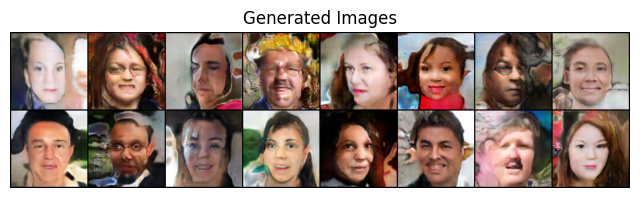

In [29]:
import torch
from torch import nn

# Define the Generator class
class Generator(nn.Module):
    def __init__(self, z_dim=128, img_channels=3, feature_maps=64):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, feature_maps * 8, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(feature_maps * 8),
            nn.ReLU(),

            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(),

            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(),

            nn.ConvTranspose2d(feature_maps * 2, feature_maps, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(),

            nn.ConvTranspose2d(feature_maps, feature_maps // 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps // 2),
            nn.ReLU(),

            nn.ConvTranspose2d(feature_maps // 2, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, noise):
        return self.gen(noise)

# Instantiate and load the checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"
z_dim = 128
gen = Generator(z_dim=z_dim, img_channels=3, feature_maps=64).to(device)

# Adjust the checkpoint keys to match the model
checkpoint_path = "/kaggle/working/checkpoints/checkpoint_epoch_29.pth"  # Update with your checkpoint path
checkpoint = torch.load(checkpoint_path)

# Fix the key mismatch
adjusted_state_dict = {"gen." + k if not k.startswith("gen.") else k: v for k, v in checkpoint['gen_state_dict'].items()}
gen.load_state_dict(adjusted_state_dict, strict=True)
gen.eval()

print("Generator loaded successfully.")

# Generate sample images
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Generate random noise and pass through generator
num_images = 16
fixed_noise = torch.randn(num_images, z_dim, 1, 1, device=device)
fake_images = gen(fixed_noise).detach().cpu()

# Visualize the images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(vutils.make_grid(fake_images, padding=2, normalize=True).permute(1, 2, 0))
plt.show()


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset

# 1. Classifier Definition
class SimpleClassifier(nn.Module):
    def __init__(self, img_channels=3, num_classes=10):
        super(SimpleClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [31]:
# 2. Generate Synthetic Data
def generate_synthetic_data(generator, z_dim, num_samples, num_classes, device):
    generator.eval()
    labels = torch.randint(0, num_classes, (num_samples,), device=device)  # Random class labels
    noise = torch.randn(num_samples, z_dim, 1, 1, device=device)  # Random noise
    synthetic_images = generator(noise).detach()
    return synthetic_images, labels

In [32]:
# 3. Data Loading and Preprocessing
def load_real_data(batch_size):
    transform = transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to match synthetic data
    ])
    dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [33]:
# 4. Combine Real and Synthetic Data
def combine_data(real_loader, synthetic_images, synthetic_labels, batch_size):
    real_data = next(iter(real_loader))
    real_images, real_labels = real_data
    combined_images = torch.cat((real_images, synthetic_images), dim=0)
    combined_labels = torch.cat((real_labels, synthetic_labels), dim=0)
    combined_dataset = TensorDataset(combined_images, combined_labels)
    combined_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
    return combined_loader

In [36]:
import torch

print(f"Available memory: {torch.cuda.memory_allocated() / (1024**3):.2f} GB")
print(f"Allocated memory: {torch.cuda.memory_reserved() / (1024**3):.2f} GB")
torch.cuda.empty_cache()  # This can help clear unused memory

Available memory: 11.99 GB
Allocated memory: 13.41 GB


Generating chunk 1
Generating chunk 2
Generating chunk 3
Generating chunk 4
Generating chunk 5
Generating chunk 6
Generating chunk 7
Generating chunk 8
Generating chunk 9
Generating chunk 10
Generating chunk 11
Generating chunk 12
Generating chunk 13
Generating chunk 14
Generating chunk 15
Generating chunk 16
Generating chunk 17
Generating chunk 18
Generating chunk 19
Generating chunk 20
Generating chunk 21
Generating chunk 22
Generating chunk 23
Generating chunk 24
Generating chunk 25
Generating chunk 26
Generating chunk 27
Generating chunk 28
Generating chunk 29
Generating chunk 30
Generating chunk 31
Generating chunk 32
Generating chunk 33
Generating chunk 34
Generating chunk 35
Generating chunk 36
Generating chunk 37
Generating chunk 38
Generating chunk 39
Generating chunk 40
Generating chunk 41
Generating chunk 42
Generating chunk 43
Generating chunk 44
Generating chunk 45
Generating chunk 46
Generating chunk 47


<ipython-input-39-58de0194495f>:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use mixed precision for memory efficiency


Generating chunk 48
Generating chunk 49
Generating chunk 50
Generating chunk 51
Generating chunk 52
Generating chunk 53
Generating chunk 54
Generating chunk 55
Generating chunk 56
Generating chunk 57
Generating chunk 58
Generating chunk 59
Generating chunk 60
Generating chunk 61
Generating chunk 62
Generating chunk 63
Visualizing some synthetic images...


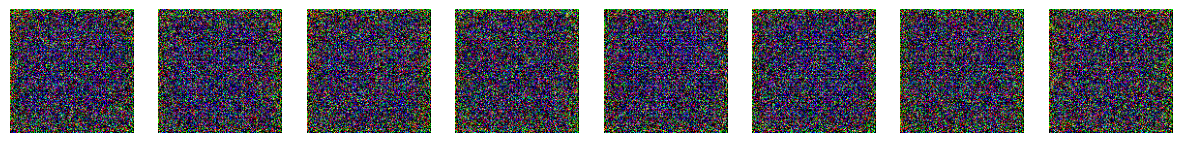

Epoch [1/30], Loss: 2.3263, Accuracy: 10.37%
Epoch [2/30], Loss: 2.3024, Accuracy: 10.71%
Epoch [3/30], Loss: 2.3017, Accuracy: 10.96%
Epoch [4/30], Loss: 2.3016, Accuracy: 11.61%
Epoch [5/30], Loss: 2.3002, Accuracy: 12.25%
Epoch [6/30], Loss: 2.3002, Accuracy: 10.96%
Epoch [7/30], Loss: 2.2978, Accuracy: 11.46%
Epoch [8/30], Loss: 2.2925, Accuracy: 11.90%
Epoch [9/30], Loss: 2.2774, Accuracy: 13.49%
Epoch [10/30], Loss: 2.2596, Accuracy: 17.26%
Visualizing predictions after epoch 10


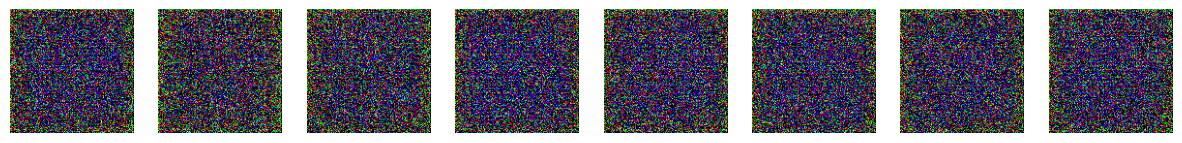

Predicted labels: [3 3 3 3 3 3 3 3 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3
 3 3 3 2 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
True labels: [1 8 9 7 1 0 6 9 2 2 9 9 9 3 4 3 8 3 9 0 7 9 6 7 0 2 6 9 0 3 2 4 7 5 3 5 6
 7 9 6 2 6 6 9 8 7 3 2 6 5 4 3 1 0 4 8 0 6 1 9 2 8 6 8]
Epoch [11/30], Loss: 2.2325, Accuracy: 20.83%
Epoch [12/30], Loss: 2.1358, Accuracy: 25.00%
Epoch [13/30], Loss: 2.0062, Accuracy: 34.52%
Epoch [14/30], Loss: 1.7682, Accuracy: 53.37%
Epoch [15/30], Loss: 1.4275, Accuracy: 64.53%
Epoch [16/30], Loss: 1.1078, Accuracy: 77.83%
Epoch [17/30], Loss: 0.7505, Accuracy: 87.90%
Epoch [18/30], Loss: 0.3897, Accuracy: 97.57%
Epoch [19/30], Loss: 0.2152, Accuracy: 99.26%
Epoch [20/30], Loss: 0.1118, Accuracy: 99.85%
Visualizing predictions after epoch 20


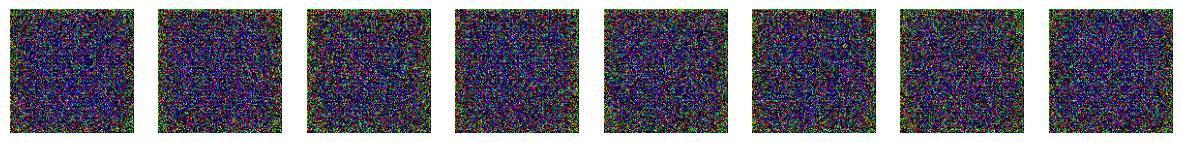

Predicted labels: [3 4 5 1 5 3 5 9 7 4 2 9 6 4 9 8 2 4 5 4 5 9 3 4 3 0 5 2 1 1 9 2 4 3 3 0 6
 0 0 6 7 4 5 5 9 2 1 5 8 1 2 5 0 0 5 6 7 1 5 1 5 6 2 5]
True labels: [3 4 5 1 5 3 5 9 7 4 2 9 6 4 9 8 2 4 5 4 5 9 3 4 3 0 5 2 1 1 9 2 4 3 3 0 6
 0 0 6 7 4 5 5 9 2 1 5 8 1 2 5 0 0 5 6 7 1 5 1 5 6 2 5]
Epoch [21/30], Loss: 0.0631, Accuracy: 99.95%
Epoch [22/30], Loss: 0.0372, Accuracy: 100.00%
Epoch [23/30], Loss: 0.0245, Accuracy: 100.00%
Epoch [24/30], Loss: 0.0185, Accuracy: 100.00%
Epoch [25/30], Loss: 0.0142, Accuracy: 100.00%
Epoch [26/30], Loss: 0.0114, Accuracy: 100.00%
Epoch [27/30], Loss: 0.0101, Accuracy: 100.00%
Epoch [28/30], Loss: 0.0081, Accuracy: 100.00%
Epoch [29/30], Loss: 0.0069, Accuracy: 100.00%
Epoch [30/30], Loss: 0.0057, Accuracy: 100.00%
Visualizing predictions after epoch 30


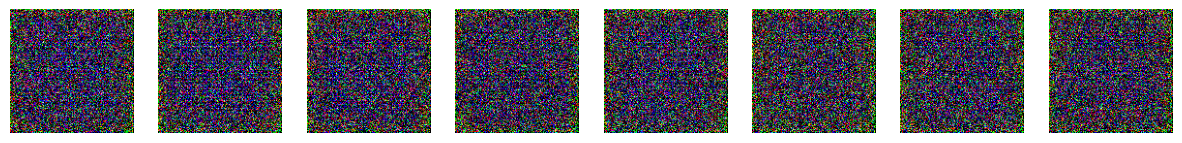

Predicted labels: [3 0 5 8 9 7 4 7 2 5 4 1 0 6 8 6 2 8 9 8 2 4 2 1 2 2 0 0 6 8 6 3 9 0 5 8 4
 2 7 6 1 8 6 1 0 6 8 5 0 3 4 6 0 4 9 7 7 0 7 3 0 0 0 2]
True labels: [3 0 5 8 9 7 4 7 2 5 4 1 0 6 8 6 2 8 9 8 2 4 2 1 2 2 0 0 6 8 6 3 9 0 5 8 4
 2 7 6 1 8 6 1 0 6 8 5 0 3 4 6 0 4 9 7 7 0 7 3 0 0 0 2]


In [39]:
import torch
from torch.cuda.amp import autocast
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import matplotlib.pyplot as plt

# Generator class (unchanged from before)
class Generator(nn.Module):
    def __init__(self, z_dim=128, img_channels=3, feature_maps=64):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(z_dim, feature_maps * 8, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(feature_maps * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_maps * 2, feature_maps, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_maps, feature_maps // 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_maps // 2),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_maps // 2, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, noise):
        return self.gen(noise)

# Simple CNN Classifier for Image Classification Task
class Classifier(nn.Module):
    def __init__(self, img_channels=3, num_classes=10):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Function to generate and store data in chunks to avoid OOM
def generate_and_store_data_in_chunks(generator, z_dim, num_samples, num_classes, device, chunk_size=32):
    all_images = []
    all_labels = []
    
    for i in range(0, num_samples, chunk_size):
        print(f"Generating chunk {i // chunk_size + 1}")
        noise = torch.randn(chunk_size, z_dim, 1, 1, device=device)  # Random noise for each batch
        with autocast():  # Use mixed precision for memory efficiency
            chunk_images = generator(noise).detach()
        
        chunk_labels = torch.randint(0, num_classes, (chunk_size,), device=device)  # Random class labels
        
        all_images.append(chunk_images)
        all_labels.append(chunk_labels)
        
        # Clear GPU memory after processing each chunk
        torch.cuda.empty_cache()

    # Concatenate all chunks
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_images, all_labels

# Set device and parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
z_dim = 128  # Latent dimension
num_samples = 2000  # Number of samples to generate
num_classes = 10  # Number of classes for classification task
batch_size = 32  # Batch size for data generation (reduce if necessary)

# Load the generator model
gen = Generator(z_dim=z_dim, img_channels=3, feature_maps=64).to(device)

# Generate synthetic data
synthetic_images, synthetic_labels = generate_and_store_data_in_chunks(gen, z_dim, num_samples, num_classes, device, chunk_size=batch_size)

# Normalize the synthetic images (same transformation used during training)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Apply the transformation
synthetic_images = torch.stack([transform(img) for img in synthetic_images])

# Create a DataLoader for the synthetic data
dataset = TensorDataset(synthetic_images, synthetic_labels)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize the classifier
classifier = Classifier(img_channels=3, num_classes=num_classes).to(device)

# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.0002)

# Function to plot generated images
def plot_generated_images(images, num_images=8):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i in range(num_images):
        axes[i].imshow(images[i].permute(1, 2, 0).cpu().numpy())
        axes[i].axis('off')
    plt.show()

# Visualize some synthetic images before training
print("Visualizing some synthetic images...")
plot_generated_images(synthetic_images)

# Training loop for the classifier
num_epochs = 30
for epoch in range(num_epochs):
    classifier.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Visualize some predictions after every few epochs
    if (epoch + 1) % 10 == 0:  # Plot every 10th epoch
        classifier.eval()
        with torch.no_grad():
            example_images, example_labels = next(iter(data_loader))
            example_images, example_labels = example_images.to(device), example_labels.to(device)
            example_outputs = classifier(example_images)
            _, predicted_labels = torch.max(example_outputs, 1)

            # Visualize predictions
            print(f"Visualizing predictions after epoch {epoch + 1}")
            plot_generated_images(example_images, num_images=8)
            print("Predicted labels:", predicted_labels.cpu().numpy())
            print("True labels:", example_labels.cpu().numpy())

# Optionally, after training you can test on a validation set or save the model
# torch.save(classifier.state_dict(), "classifier.pth")
